El enlace del Proyecto 04 en GitHub es:

https://github.com/GuilleEma/Acamica_DS_proyecto03/blob/main/Proyecto_03_ST_GuillerminaEmanuelli.ipynb


# Modelando la Pandemia

  En este proyecto vamos a estudiar y analizar los datos mundiales de la pandemia COVID-19 usando países modelo de distintas políticas públicas para luego interpretar otras curvas.

Puedes descargar el dataset de casos totales, divididos por país [aquí.](
https://ourworldindata.org/coronavirus-data?country=
) Descarga los datos  formato .csv luego podrás cargarlos en el notebook usando pandas, a partir de eso selecciona los de los países que te interesan, hay un ejemplo de cómo se hace esto en este notebook. 


In [619]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as plt
import scipy.stats as st
from google.colab import drive
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
import plotly.express as px
import plotly.graph_objs as go

In [620]:
# Definimos una funcion para evaluar el desempeño del modelo

def evaluacion_modelo(model, X_train, X_test, y_train, y_test):

  global rmse_train, rmse_test, r_squared_tra, adjusted_r_squared_tra, r_squared_te, adjusted_r_squared_te, y_test_pred,y_train_pred
  model.fit(X_train, y_train)
  y_train_pred = model.predict(X_train) 
  y_test_pred = model.predict(X_test)

  
  # Calculo de RMSE 
  rmse_train = np.sqrt(mean_squared_error(y_train,y_train_pred))
  rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
  print(f'RMSE Train: {rmse_train}\n')
  print(f'RMSE Test: {rmse_test}\n')
  
  # Calculo de mae 
  mae_train = mean_absolute_error(y_train,y_train_pred)
  mae_test = mean_absolute_error(y_test, y_test_pred)
  print(f'MAE Train: {mae_train}\n')
  print(f'MAE Test: {mae_test}\n')

  # Calculo de R cuadrado y R cuadrado ajustado del conjunto TRAIN
  SS_Residual_a = sum((y_train - y_train_pred)**2)       
  SS_Total_a = sum((y_train-np.mean(y_train))**2)     
  r_squared_tra = 1 - (float(SS_Residual_a))/SS_Total_a
  adjusted_r_squared_tra = 1 - (1-r_squared_tra)*(len(y)-1)/(len(y)-X.shape[1]-1)
  print(f"R2(train)= {r_squared_tra}")
  print(f"R2_ajt(train)= {adjusted_r_squared_tra}\n")
  
  # Calculo de R cuadrado y R cuadrado ajustado del conjunto TEST
  SS_Residual_b = sum((y_test - y_test_pred)**2)       
  SS_Total_b = sum((y_test-np.mean(y_test))**2)     
  r_squared_te = 1 - (float(SS_Residual_b))/SS_Total_b
  adjusted_r_squared_te = 1 - (1-r_squared_te)*(len(y)-1)/(len(y)-X.shape[1]-1)
  print(f"R2(test)= {r_squared_te}") 
  print(f"R2_ajt(test)= {adjusted_r_squared_te}\n")
  
  #Histograma de los errores (y - y_predicho) para cada conjunto:
  plt.figure(figsize = (12,4))
  plt.subplot(1,2,1)
  sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
  sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
  plt.xlabel('errores')
  plt.legend()

  #Scatter de y vs y-predicho para lo testeado:
  ax = plt.subplot(1,2,2)
  ax.scatter(y_test,y_test_pred, s =2)
  
  tabla_errores = pd.concat([
    pd.DataFrame({
      'Tipo_error': "Entrenamiento",
      'Error': y_train - y_train_pred
    }), 
    pd.DataFrame({
      'Tipo_error': "Test",
      'Error': y_test - y_test_pred
    })
  ])
  
  
   #boxplot de los errores (y - y_predicho) para cada conjunto:
  plt.figure(figsize = (5,10))
  plt.subplot(2,1,1)
  
  sns.boxplot(data= tabla_errores,
              x= 'Tipo_error',
              y= 'Error')
  
  plt.legend()
      
  lims = [
      np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
      np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
      ]
      
  ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
  plt.xlabel('y (test)')
  plt.ylabel('y_pred (test)')
  plt.tight_layout()
  plt.show()

In [621]:
#cargamos los datos
drive.mount('/content/gdrive', force_remount=True)

# Aca deben apuntar a la carpeta de su drive donde guardaron los datos
root_dir = "/content/gdrive/MyDrive/Colab Notebooks/SPRINT_04/Sprint Proyect 04/Proyecto_04_GuillerminaEmanuelli.ipynb"

Mounted at /content/gdrive


In [622]:
datos=pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/SPRINT_04/Sprint Proyect 04/owid-covid-data.csv')
datos.head()

iso_code continent     location        date  total_cases  new_cases  \
0      AFG      Asia  Afghanistan  2020-02-24          5.0        5.0   
1      AFG      Asia  Afghanistan  2020-02-25          5.0        0.0   
2      AFG      Asia  Afghanistan  2020-02-26          5.0        0.0   
3      AFG      Asia  Afghanistan  2020-02-27          5.0        0.0   
4      AFG      Asia  Afghanistan  2020-02-28          5.0        0.0   

   new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  ...  \
0                 NaN           NaN         NaN                  NaN  ...   
1                 NaN           NaN         NaN                  NaN  ...   
2                 NaN           NaN         NaN                  NaN  ...   
3                 NaN           NaN         NaN                  NaN  ...   
4                 NaN           NaN         NaN                  NaN  ...   

   female_smokers  male_smokers  handwashing_facilities  \
0             NaN           NaN                  37.746   
1             NaN           NaN                  37.746   
2             NaN           NaN                  37.746   
3             NaN           NaN                  37.746   
4             NaN           NaN                  37.746   

   hospital_beds_per_thousand  life_expectancy  human_development_index  \
0                         0.5            64.83                    0.511   
1                         0.5            64.83                    0.511   
2                         0.5            64.83                    0.511   
3                         0.5            64.83                    0.511   
4                         0.5            64.83                    0.511   

   excess_mortality_cumulative_absolute  excess_mortality_cumulative  \
0                                   NaN                          NaN   
1                                   NaN                          NaN   
2                                   NaN                          NaN   
3                                   NaN                          NaN   
4                                   NaN                          NaN   

   excess_mortality  excess_mortality_cumulative_per_million  
0               NaN                                      NaN  
1               NaN                                      NaN  
2               NaN                                      NaN  
3               NaN                                      NaN  
4               NaN                                      NaN  

[5 rows x 67 columns]

Analizamos el tamaño del dataset

In [623]:
print(datos.shape)

(163318, 67)


El dataset tiene 67 columnas y 163.318 filas.

Analizamos el tipo de información del dataset: nombre de las columnas, cantidad de valores no nulos y el tipo de dato. 

In [624]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163318 entries, 0 to 163317
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    163318 non-null  object 
 1   continent                                   153531 non-null  object 
 2   location                                    163318 non-null  object 
 3   date                                        163318 non-null  object 
 4   total_cases                                 160326 non-null  float64
 5   new_cases                                   160246 non-null  float64
 6   new_cases_smoothed                          159095 non-null  float64
 7   total_deaths                                142603 non-null  float64
 8   new_deaths                                  142758 non-null  float64
 9   new_deaths_smoothed                         142628 non-null  float64
 

In [625]:
# vemos los nombres de las columnas del dataset
print(datos.columns)

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

In [626]:
# analizamos que variables son de tipo categorica y cuales son de tipo numericas
var_num = []
var_cat = []

for i in datos.columns:
  if datos.dtypes[i] != "object":
    var_num.append(i)
  else :
    var_cat.append(i)

print(f"Variables de tipo categoricas: {var_cat}")
print(f"Variables de tipo numericas: {var_num}")

Variables de tipo categoricas: ['iso_code', 'continent', 'location', 'date', 'tests_units']
Variables de tipo numericas: ['total_cases', 'new_cases', 'new_cases_smoothed', 'total_deaths', 'new_deaths', 'new_deaths_smoothed', 'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million', 'new_deaths_per_million', 'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients', 'icu_patients_per_million', 'hosp_patients', 'hosp_patients_per_million', 'weekly_icu_admissions', 'weekly_icu_admissions_per_million', 'weekly_hosp_admissions', 'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests', 'total_tests_per_thousand', 'new_tests_per_thousand', 'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'positive_rate', 'tests_per_case', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'total_boosters', 'new_vaccinations', 'new_vaccinations_smoothed', 'total_vaccinations_per_hundred', 'people_vaccinated

In [627]:
# renombramos la columna que contiene el nombre del pais para interpretar mas facil
datos.rename({'location':'pais'}, axis=1, inplace=True)
datos.head()

iso_code continent         pais        date  total_cases  new_cases  \
0      AFG      Asia  Afghanistan  2020-02-24          5.0        5.0   
1      AFG      Asia  Afghanistan  2020-02-25          5.0        0.0   
2      AFG      Asia  Afghanistan  2020-02-26          5.0        0.0   
3      AFG      Asia  Afghanistan  2020-02-27          5.0        0.0   
4      AFG      Asia  Afghanistan  2020-02-28          5.0        0.0   

   new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  ...  \
0                 NaN           NaN         NaN                  NaN  ...   
1                 NaN           NaN         NaN                  NaN  ...   
2                 NaN           NaN         NaN                  NaN  ...   
3                 NaN           NaN         NaN                  NaN  ...   
4                 NaN           NaN         NaN                  NaN  ...   

   female_smokers  male_smokers  handwashing_facilities  \
0             NaN           NaN                  37.746   
1             NaN           NaN                  37.746   
2             NaN           NaN                  37.746   
3             NaN           NaN                  37.746   
4             NaN           NaN                  37.746   

   hospital_beds_per_thousand  life_expectancy  human_development_index  \
0                         0.5            64.83                    0.511   
1                         0.5            64.83                    0.511   
2                         0.5            64.83                    0.511   
3                         0.5            64.83                    0.511   
4                         0.5            64.83                    0.511   

   excess_mortality_cumulative_absolute  excess_mortality_cumulative  \
0                                   NaN                          NaN   
1                                   NaN                          NaN   
2                                   NaN                          NaN   
3                                   NaN                          NaN   
4                                   NaN                          NaN   

   excess_mortality  excess_mortality_cumulative_per_million  
0               NaN                                      NaN  
1               NaN                                      NaN  
2               NaN                                      NaN  
3               NaN                                      NaN  
4               NaN                                      NaN  

[5 rows x 67 columns]

Investigamos el comportamiento de las algunas variables categoricas.

In [628]:
print(datos['continent'].unique())

['Asia' nan 'Europe' 'Africa' 'North America' 'South America' 'Oceania']


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

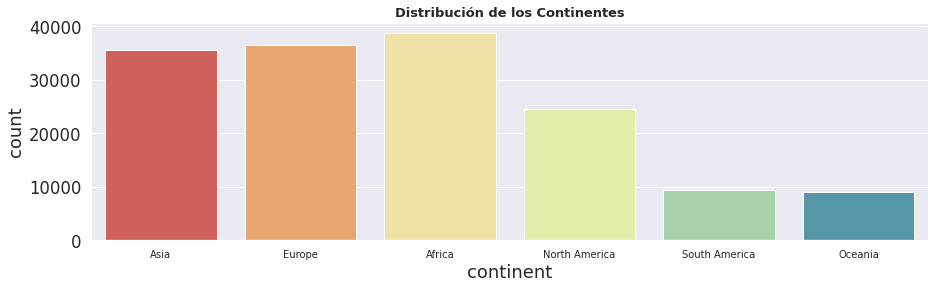

In [629]:
plt.figure(figsize=(15,4))

sns.countplot(datos.continent, palette='Spectral')
plt.title('Distribución de los Continentes', size=13, fontweight='bold')
plt.xticks(size=10)

In [630]:
print(datos['pais'].unique())

['Afghanistan' 'Africa' 'Albania' 'Algeria' 'Andorra' 'Angola' 'Anguilla'
 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Aruba' 'Asia' 'Australia'
 'Austria' 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh' 'Barbados'
 'Belarus' 'Belgium' 'Belize' 'Benin' 'Bermuda' 'Bhutan' 'Bolivia'
 'Bonaire Sint Eustatius and Saba' 'Bosnia and Herzegovina' 'Botswana'
 'Brazil' 'British Virgin Islands' 'Brunei' 'Bulgaria' 'Burkina Faso'
 'Burundi' 'Cambodia' 'Cameroon' 'Canada' 'Cape Verde' 'Cayman Islands'
 'Central African Republic' 'Chad' 'Chile' 'China' 'Colombia' 'Comoros'
 'Congo' 'Cook Islands' 'Costa Rica' "Cote d'Ivoire" 'Croatia' 'Cuba'
 'Curacao' 'Cyprus' 'Czechia' 'Democratic Republic of Congo' 'Denmark'
 'Djibouti' 'Dominica' 'Dominican Republic' 'Ecuador' 'Egypt'
 'El Salvador' 'Equatorial Guinea' 'Eritrea' 'Estonia' 'Eswatini'
 'Ethiopia' 'Europe' 'European Union' 'Faeroe Islands' 'Falkland Islands'
 'Fiji' 'Finland' 'France' 'French Polynesia' 'Gabon' 'Gambia' 'Georgia'
 'Germany' 'Ghana'

In [631]:
print(datos['tests_units'].unique())

[nan 'tests performed' 'units unclear' 'samples tested' 'people tested']


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

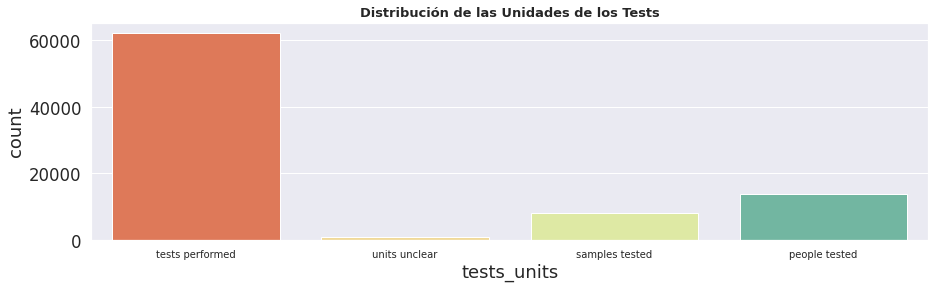

In [632]:
plt.figure(figsize=(15,4))

sns.countplot(datos.tests_units, palette='Spectral')
plt.title('Distribución de las Unidades de los Tests', size=13, fontweight='bold')
plt.xticks(size=10)

In [633]:
# pasamos la columna fecha (date) a formato datetime
datos['date2'] = pd.to_datetime(datos.date)

# eliminamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
datos.drop(columns=['date'], inplace = True)

datos.head()

iso_code continent         pais  total_cases  new_cases  new_cases_smoothed  \
0      AFG      Asia  Afghanistan          5.0        5.0                 NaN   
1      AFG      Asia  Afghanistan          5.0        0.0                 NaN   
2      AFG      Asia  Afghanistan          5.0        0.0                 NaN   
3      AFG      Asia  Afghanistan          5.0        0.0                 NaN   
4      AFG      Asia  Afghanistan          5.0        0.0                 NaN   

   total_deaths  new_deaths  new_deaths_smoothed  total_cases_per_million  \
0           NaN         NaN                  NaN                    0.126   
1           NaN         NaN                  NaN                    0.126   
2           NaN         NaN                  NaN                    0.126   
3           NaN         NaN                  NaN                    0.126   
4           NaN         NaN                  NaN                    0.126   

   ...  male_smokers  handwashing_facilities  hospital_beds_per_thousand  \
0  ...           NaN                  37.746                         0.5   
1  ...           NaN                  37.746                         0.5   
2  ...           NaN                  37.746                         0.5   
3  ...           NaN                  37.746                         0.5   
4  ...           NaN                  37.746                         0.5   

   life_expectancy  human_development_index  \
0            64.83                    0.511   
1            64.83                    0.511   
2            64.83                    0.511   
3            64.83                    0.511   
4            64.83                    0.511   

   excess_mortality_cumulative_absolute  excess_mortality_cumulative  \
0                                   NaN                          NaN   
1                                   NaN                          NaN   
2                                   NaN                          NaN   
3                                   NaN                          NaN   
4                                   NaN                          NaN   

   excess_mortality  excess_mortality_cumulative_per_million      date2  
0               NaN                                      NaN 2020-02-24  
1               NaN                                      NaN 2020-02-25  
2               NaN                                      NaN 2020-02-26  
3               NaN                                      NaN 2020-02-27  
4               NaN                                      NaN 2020-02-28  

[5 rows x 67 columns]

In [634]:
# renombramos la columna date2 a date
datos.rename(columns = {'date2':'date'}, inplace = True) 
datos.head()

iso_code continent         pais  total_cases  new_cases  new_cases_smoothed  \
0      AFG      Asia  Afghanistan          5.0        5.0                 NaN   
1      AFG      Asia  Afghanistan          5.0        0.0                 NaN   
2      AFG      Asia  Afghanistan          5.0        0.0                 NaN   
3      AFG      Asia  Afghanistan          5.0        0.0                 NaN   
4      AFG      Asia  Afghanistan          5.0        0.0                 NaN   

   total_deaths  new_deaths  new_deaths_smoothed  total_cases_per_million  \
0           NaN         NaN                  NaN                    0.126   
1           NaN         NaN                  NaN                    0.126   
2           NaN         NaN                  NaN                    0.126   
3           NaN         NaN                  NaN                    0.126   
4           NaN         NaN                  NaN                    0.126   

   ...  male_smokers  handwashing_facilities  hospital_beds_per_thousand  \
0  ...           NaN                  37.746                         0.5   
1  ...           NaN                  37.746                         0.5   
2  ...           NaN                  37.746                         0.5   
3  ...           NaN                  37.746                         0.5   
4  ...           NaN                  37.746                         0.5   

   life_expectancy  human_development_index  \
0            64.83                    0.511   
1            64.83                    0.511   
2            64.83                    0.511   
3            64.83                    0.511   
4            64.83                    0.511   

   excess_mortality_cumulative_absolute  excess_mortality_cumulative  \
0                                   NaN                          NaN   
1                                   NaN                          NaN   
2                                   NaN                          NaN   
3                                   NaN                          NaN   
4                                   NaN                          NaN   

   excess_mortality  excess_mortality_cumulative_per_million       date  
0               NaN                                      NaN 2020-02-24  
1               NaN                                      NaN 2020-02-25  
2               NaN                                      NaN 2020-02-26  
3               NaN                                      NaN 2020-02-27  
4               NaN                                      NaN 2020-02-28  

[5 rows x 67 columns]

Controlamos que la columna date se haya transformado a tipo de dato "datetime".

In [635]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163318 entries, 0 to 163317
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   iso_code                                    163318 non-null  object        
 1   continent                                   153531 non-null  object        
 2   pais                                        163318 non-null  object        
 3   total_cases                                 160326 non-null  float64       
 4   new_cases                                   160246 non-null  float64       
 5   new_cases_smoothed                          159095 non-null  float64       
 6   total_deaths                                142603 non-null  float64       
 7   new_deaths                                  142758 non-null  float64       
 8   new_deaths_smoothed                         142628 non-null  float64      

In [636]:
# reordenamos el dataset por fecha
datos.sort_values('date', inplace = True)
datos.reset_index(drop=True, inplace = True)
datos.head(10)

iso_code      continent       pais  total_cases  new_cases  \
0      ARG  South America  Argentina          NaN        NaN   
1      MEX  North America     Mexico          NaN        NaN   
2      MEX  North America     Mexico          NaN        NaN   
3      ARG  South America  Argentina          NaN        NaN   
4      ARG  South America  Argentina          NaN        NaN   
5      MEX  North America     Mexico          NaN        NaN   
6      ARG  South America  Argentina          NaN        NaN   
7      MEX  North America     Mexico          NaN        NaN   
8      THA           Asia   Thailand          NaN        NaN   
9      ARG  South America  Argentina          NaN        NaN   

   new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  \
0                 NaN           NaN         NaN                  NaN   
1                 NaN           NaN         NaN                  NaN   
2                 NaN           NaN         NaN                  NaN   
3                 NaN           NaN         NaN                  NaN   
4                 NaN           NaN         NaN                  NaN   
5                 NaN           NaN         NaN                  NaN   
6                 NaN           NaN         NaN                  NaN   
7                 NaN           NaN         NaN                  NaN   
8                 NaN           NaN         NaN                  NaN   
9                 NaN           NaN         NaN                  NaN   

   total_cases_per_million  ...  male_smokers  handwashing_facilities  \
0                      NaN  ...          27.7                     NaN   
1                      NaN  ...          21.4                  87.847   
2                      NaN  ...          21.4                  87.847   
3                      NaN  ...          27.7                     NaN   
4                      NaN  ...          27.7                     NaN   
5                      NaN  ...          21.4                  87.847   
6                      NaN  ...          27.7                     NaN   
7                      NaN  ...          21.4                  87.847   
8                      NaN  ...          38.8                  90.670   
9                      NaN  ...          27.7                     NaN   

   hospital_beds_per_thousand  life_expectancy  human_development_index  \
0                        5.00            76.67                    0.845   
1                        1.38            75.05                    0.779   
2                        1.38            75.05                    0.779   
3                        5.00            76.67                    0.845   
4                        5.00            76.67                    0.845   
5                        1.38            75.05                    0.779   
6                        5.00            76.67                    0.845   
7                        1.38            75.05                    0.779   
8                        2.10            77.15                    0.777   
9                        5.00            76.67                    0.845   

   excess_mortality_cumulative_absolute  excess_mortality_cumulative  \
0                                   NaN                          NaN   
1                                   NaN                          NaN   
2                                   NaN                          NaN   
3                                   NaN                          NaN   
4                                   NaN                          NaN   
5                                   NaN                          NaN   
6                                   NaN                          NaN   
7                                   NaN                          NaN   
8                                   NaN                          NaN   
9                                   NaN                          NaN   

   excess_mortality  excess_mortality_cumulative_per_million       date  
0      

Analizamos graficamente los nuevos casos de Covid_19 en cada continente.

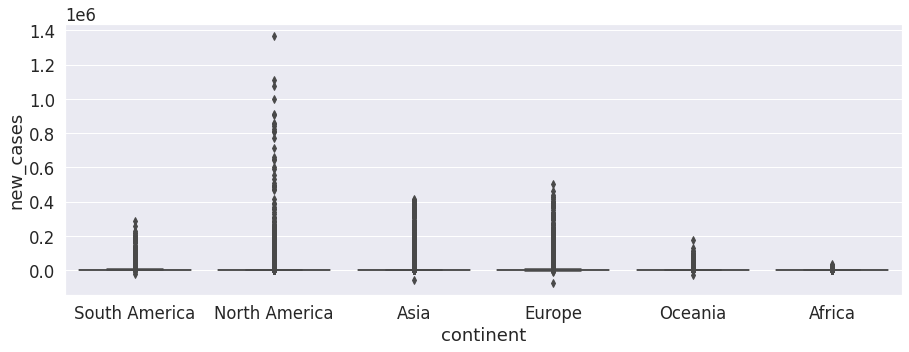

In [637]:
plt.rcParams["figure.figsize"] = (15, 5)
var = 'continent'
fig = sns.boxplot(x=var, y ="new_cases", data=datos)

De acuerdo al gráfico vemos que el continente que tiene el mayor número de casos de Covid_19 es America del Norte.

Analizamos graficamente las nuevas muertes de Covid_19 en cada continente.

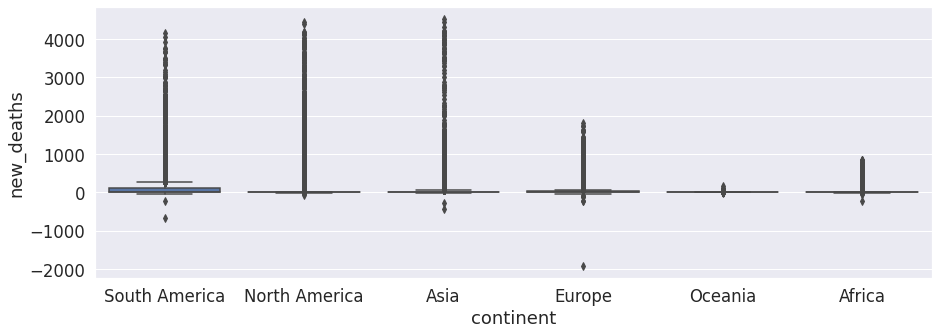

In [638]:
plt.rcParams["figure.figsize"] = (15, 5)
var = 'continent'
fig = sns.boxplot(x=var, y ="new_deaths", data=datos)

De acuerdo al gráfico vemos que los continentes que tiene el mayor número de muertes por Covid_19 son America del Norte y Asia.

# ¿Cómo empezó la pandemia?


  La primer parte del trabajo consiste en estudiar cómo se empieza a propagar la pandemia, luego analizaremos las medidas tomadas y su efectividad.

  Al inicio de una pandemia, se estima que los contagios siguen una ley exponencial, esa es la fase de "crecimiento exponencial", luego hay un decaimiento dado por la inmunidad. 

  Los datos de casos confirmados en función del tiempo $C(t)$, pueden aproximarse con el modelo

$C(t)=e^{k(t-t_0)}$

donde $t_0$ es la fecha del primer contagio, y $k$ es un parámetro propio de cada enfermedad, que habla de la contagiosidad. Cuanto mayor es $k$, más grande será el número de casos confirmados dado por la expresión. $k$ depende de el tiempo que una persona enferma contagia, el nivel de infecciosidad del virus y cuántas personas que se pueden contagiar ve una persona enferma por día. Es decir, la circulación. Haciendo cuarententa, $k$ disminuye, con la circulación $k$ aumenta.

  El parámetro $k$ está directamente relacionado con el $R$ del que tanto se habla en los medios. En este proyecto haremos foco en $k$, pero puedes profundizar sobre esto si quieres, empezandó por [aquí](https://es.wikipedia.org/wiki/Ritmo_reproductivo_b%C3%A1sico). 

  Es posible hacer un modelo completo, pero para eso es necesario utilizar ecuaciones diferenciales. Si quieres profundizar sobre eso, busca información sobre "modelo epidemiológico SEIR". Si quieres ver cómo funciona este modelo, puedes empezar por [aquí](http://gabgoh.github.io/COVID/index.html). En ese link está implementado el modelo SEIR (no es necesario entender las ecuaciones en este caso) y el rol que cumplen los parámetros, puedes explorar el impacto de variar $R$ y el resto de los valores para ver cómo impactan en la cirva de contagios. Ahora utilizaremos la siguiente expresión para describir únicamente la etapa de crecimiento exponencial.


  Comienza estudiando cómo se distribuyó el $k$ inicial de la pandemia y si es posible elaborar un intervalo de confianza razonable para este valor. Para eso 
  
  **1. Elegir diez países del norte (ahí empezó la pandemia) y puedes mide el valor de $k$ inicial de la pandemia, analizando datos del primer tramo.**


In [54]:
paises1 = datos[datos.pais.isin(["China", "Mongolia", "Iran", "Saudi Arabia", "Turkey", "Japan", "Afghanistan", "Thailand", "Pakistan", "Vietnam"])]

In [55]:
paises1 = paises1[['pais', 'total_cases', 'population']].groupby('pais', as_index=False).sum().sort_values('total_cases', ascending=False).head(10)
paises1

pais   total_cases    population
8        Turkey  2.703322e+09  6.055043e+10
2          Iran  1.784568e+09  6.232608e+10
3         Japan  5.213365e+08  9.592466e+10
5      Pakistan  4.858441e+08  1.637203e+11
7      Thailand  4.040894e+08  5.449171e+10
6  Saudi Arabia  2.709061e+08  2.548063e+10
9       Vietnam  2.477664e+08  7.460831e+10
4      Mongolia  1.199603e+08  2.373778e+09
1         China  6.682966e+07  1.099048e+12
0   Afghanistan  5.633339e+07  2.900019e+10

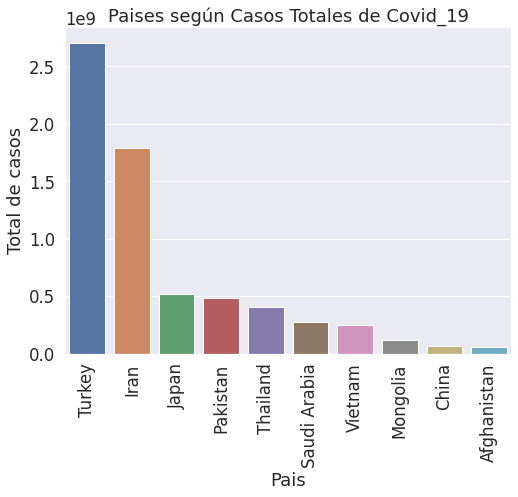

In [56]:
sns.set(font_scale=1.5)
plt.figure(figsize=(8, 6))
plt.xticks(rotation=90)
sns.barplot(data=paises1, x='pais', y='total_cases')
plt.xlabel('Pais')
plt.ylabel('Total de casos')
plt.title('Paises según Casos Totales de Covid_19')
plt.show()

In [82]:
# cargo el vector de paises
paises = datos['pais'] 
# cargo el vector de todos los casos confirmados
confirmados = datos['total_cases']

Estudios epidermiológicos han demostrado que la función exponencial es útil para modelar el primer período de una epidemia, en este caso, el Covid_19, considerando la cantidad de personas infectadas en un momento determinado.

La fórmula de la función exponencial está dada por 
$C(t)=e^{k(t-t_0)}$, los datos de casos confirmados en función del tiempo $C(t)$. Tomamos los días donde el comportamiento fue mas sostenido y calculamos el número de personas infectadas; fue necesario encontrar el factor de crecimiento del Covid_19 pero dado que solo tenemos la cantidad de casos por día y no el factor de crecimiento, reescribimos la fórmula mediante logaritmos ya que a partir de observaciones diarias empíricas usamos una Regresión lineal.

In [83]:
#definimos función para ajustar modelo
def exponencial(t,k,t0):
  C=np.exp(k*(t-t0))
  return C

Hacemos una función que determine los casos nuevos por día a partir de estas curvas.

In [84]:
def casos_nuevos(casos):
  nuevos=np.zeros(len(casos))
  i=0
  while i<len(nuevos)-1:
    nuevos[i]=casos[i+1]-casos[i]
    i=i+1

  return nuevos   

**Pais 1: China**

Text(0, 0.5, 'cantidad de casos')

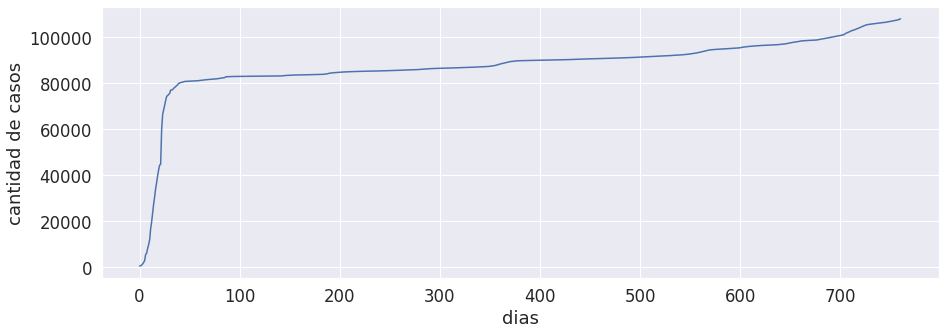

In [202]:
ind_chi=np.where(paises=='China')
ind_chi=ind_chi[0]
casos_chi=confirmados[ind_chi]
dias=np.arange(0,len(casos_chi))
plt.plot(dias,casos_chi)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Esta es la curva de **casos totales** de China. Aquí no se ven las olas, ya que estas se ven en la curva de casos confirmados por día, es decir, de casos nuevos. Esta habla de los acumulados, entonces siempre se agregan.

Para ver mejor la curva, tomamos el logartimo de los datos. Una curva exponencial se ve lineal en escala logarítmica


Text(0, 0.5, 'log cantidad de casos')

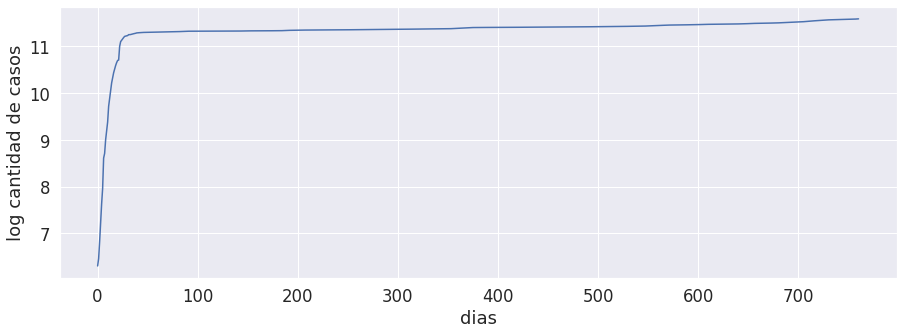

In [203]:
plt.plot(dias,np.log(casos_chi))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

Veamos lo que pasa en los primeros 60 días desde que se detectó el primer caso en China, para ver cómo fue el $k$ inicial

Text(0, 0.5, 'cantidad de casos')

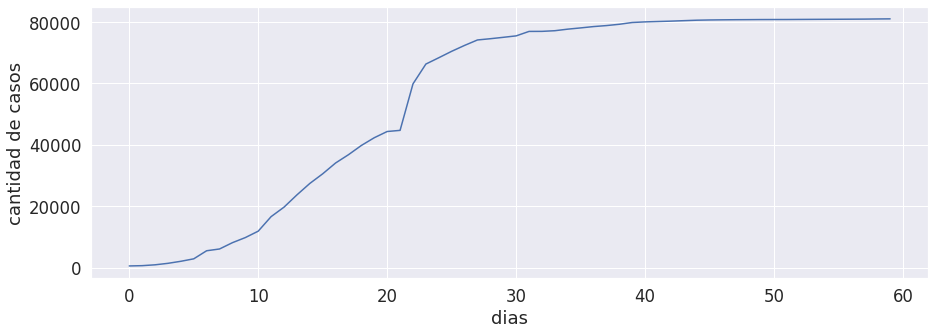

In [204]:
casos_principio=casos_chi[0:60]
dias_principio=dias[0:60]

plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Analicemos qué pasa en escala logarítmica.

Text(0, 0.5, 'log cantidad de casos')

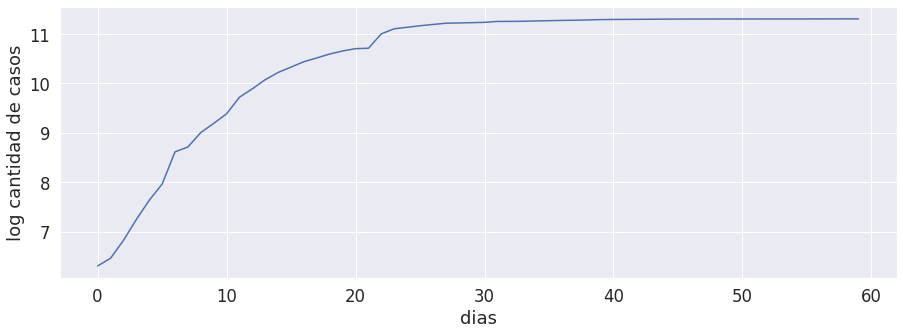

In [205]:
plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

Mejor nos quedamos con lo que sucede entre los días 0 y 30, ya que ese fue el comportamiento más sostenido.

Text(0, 0.5, 'cantidad de casos')

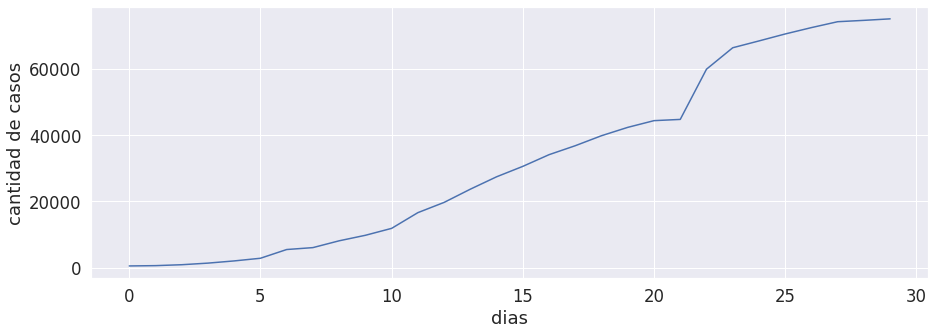

In [206]:
casos_principio=casos_chi[0:30]
dias_principio=dias[0:30]
plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Text(0, 0.5, 'log cantidad de casos')

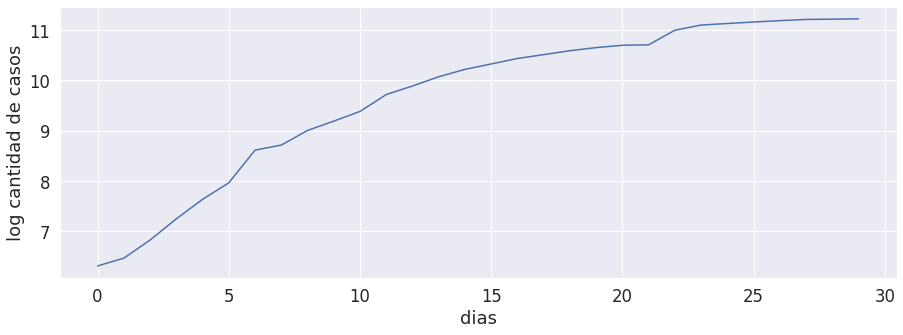

In [207]:
plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

Vamos a usar esta función para calcular el valor de C para cada valor de t de 0 a 29. Cuando hacemos esto, obtenemos los siguientes números de personas infectadas en cada paso de tiempo.

In [208]:
#ajustamos
popt, pcov = curve_fit(exponencial, dias_principio, casos_principio, maxfev=100000)
popt # aca nos da el array de los parametros

array([ 8.67777193e-02, -1.02534243e+02])

Veamos cómo se ajusta lo que obtuvimos a los datos reales

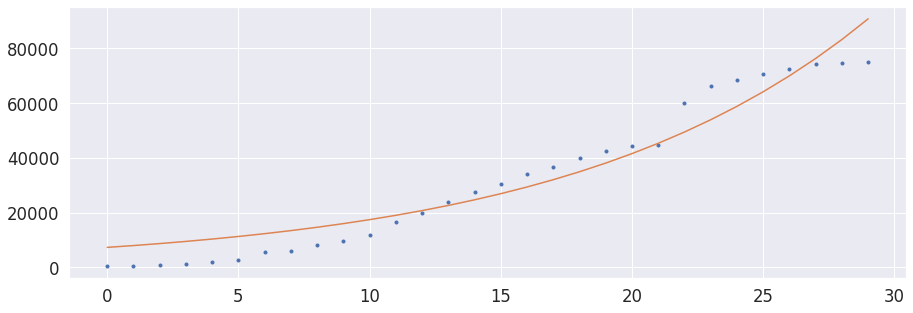

In [209]:
k=popt[0]
t0=popt[1]
casos_simu=exponencial(dias_principio,k,t0)
plt.plot(dias_principio,casos_principio,'.')
plt.plot(dias_principio,casos_simu)

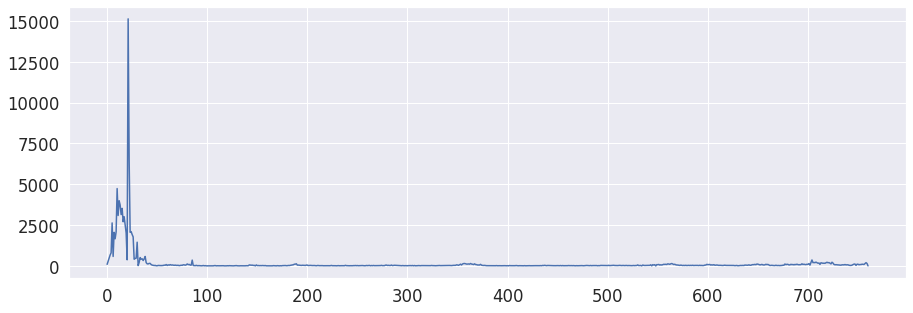

In [210]:
casos_chi=np.array(casos_chi)
nuevos_chi=casos_nuevos(casos_chi)
plt.plot(nuevos_chi)

In [211]:
rmse_chi = mean_squared_error(casos_principio, casos_simu)
print(np.format_float_scientific(rmse_chi))

4.7625408896457285e+07


In [212]:
t0_chi = dias_principio[0]
t_chi = dias_principio[-1]
k_chi = k
rmse_chi = rmse_chi

dic_chi = {"Pais": "China", "t0":[t0_chi], "t":[t_chi], "k": [k_chi], "rmse":[rmse_chi]}
datos_chi = pd.DataFrame(data=dic_chi)
datos_chi

Pais  t0   t         k          rmse
0  China   0  29  0.086778  4.762541e+07

**Pais 2: Mongolia**

Text(0, 0.5, 'cantidad de casos')

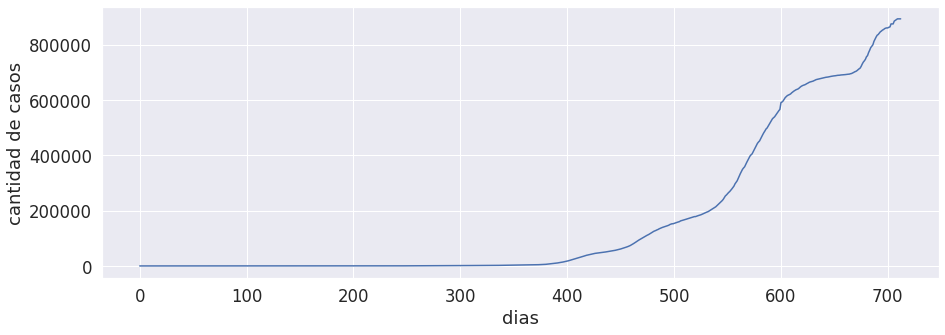

In [99]:
ind_mon=np.where(paises=='Mongolia')
ind_mon=ind_mon[0]
casos_mon=confirmados[ind_mon]
dias=np.arange(0,len(casos_mon))
plt.plot(dias,casos_mon)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Esta es la curva de **casos totales** de Mongolia. Aquí no se ven las olas, ya que estas se ven en la curva de casos confirmados por día, es decir, de casos nuevos. Esta habla de los acumulados, entonces siempre se agregan.

Para ver mejor la curva, tomamos el logartimo de los datos. Una curva exponencial se ve lineal en escala logarítmica


Text(0, 0.5, 'log cantidad de casos')

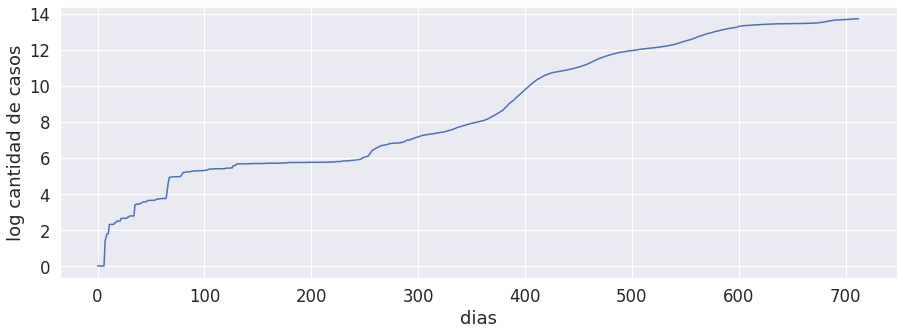

In [100]:
plt.plot(dias,np.log(casos_mon))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

Text(0, 0.5, 'cantidad de casos')

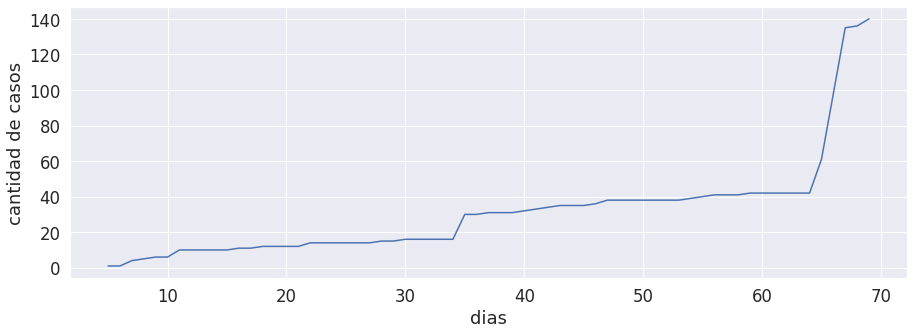

In [101]:
# veamos los primeros 70 días desde que se detectó el 1er caso, para ver cómo fue el k inicial
casos_principio=casos_mon[5:70]
dias_principio=dias[5:70]

plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Text(0, 0.5, 'log cantidad de casos')

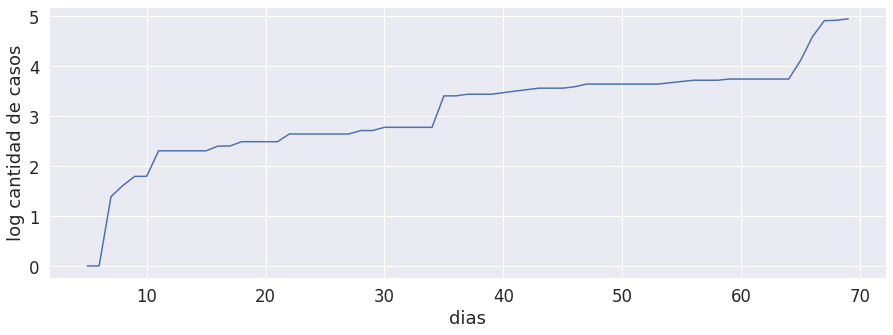

In [102]:
# como es difícil determinar si esta parte es exponencial. Analicemos qué pasa en escala logarítmica.
plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

Mejor nos quedamos con lo que sucede entre los días 7 y 50, ya que ese fue el comportamiento más sostenido.

Text(0, 0.5, 'cantidad de casos')

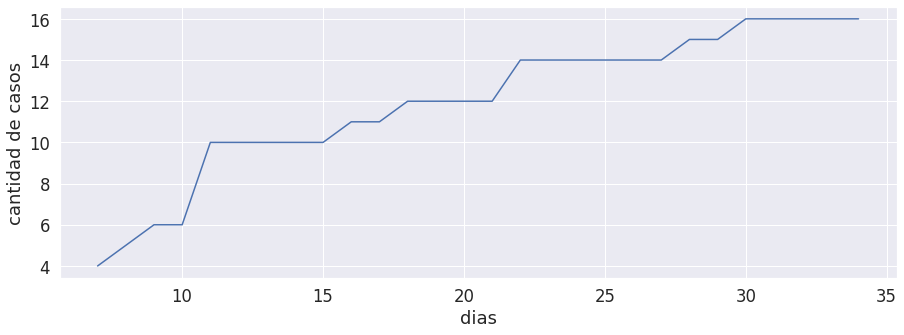

In [103]:
casos_principio=casos_mon[7:35]
dias_principio=dias[7:35]

plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Text(0, 0.5, 'log cantidad de casos')

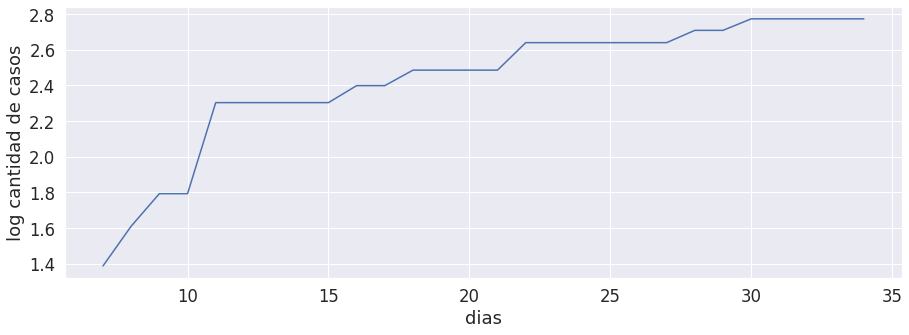

In [104]:
plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

In [105]:
#ajustamos
popt, pcov = curve_fit(exponencial, dias_principio, casos_principio)
popt # aca nos da el array de los parametros

array([ 3.14770594e-02, -5.74097687e+01])

Veamos cómo se ajusta lo que obtuvimos a los datos reales

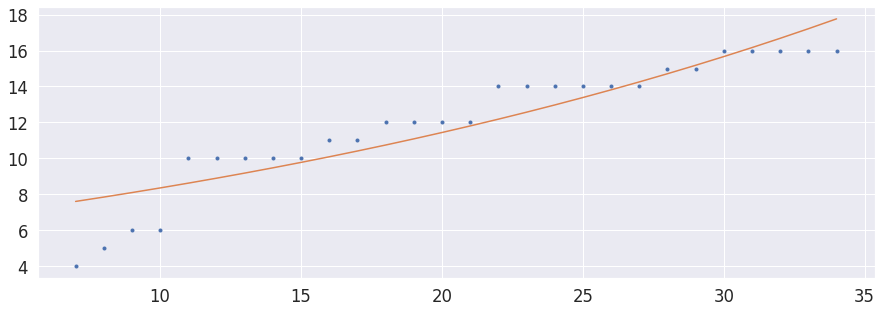

In [106]:
k=popt[0]
t0=popt[1]
casos_simu=exponencial(dias_principio,k,t0)
plt.plot(dias_principio,casos_principio,'.')
plt.plot(dias_principio,casos_simu)

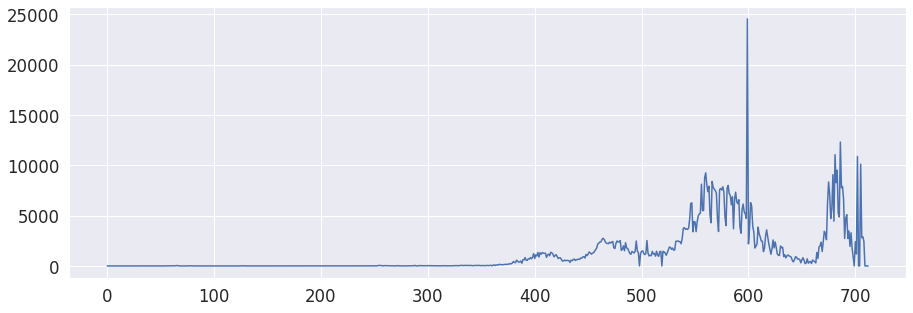

In [107]:
casos_mon=np.array(casos_mon)
nuevos_mon=casos_nuevos(casos_mon)
plt.plot(nuevos_mon)

In [108]:
rmse_mon = mean_squared_error(casos_principio, casos_simu)
print(np.format_float_scientific(rmse_mon))

1.8305703341851385e+00


In [109]:
t0_mon = dias_principio[0]
t_mon = dias_principio[-1]
k_mon = k
rmse_mon = rmse_mon

dic_mon = {"Pais": "Mongolia", "t0":[t0_mon], "t":[t_mon], "k": [k_mon], "rmse":[rmse_mon]}
datos_mon = pd.DataFrame(data=dic_mon)
datos_mon

Pais  t0   t         k     rmse
0  Mongolia   7  34  0.031477  1.83057

**Pais 3: Iran**

Text(0, 0.5, 'cantidad de casos')

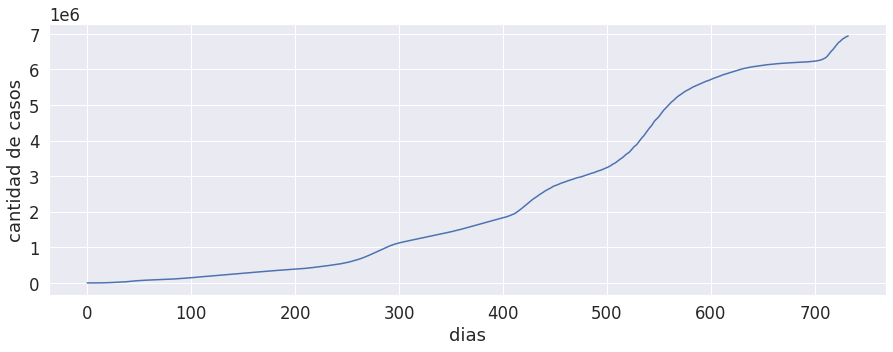

In [119]:
ind_ira=np.where(paises=='Iran')
ind_ira=ind_ira[0]
casos_ira=confirmados[ind_ira]
dias=np.arange(0,len(casos_ira))
plt.plot(dias,casos_ira)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Esta es la curva de **casos totales** de Iran. Aquí no se ven las olas, ya que estas se ven en la curva de casos confirmados por día, es decir, de casos nuevos. Esta habla de los acumulados, entonces siempre se agregan.

Para ver mejor la curva, tomamos el logartimo de los datos. Una curva exponencial se ve lineal en escala logarítmica.


Text(0, 0.5, 'log cantidad de casos')

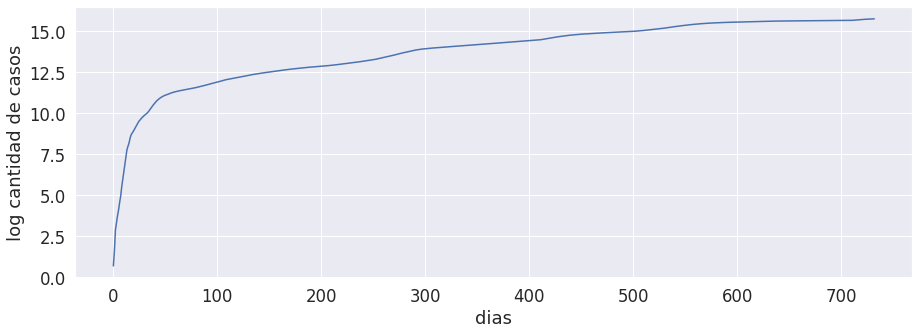

In [120]:
plt.plot(dias,np.log(casos_ira))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

Text(0, 0.5, 'cantidad de casos')

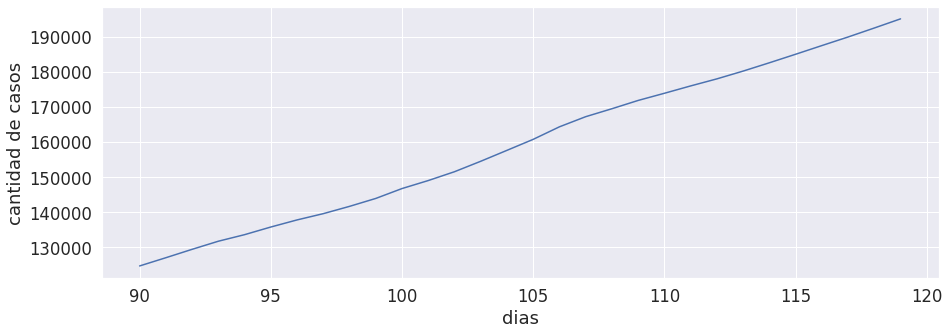

In [121]:
# veamos los primeros días desde que se detectó el 1er caso, para ver cómo fue el k inicial
casos_principio=casos_ira[90:120]
dias_principio=dias[90:120]

plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Text(0, 0.5, 'log cantidad de casos')

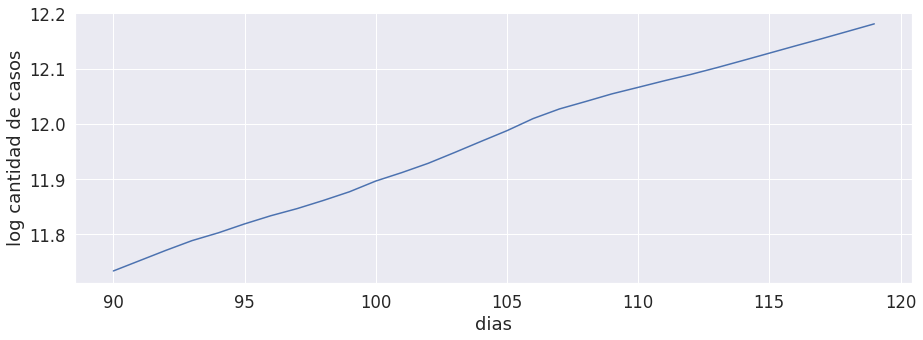

In [122]:
# como es difícil determinar si esta parte es exponencial. Analicemos qué pasa en escala logarítmica.
plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

In [123]:
#ajustamos
popt, pcov = curve_fit(exponencial, dias_principio, casos_principio)
popt # aca nos da el array de los parametros

array([ 1.55111505e-02, -6.67150380e+02])

Veamos cómo se ajusta lo que obtuvimos a los datos reales

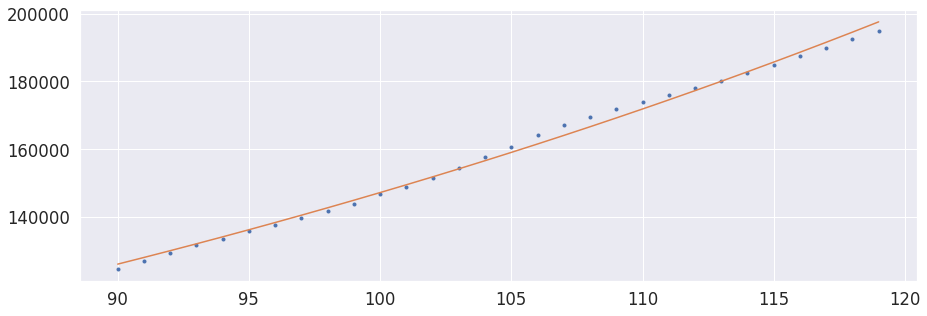

In [124]:
k=popt[0]
t0=popt[1]
casos_simu=exponencial(dias_principio,k,t0)
plt.plot(dias_principio,casos_principio,'.')
plt.plot(dias_principio,casos_simu)

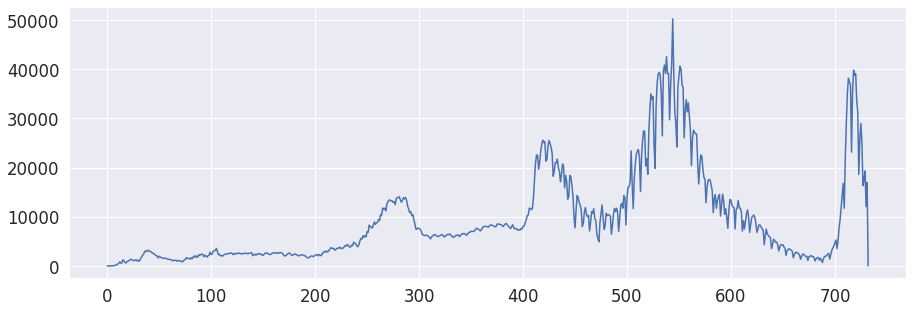

In [125]:
casos_ira=np.array(casos_ira)
nuevos_ira=casos_nuevos(casos_ira)
plt.plot(nuevos_ira)

In [126]:
rmse_ira = mean_squared_error(casos_principio, casos_simu)
print(np.format_float_scientific(rmse_ira))

2.208824115312771e+06


In [127]:
t0_ira = dias_principio[0]
t_ira = dias_principio[-1]
k_ira = k
rmse_ira = rmse_ira

dic_ira = {"Pais": "Iran", "t0":[t0_ira], "t":[t_ira], "k": [k_ira], "rmse":[rmse_ira]}
datos_ira = pd.DataFrame(data=dic_ira)
datos_ira

Pais  t0    t         k          rmse
0  Iran  90  119  0.015511  2.208824e+06

**Pais 4: Arabia Saudita**

Text(0, 0.5, 'cantidad de casos')

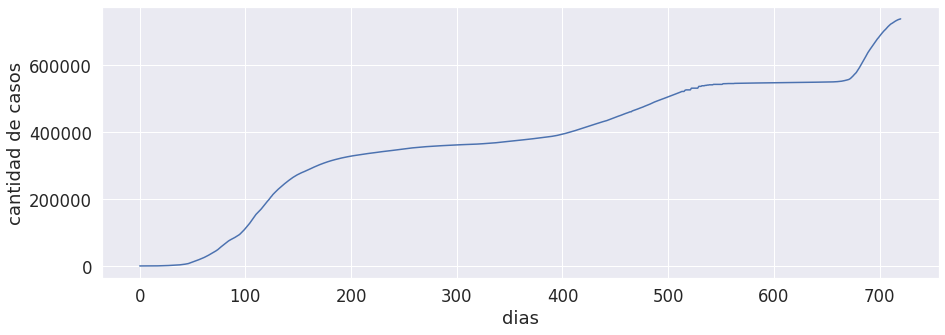

In [128]:
ind_asau=np.where(paises=='Saudi Arabia')
ind_asau=ind_asau[0]
casos_asau=confirmados[ind_asau]
dias=np.arange(0,len(casos_asau))
plt.plot(dias,casos_asau)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Esta es la curva de **casos totales** de Arabia Saudita. Aquí no se ven las olas, ya que estas se ven en la curva de casos confirmados por día, es decir, de casos nuevos. Esta habla de los acumulados, entonces siempre se agregan.

Para ver mejor la curva, tomamos el logartimo de los datos. Una curva exponencial se ve lineal en escala logarítmica


Text(0, 0.5, 'log cantidad de casos')

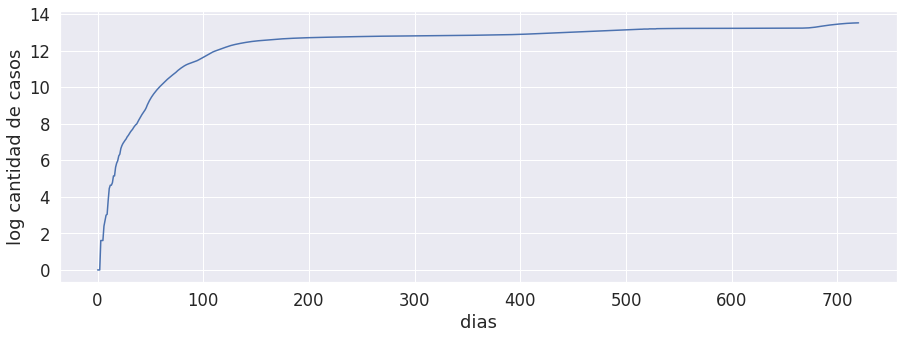

In [129]:
plt.plot(dias,np.log(casos_asau))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

Text(0, 0.5, 'cantidad de casos')

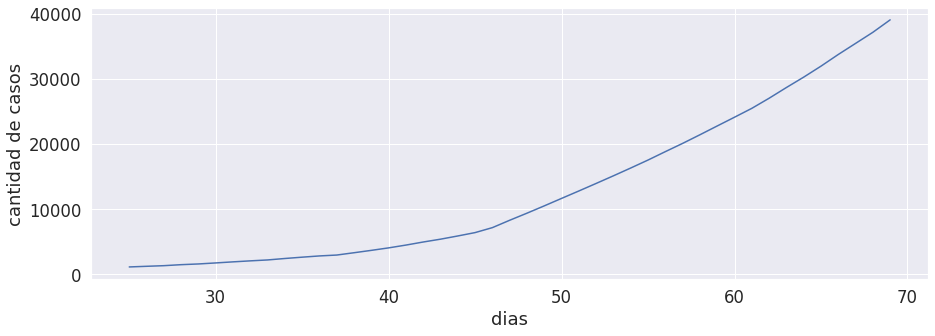

In [131]:
# veamos los primeros días desde que se detectó el 1er caso, para ver cómo fue el k inicial
casos_principio=casos_asau[25:70]
dias_principio=dias[25:70]

plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Text(0, 0.5, 'log cantidad de casos')

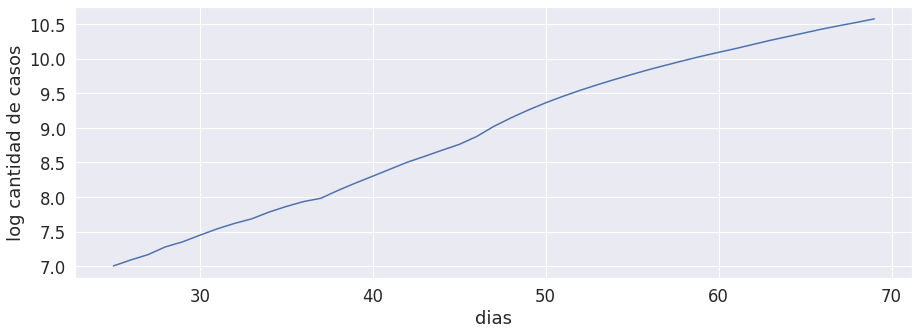

In [132]:
# como es difícil determinar si esta parte es exponencial. Analicemos qué pasa en escala logarítmica.
plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

In [133]:
#ajustamos
popt, pcov = curve_fit(exponencial, dias_principio, casos_principio, maxfev=100000)
popt # aca nos da el array de los parametros

array([ 6.99241540e-02, -8.32543744e+01])

Veamos cómo se ajusta lo que obtuvimos a los datos reales

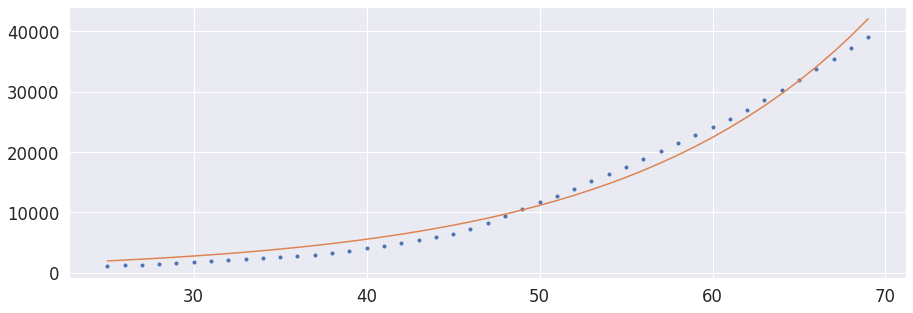

In [134]:
k=popt[0]
t0=popt[1]
casos_simu=exponencial(dias_principio,k,t0)
plt.plot(dias_principio,casos_principio,'.')
plt.plot(dias_principio,casos_simu)

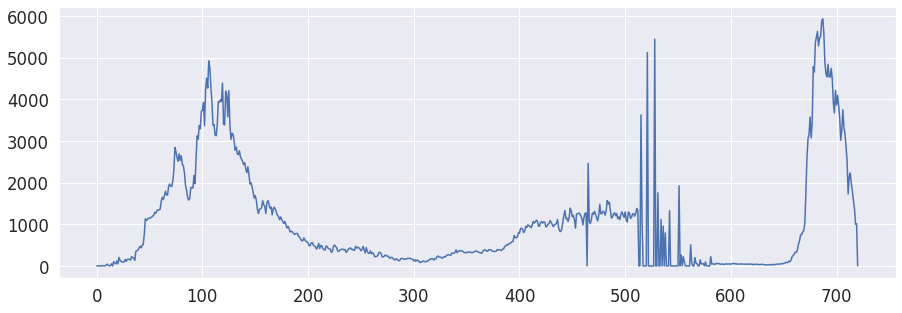

In [135]:
casos_asau=np.array(casos_asau)
nuevos_asau=casos_nuevos(casos_asau)
plt.plot(nuevos_asau)

In [136]:
rmse_asau = mean_squared_error(casos_principio, casos_simu)
print(np.format_float_scientific(rmse_asau))

1.8398281613175345e+06


In [137]:
t0_asau = dias_principio[0]
t_asau = dias_principio[-1]
k_asau = k
rmse_asau = rmse_asau

dic_asau = {"Pais": "Arabia Saudita", "t0":[t0_asau], "t":[t_asau], "k": [k_asau], "rmse":[rmse_asau]}
datos_asau = pd.DataFrame(data=dic_asau)
datos_asau

Pais  t0   t         k          rmse
0  Arabia Saudita  25  69  0.069924  1.839828e+06

**Pais 5: Turquia**

Text(0, 0.5, 'cantidad de casos')

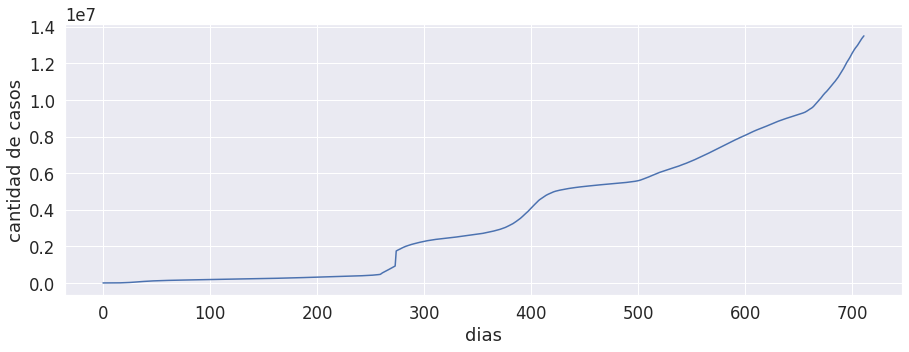

In [138]:
ind_tur=np.where(paises=='Turkey')
ind_tur=ind_tur[0]
casos_tur=confirmados[ind_tur]
dias=np.arange(0,len(casos_tur))
plt.plot(dias,casos_tur)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Esta es la curva de **casos totales** de Turquia. Aquí no se ven las olas, ya que estas se ven en la curva de casos confirmados por día, es decir, de casos nuevos. Esta habla de los acumulados, entonces siempre se agregan.

Para ver mejor la curva, tomamos el logartimo de los datos. Una curva exponencial se ve lineal en escala logarítmica


Text(0, 0.5, 'log cantidad de casos')

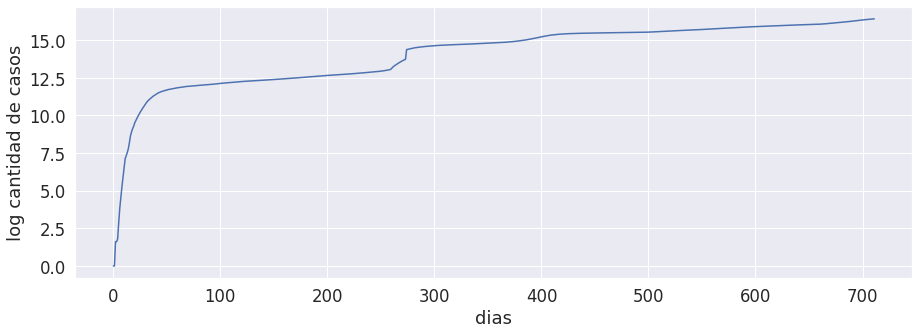

In [139]:
plt.plot(dias,np.log(casos_tur))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

Text(0, 0.5, 'cantidad de casos')

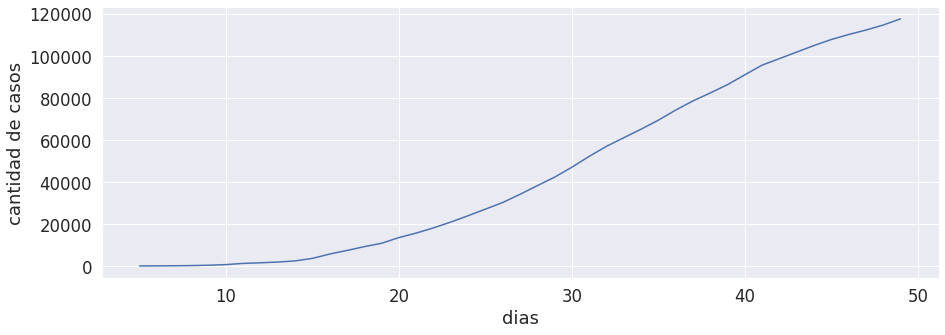

In [140]:
# veamos los primeros días desde que se detectó el 1er caso, para ver cómo fue el k inicial
casos_principio=casos_tur[5:50]
dias_principio=dias[5:50]

plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Text(0, 0.5, 'log cantidad de casos')

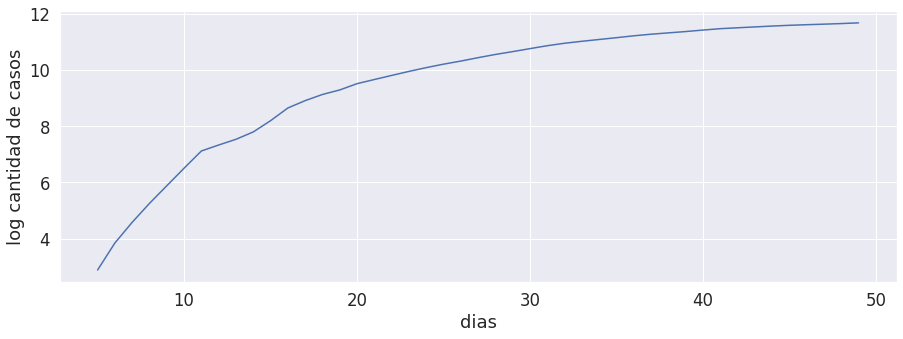

In [141]:
# como es difícil determinar si esta parte es exponencial. Analicemos qué pasa en escala logarítmica.
plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

In [142]:
#ajustamos
popt, pcov = curve_fit(exponencial, dias_principio, casos_principio, maxfev=100000)
popt # aca nos da el array de los parametros

array([ 6.32197531e-02, -1.38325189e+02])

Veamos cómo se ajusta lo que obtuvimos a los datos reales

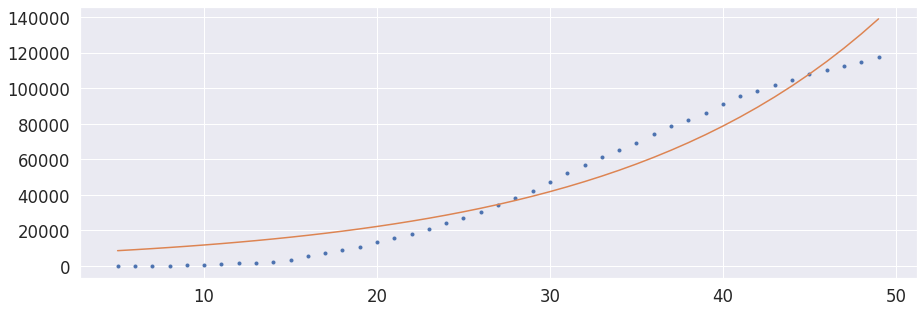

In [143]:
k=popt[0]
t0=popt[1]
casos_simu=exponencial(dias_principio,k,t0)
plt.plot(dias_principio,casos_principio,'.')
plt.plot(dias_principio,casos_simu)

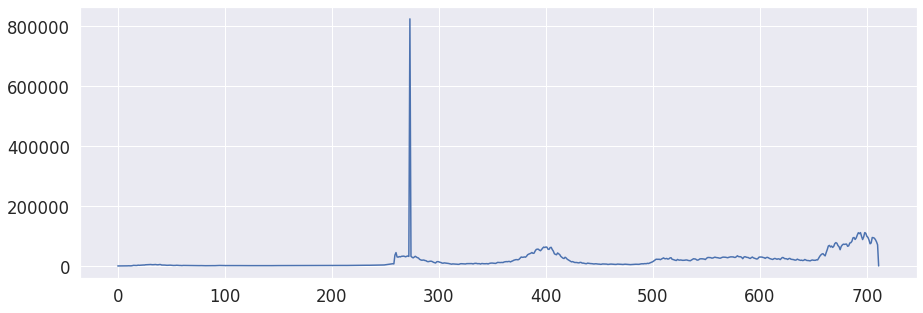

In [144]:
casos_tur=np.array(casos_tur)
nuevos_tur=casos_nuevos(casos_tur)
plt.plot(nuevos_tur)

In [145]:
rmse_tur = mean_squared_error(casos_principio, casos_simu)
print(np.format_float_scientific(rmse_tur))

1.018008335275364e+08


In [146]:
t0_tur = dias_principio[0]
t_tur = dias_principio[-1]
k_tur = k
rmse_tur = rmse_tur

dic_tur = {"Pais": "Turquia", "t0":[t0_tur], "t":[t_tur], "k": [k_tur], "rmse":[rmse_tur]}
datos_tur = pd.DataFrame(data=dic_tur)
datos_tur

Pais  t0   t        k          rmse
0  Turquia   5  49  0.06322  1.018008e+08

**Pais 6: Afganistan**

Text(0, 0.5, 'cantidad de casos')

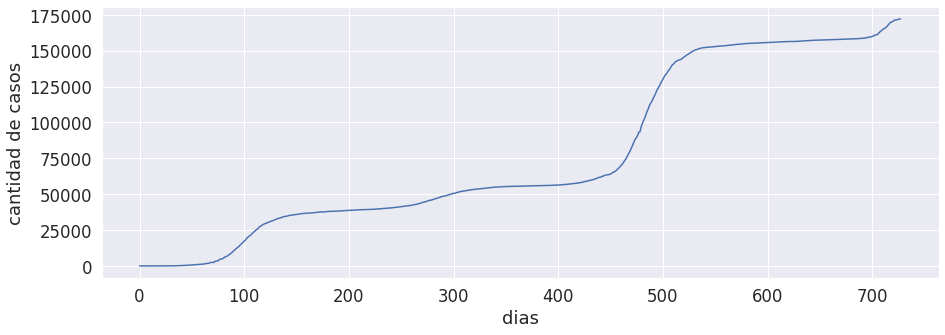

In [147]:
ind_afga=np.where(paises=='Afghanistan')
ind_afga=ind_afga[0]
casos_afga=confirmados[ind_afga]
dias=np.arange(0,len(casos_afga))
plt.plot(dias,casos_afga)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Esta es la curva de **casos totales** de Afganistan. Aquí no se ven las olas, ya que estas se ven en la curva de casos confirmados por día, es decir, de casos nuevos. Esta habla de los acumulados, entonces siempre se agregan.

Para ver mejor la curva, tomamos el logartimo de los datos. Una curva exponencial se ve lineal en escala logarítmica


Text(0, 0.5, 'log cantidad de casos')

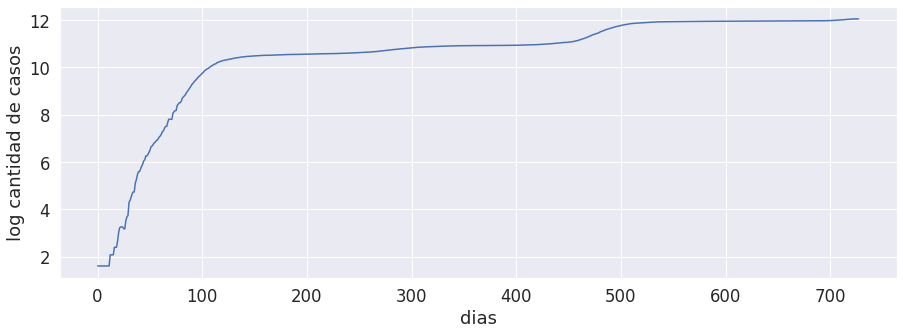

In [148]:
plt.plot(dias,np.log(casos_afga))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

Text(0, 0.5, 'cantidad de casos')

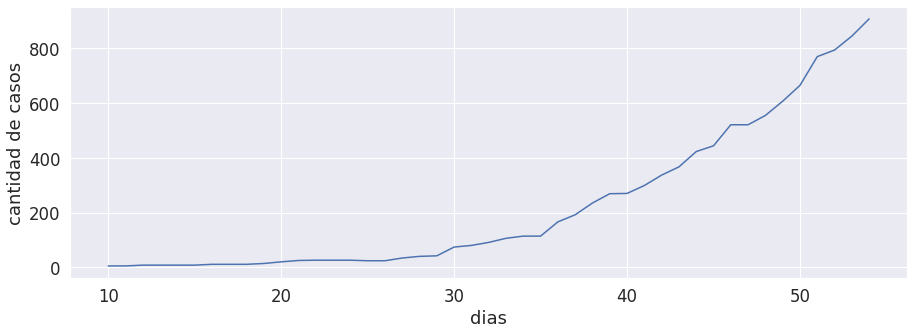

In [150]:
# veamos los primeros días desde que se detectó el 1er caso, para ver cómo fue el k inicial
casos_principio=casos_afga[10:55]
dias_principio=dias[10:55]

plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Text(0, 0.5, 'log cantidad de casos')

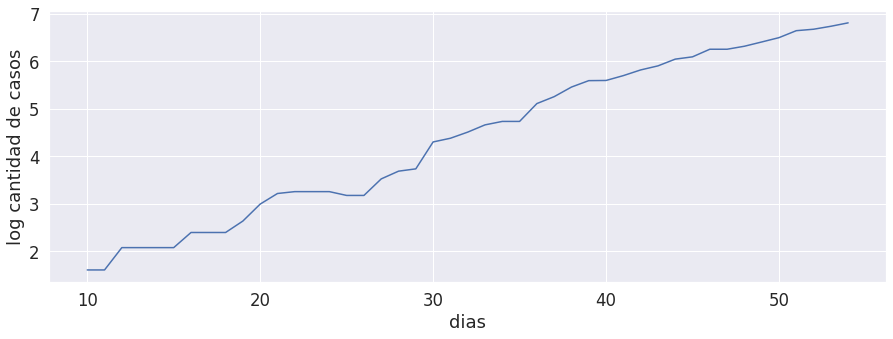

In [151]:
# como es difícil determinar si esta parte es exponencial. Analicemos qué pasa en escala logarítmica.
plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

In [152]:
#ajustamos
popt, pcov = curve_fit(exponencial, dias_principio, casos_principio, maxfev=100000)
popt # aca nos da el array de los parametros

array([  0.09536148, -18.13003   ])

Veamos cómo se ajusta lo que obtuvimos a los datos reales

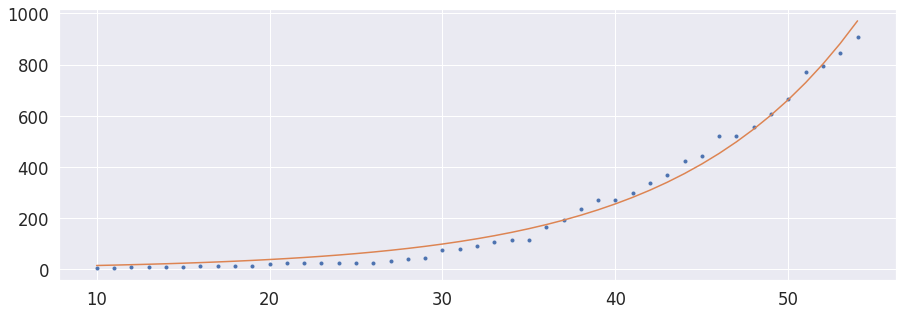

In [153]:
k=popt[0]
t0=popt[1]
casos_simu=exponencial(dias_principio,k,t0)
plt.plot(dias_principio,casos_principio,'.')
plt.plot(dias_principio,casos_simu)

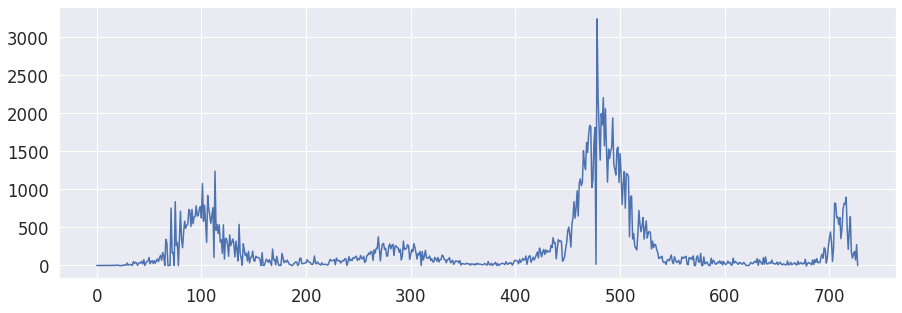

In [154]:
casos_afga=np.array(casos_afga)
nuevos_afga=casos_nuevos(casos_afga)
plt.plot(nuevos_afga)

In [156]:
rmse_afga = mean_squared_error(casos_principio, casos_simu)
print(np.format_float_scientific(rmse_afga))

8.674719606113197e+02


In [157]:
t0_afga = dias_principio[0]
t_afga = dias_principio[-1]
k_afga = k
rmse_afga = rmse_afga

dic_afga = {"Pais": "Afganistan", "t0":[t0_afga], "t":[t_afga], "k": [k_afga], "rmse":[rmse_afga]}
datos_afga = pd.DataFrame(data=dic_afga)
datos_afga

Pais  t0   t         k        rmse
0  Afganistan  10  54  0.095361  867.471961

**Pais 7: Japon**

Text(0, 0.5, 'cantidad de casos')

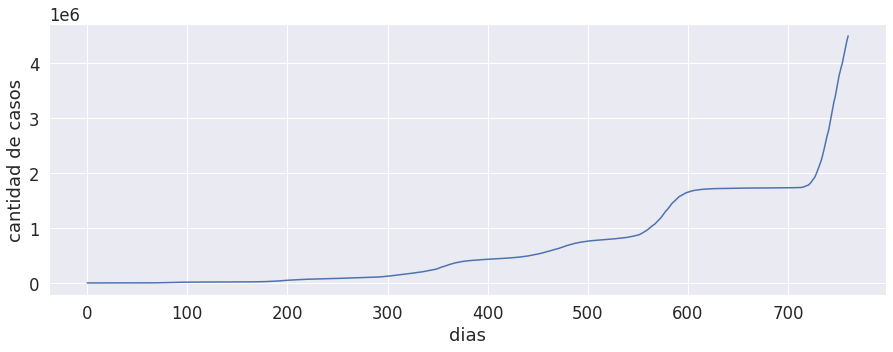

In [158]:
ind_jap=np.where(paises=='Japan')
ind_jap=ind_jap[0]
casos_jap=confirmados[ind_jap]
dias=np.arange(0,len(casos_jap))
plt.plot(dias,casos_jap)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Esta es la curva de **casos totales** de Japon. Aquí no se ven las olas, ya que estas se ven en la curva de casos confirmados por día, es decir, de casos nuevos. Esta habla de los acumulados, entonces siempre se agregan.

Para ver mejor la curva, tomamos el logartimo de los datos. Una curva exponencial se ve lineal en escala logarítmica


Text(0, 0.5, 'log cantidad de casos')

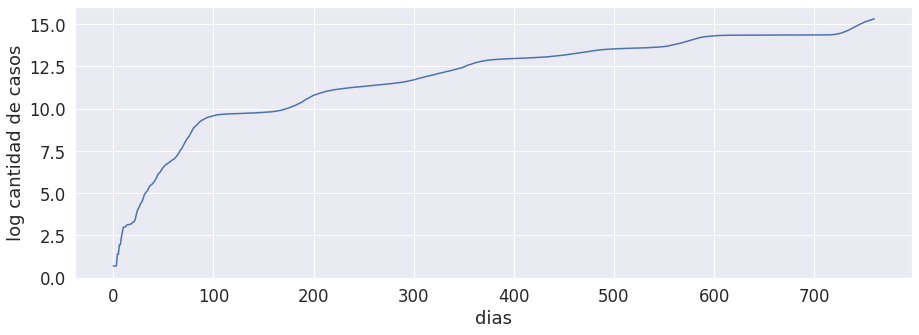

In [159]:
plt.plot(dias,np.log(casos_jap))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

Text(0, 0.5, 'cantidad de casos')

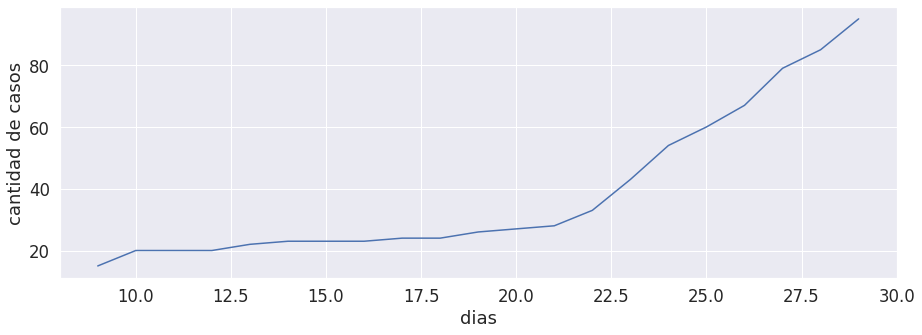

In [160]:
# veamos los primeros días desde que se detectó el 1er caso, para ver cómo fue el k inicial
casos_principio=casos_jap[9:30]
dias_principio=dias[9:30]

plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Text(0, 0.5, 'log cantidad de casos')

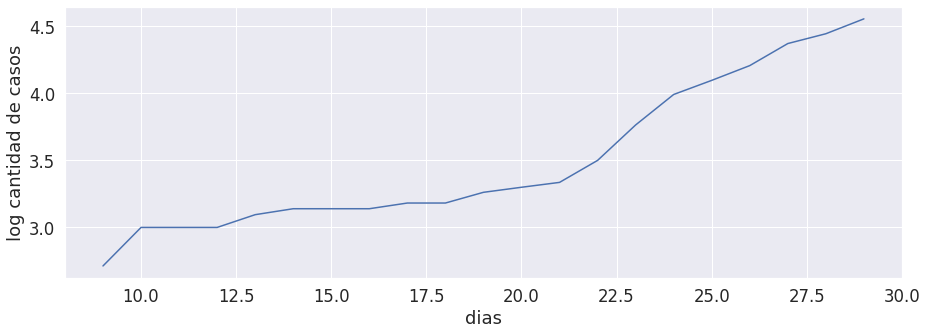

In [161]:
# como es difícil determinar si esta parte es exponencial. Analicemos qué pasa en escala logarítmica.
plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

In [162]:
#ajustamos
popt, pcov = curve_fit(exponencial, dias_principio, casos_principio, maxfev=100000)
popt # aca nos da el array de los parametros

array([  0.11146957, -11.63962691])

Veamos cómo se ajusta lo que obtuvimos a los datos reales

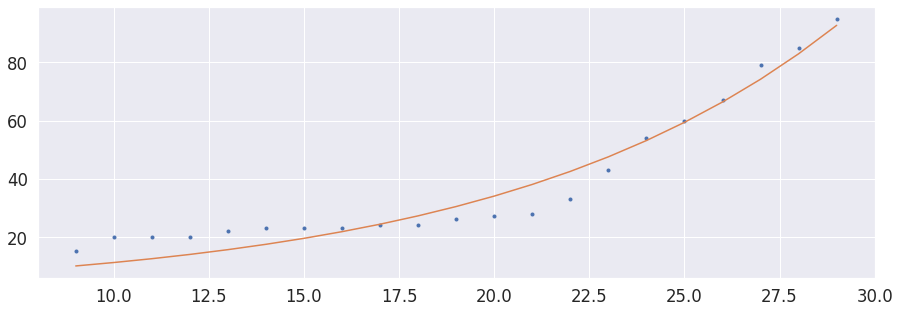

In [163]:
k=popt[0]
t0=popt[1]
casos_simu=exponencial(dias_principio,k,t0)
plt.plot(dias_principio,casos_principio,'.')
plt.plot(dias_principio,casos_simu)

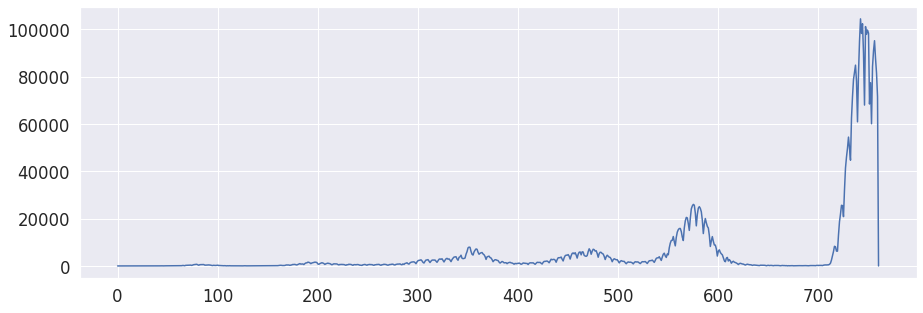

In [164]:
casos_jap=np.array(casos_jap)
nuevos_jap=casos_nuevos(casos_jap)
plt.plot(nuevos_jap)

In [165]:
rmse_jap = mean_squared_error(casos_principio, casos_simu)
print(np.format_float_scientific(rmse_jap))

2.889913920662305e+01


In [166]:
t0_jap = dias_principio[0]
t_jap = dias_principio[-1]
k_jap = k
rmse_jap = rmse_jap

dic_jap = {"Pais": "Japon", "t0":[t0_jap], "t":[t_jap], "k": [k_jap], "rmse":[rmse_jap]}
datos_jap = pd.DataFrame(data=dic_jap)
datos_jap

Pais  t0   t        k       rmse
0  Japon   9  29  0.11147  28.899139

**Pais 8: Tailandia**

Text(0, 0.5, 'cantidad de casos')

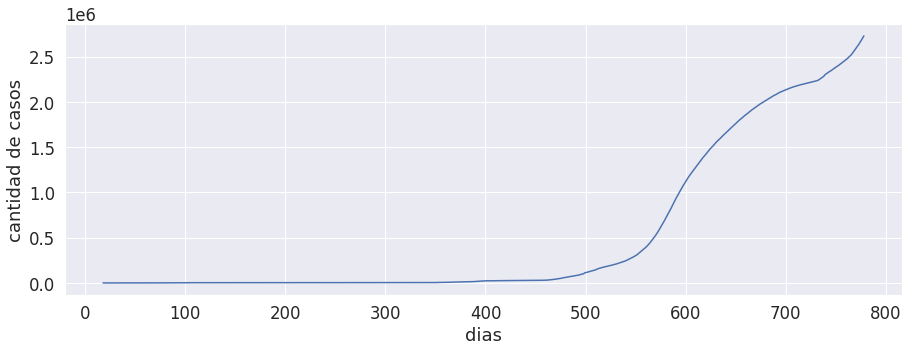

In [167]:
ind_tai=np.where(paises=='Thailand')
ind_tai=ind_tai[0]
casos_tai=confirmados[ind_tai]
dias=np.arange(0,len(casos_tai))
plt.plot(dias,casos_tai)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Esta es la curva de **casos totales** de Tailandia. Aquí no se ven las olas, ya que estas se ven en la curva de casos confirmados por día, es decir, de casos nuevos. Esta habla de los acumulados, entonces siempre se agregan.

Para ver mejor la curva, tomamos el logartimo de los datos. Una curva exponencial se ve lineal en escala logarítmica


Text(0, 0.5, 'log cantidad de casos')

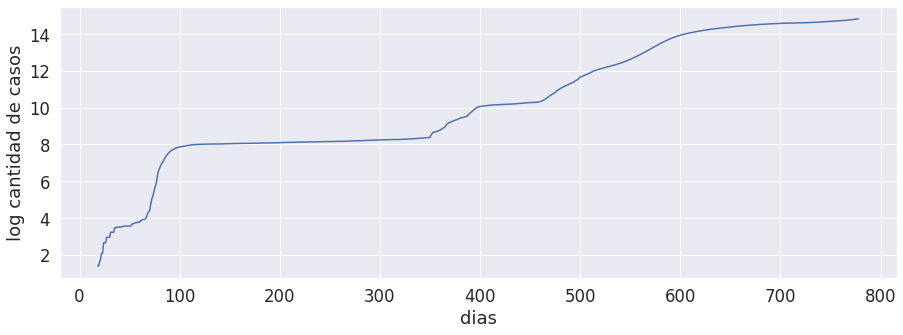

In [168]:
plt.plot(dias,np.log(casos_tai))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

Text(0, 0.5, 'cantidad de casos')

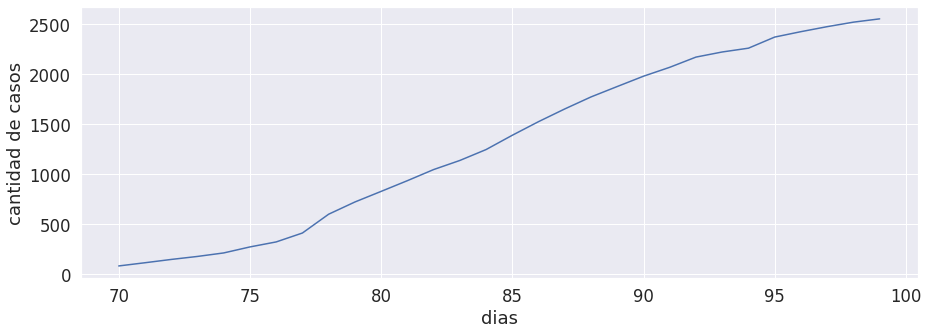

In [169]:
# veamos los primeros días desde que se detectó el 1er caso, para ver cómo fue el k inicial
casos_principio=casos_tai[70:100]
dias_principio=dias[70:100]

plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Text(0, 0.5, 'log cantidad de casos')

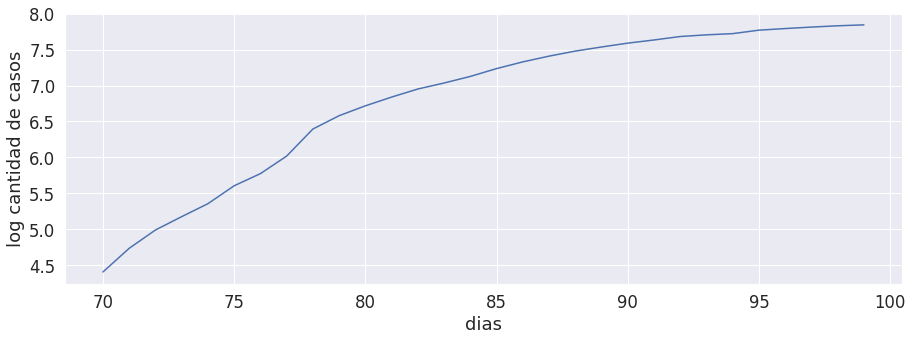

In [170]:
# como es difícil determinar si esta parte es exponencial. Analicemos qué pasa en escala logarítmica.
plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

In [171]:
#ajustamos
popt, pcov = curve_fit(exponencial, dias_principio, casos_principio, maxfev=100000)
popt # aca nos da el array de los parametros

array([  0.0666287, -21.2640982])

Veamos cómo se ajusta lo que obtuvimos a los datos reales

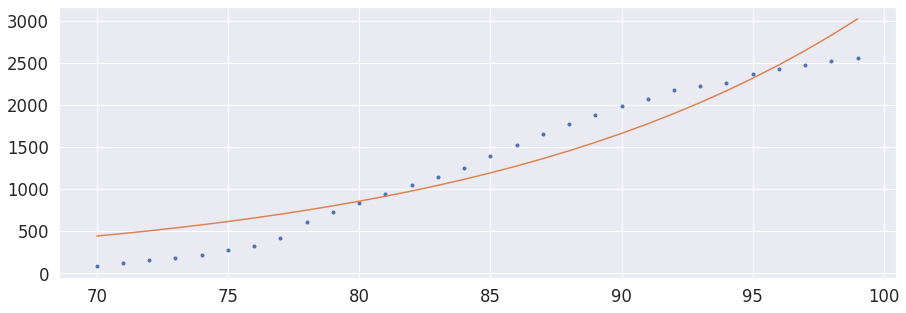

In [172]:
k=popt[0]
t0=popt[1]
casos_simu=exponencial(dias_principio,k,t0)
plt.plot(dias_principio,casos_principio,'.')
plt.plot(dias_principio,casos_simu)

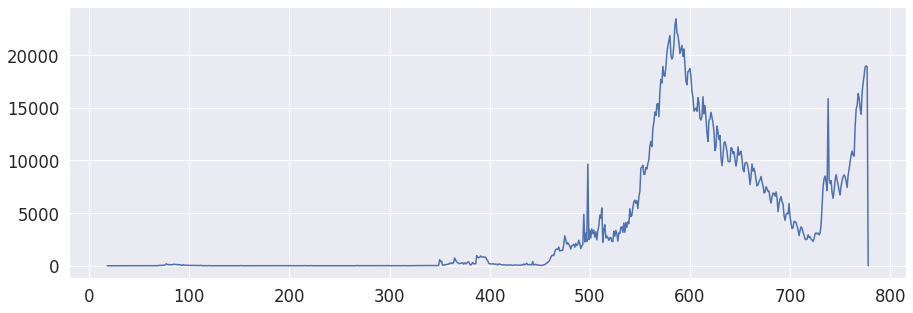

In [173]:
casos_tai=np.array(casos_tai)
nuevos_tai=casos_nuevos(casos_tai)
plt.plot(nuevos_tai)

In [174]:
rmse_tai = mean_squared_error(casos_principio, casos_simu)
print(np.format_float_scientific(rmse_tai))

6.854541117578153e+04


In [175]:
t0_tai = dias_principio[0]
t_tai = dias_principio[-1]
k_tai = k
rmse_tai = rmse_tai

dic_tai = {"Pais": "Tailandia", "t0":[t0_tai], "t":[t_tai], "k": [k_tai], "rmse":[rmse_tai]}
datos_tai = pd.DataFrame(data=dic_tai)
datos_tai

Pais  t0   t         k          rmse
0  Tailandia  70  99  0.066629  68545.411176

**Pais 9: Vietnam**

Text(0, 0.5, 'cantidad de casos')

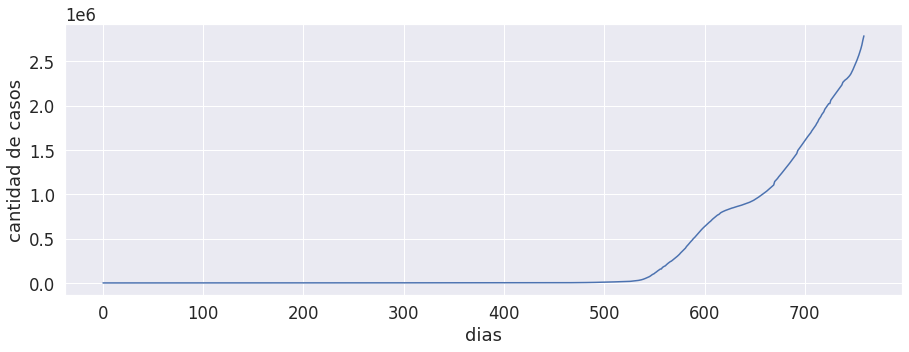

In [176]:
ind_viet=np.where(paises=='Vietnam')
ind_viet=ind_viet[0]
casos_viet=confirmados[ind_viet]
dias=np.arange(0,len(casos_viet))
plt.plot(dias,casos_viet)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Esta es la curva de **casos totales** de Vietnam. Aquí no se ven las olas, ya que estas se ven en la curva de casos confirmados por día, es decir, de casos nuevos. Esta habla de los acumulados, entonces siempre se agregan.

Para ver mejor la curva, tomamos el logartimo de los datos. Una curva exponencial se ve lineal en escala logarítmica


Text(0, 0.5, 'log cantidad de casos')

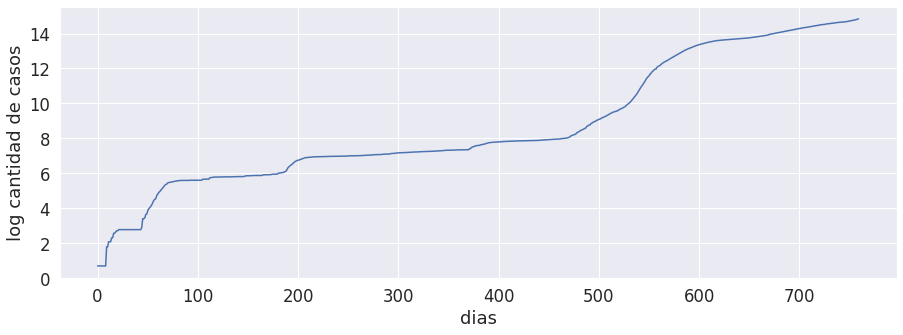

In [177]:
plt.plot(dias,np.log(casos_viet))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

Text(0, 0.5, 'cantidad de casos')

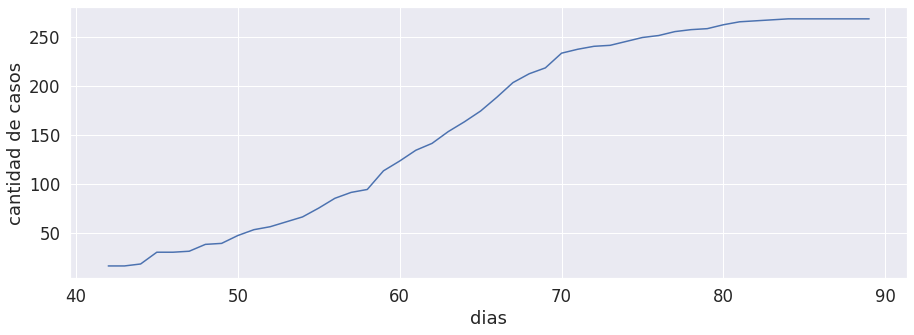

In [180]:
# veamos los primeros días desde que se detectó el 1er caso, para ver cómo fue el k inicial
casos_principio=casos_viet[42:90]
dias_principio=dias[42:90]

plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Text(0, 0.5, 'log cantidad de casos')

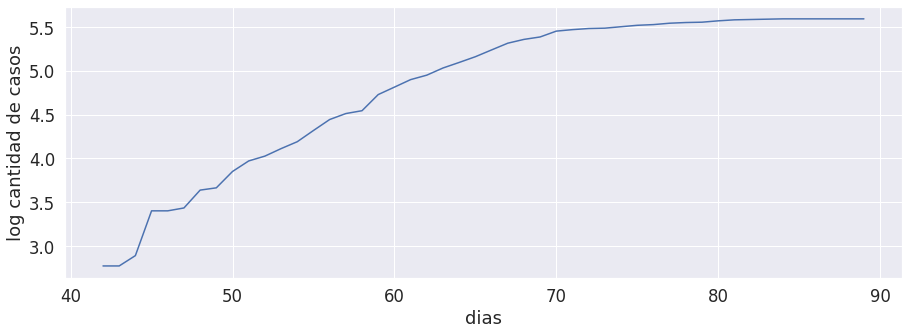

In [181]:
# como es difícil determinar si esta parte es exponencial. Analicemos qué pasa en escala logarítmica.
plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

In [182]:
#ajustamos
popt, pcov = curve_fit(exponencial, dias_principio, casos_principio, maxfev=100000)
popt # aca nos da el array de los parametros

array([ 3.49209812e-02, -7.76208624e+01])

Veamos cómo se ajusta lo que obtuvimos a los datos reales

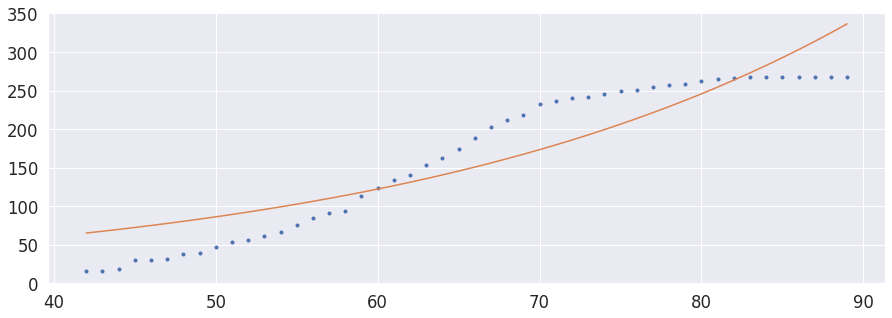

In [183]:
k=popt[0]
t0=popt[1]
casos_simu=exponencial(dias_principio,k,t0)
plt.plot(dias_principio,casos_principio,'.')
plt.plot(dias_principio,casos_simu)

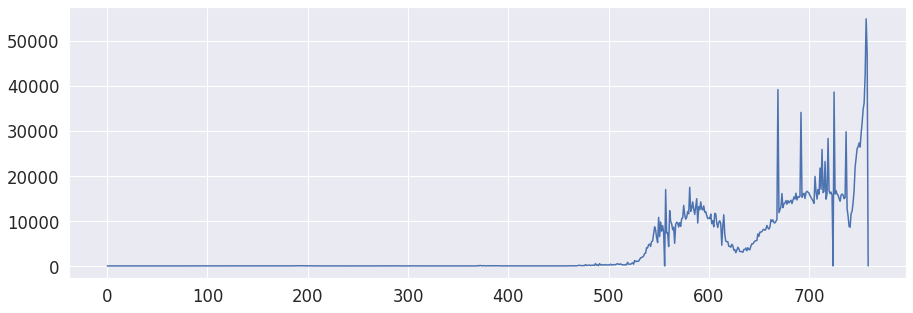

In [184]:
casos_viet=np.array(casos_viet)
nuevos_viet=casos_nuevos(casos_viet)
plt.plot(nuevos_viet)

In [185]:
rmse_viet = mean_squared_error(casos_principio, casos_simu)
print(np.format_float_scientific(rmse_viet))

1.432334866207436e+03


In [186]:
t0_viet = dias_principio[0]
t_viet = dias_principio[-1]
k_viet = k
rmse_viet = rmse_viet

dic_viet = {"Pais": "Vietman", "t0":[t0_viet], "t":[t_viet], "k": [k_viet], "rmse":[rmse_viet]}
datos_viet = pd.DataFrame(data=dic_viet)
datos_viet

Pais  t0   t         k         rmse
0  Vietman  42  89  0.034921  1432.334866

**Pais 10: Pakistan**

Text(0, 0.5, 'cantidad de casos')

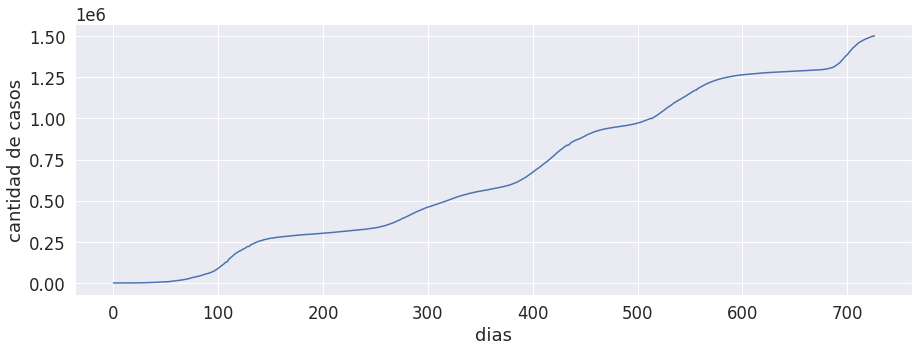

In [187]:
ind_pak=np.where(paises=='Pakistan')
ind_pak=ind_pak[0]
casos_pak=confirmados[ind_pak]
dias=np.arange(0,len(casos_pak))
plt.plot(dias,casos_pak)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Esta es la curva de **casos totales** de Pakistan. Aquí no se ven las olas, ya que estas se ven en la curva de casos confirmados por día, es decir, de casos nuevos. Esta habla de los acumulados, entonces siempre se agregan.

Para ver mejor la curva, tomamos el logartimo de los datos. Una curva exponencial se ve lineal en escala logarítmica


Text(0, 0.5, 'log cantidad de casos')

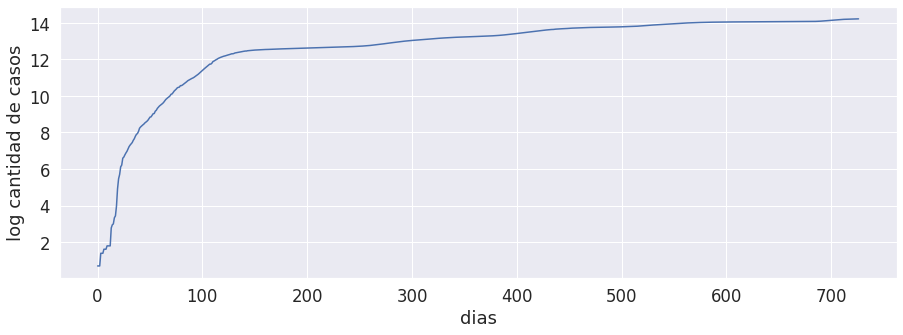

In [188]:
plt.plot(dias,np.log(casos_pak))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

Text(0, 0.5, 'cantidad de casos')

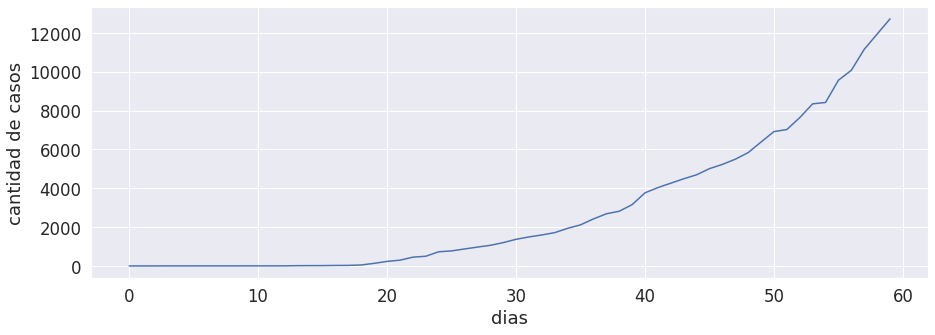

In [192]:
# veamos los primeros días desde que se detectó el 1er caso, para ver cómo fue el k inicial
casos_principio=casos_pak[0:60]
dias_principio=dias[0:60]

plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Text(0, 0.5, 'log cantidad de casos')

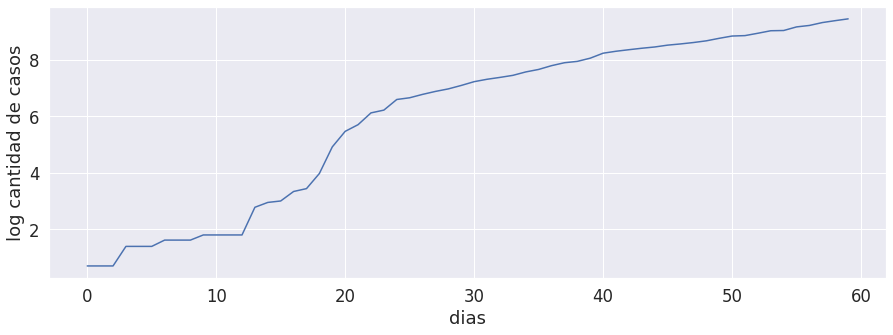

In [193]:
# como es difícil determinar si esta parte es exponencial. Analicemos qué pasa en escala logarítmica.
plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

Mejor nos quedamos con lo que sucede entre los días 2 y 30, ya que ese fue el comportamiento más sostenido.

Text(0, 0.5, 'cantidad de casos')

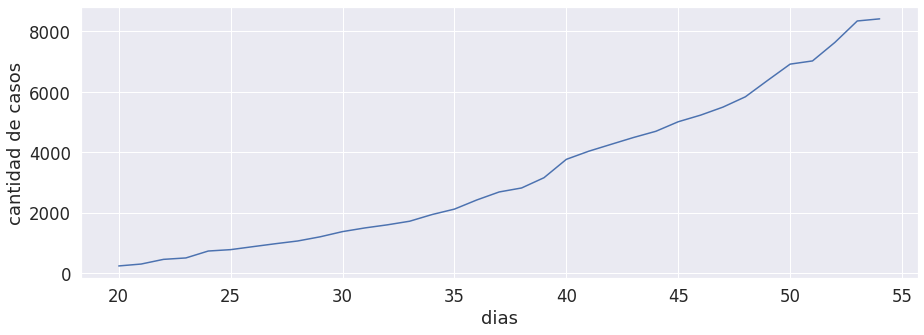

In [194]:
casos_principio=casos_pak[20:55]
dias_principio=dias[20:55]

plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Text(0, 0.5, 'log cantidad de casos')

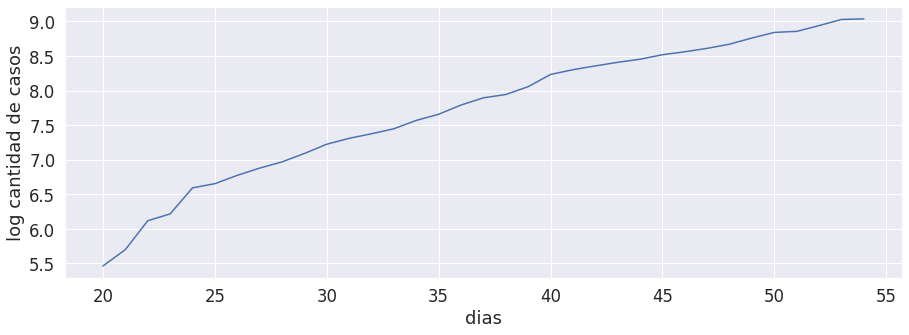

In [195]:
plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

In [196]:
#ajustamos
popt, pcov = curve_fit(exponencial, dias_principio, casos_principio, maxfev=100000)
popt # aca nos da el array de los parametros

array([  0.07343415, -70.06130942])

Veamos cómo se ajusta lo que obtuvimos a los datos reales

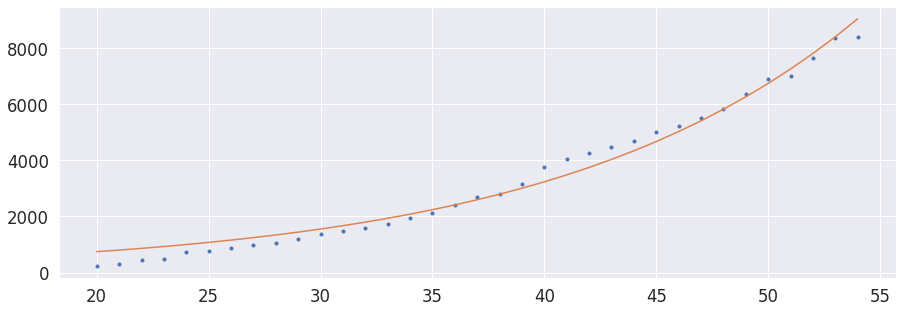

In [197]:
k=popt[0]
t0=popt[1]
casos_simu=exponencial(dias_principio,k,t0)
plt.plot(dias_principio,casos_principio,'.')
plt.plot(dias_principio,casos_simu)

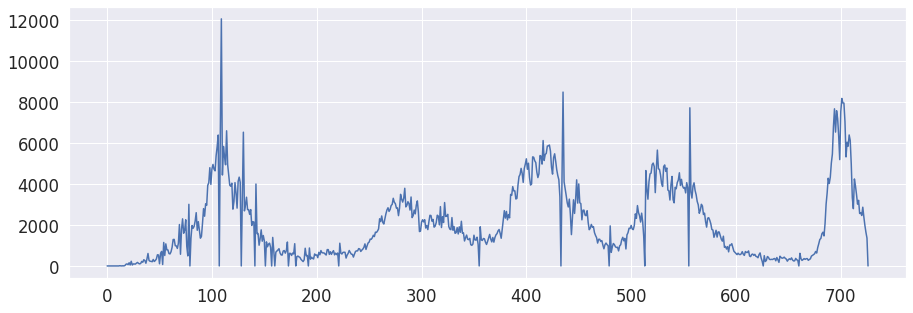

In [198]:
casos_pak=np.array(casos_pak)
nuevos_pak=casos_nuevos(casos_pak)
plt.plot(nuevos_pak)

In [199]:
rmse_pak = mean_squared_error(casos_principio, casos_simu)
print(np.format_float_scientific(rmse_pak))

9.738663300352143e+04


In [200]:
t0_pak = dias_principio[0]
t_pak = dias_principio[-1]
k_pak = k
rmse_pak = rmse_pak

dic_pak = {"Pais": "Pakistan", "t0":[t0_pak], "t":[t_pak], "k": [k_pak], "rmse":[rmse_pak]}
datos_pak = pd.DataFrame(data=dic_pak)
datos_pak

Pais  t0   t         k          rmse
0  Pakistan  20  54  0.073434  97386.633004

Analizamos ahora qué pasó en el mundo.

**Datos Mundiales**

Text(0, 0.5, 'cantidad de casos')

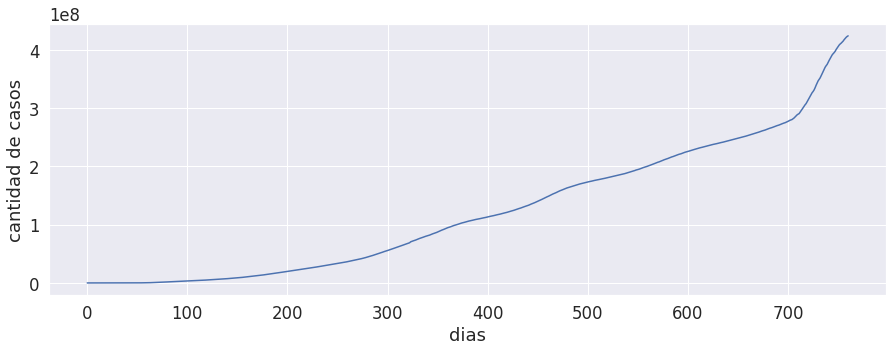

In [230]:
ind_wor=np.where(paises=='World')
ind_wor=ind_wor[0]
casos_wor=confirmados[ind_wor]
dias=np.arange(0,len(casos_wor))
plt.plot(dias,casos_wor)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Esta es la curva de **casos totales** mundial. Aquí no se ven las olas, ya que estas se ven en la curva de casos confirmados por día, es decir, de casos nuevos. Esta habla de los acumulados, entonces siempre se agregan.

Para ver mejor la curva, tomamos el logartimo de los datos. Una curva exponencial se ve lineal en escala logarítmica


Text(0, 0.5, 'log cantidad de casos')

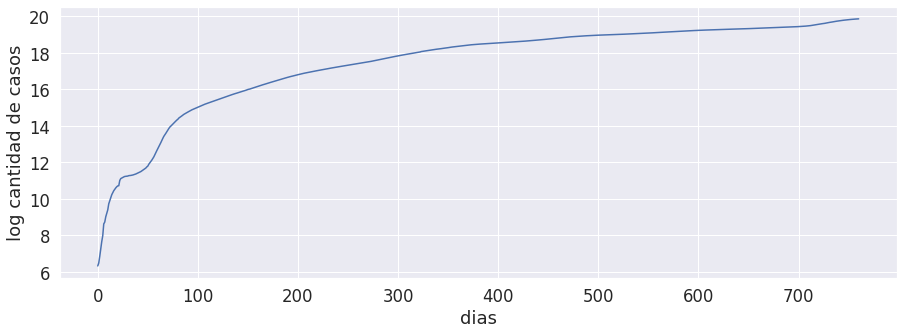

In [231]:
plt.plot(dias,np.log(casos_wor))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

Text(0, 0.5, 'cantidad de casos')

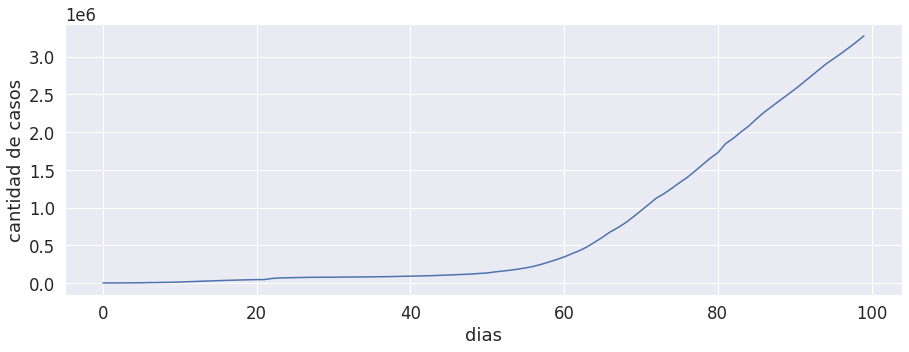

In [232]:
# veamos los primeros 100 días desde que se detectó el 1er caso, para ver cómo fue el k inicial
casos_principio=casos_wor[0:100]
dias_principio=dias[0:100]

plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Text(0, 0.5, 'log cantidad de casos')

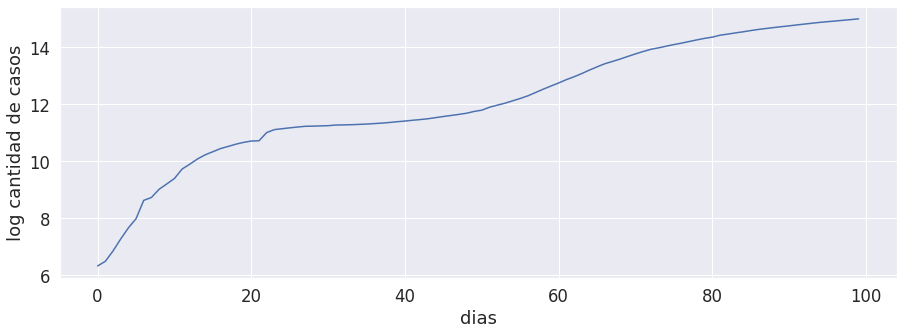

In [233]:
# como es difícil determinar si esta parte es exponencial. Analicemos qué pasa en escala logarítmica.
plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

Mejor nos quedamos con lo que sucede entre los días 2 y 30, ya que ese fue el comportamiento más sostenido.

Text(0, 0.5, 'cantidad de casos')

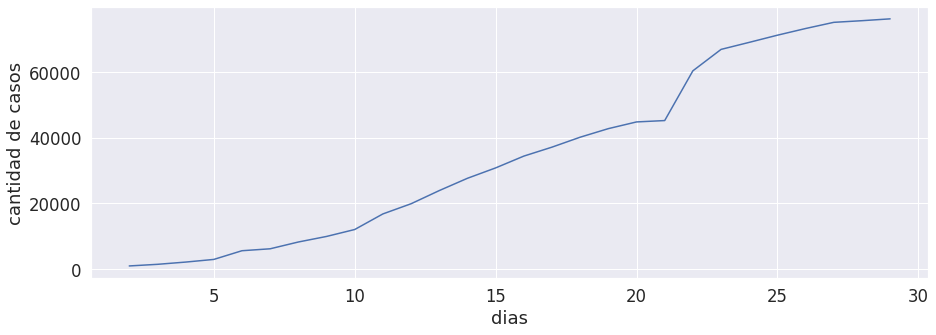

In [234]:
casos_principio=casos_wor[2:30]
dias_principio=dias[2:30]

plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Text(0, 0.5, 'log cantidad de casos')

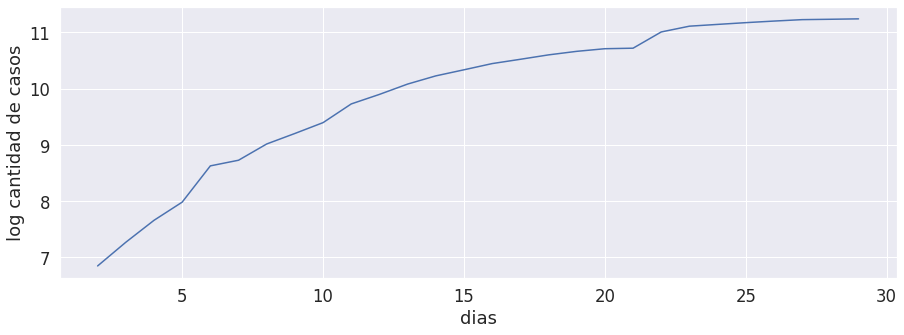

In [235]:
plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

In [236]:
#ajustamos
popt, pcov = curve_fit(exponencial, dias_principio, casos_principio, maxfev=100000)
popt # aca nos da el array de los parametros

array([ 8.54955239e-02, -1.04597677e+02])

Veamos cómo se ajusta lo que obtuvimos a los datos reales

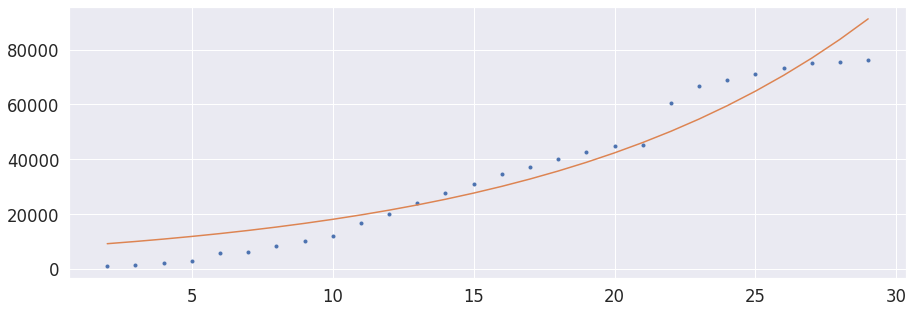

In [237]:
k=popt[0]
t0=popt[1]
casos_simu=exponencial(dias_principio,k,t0)
plt.plot(dias_principio,casos_principio,'.')
plt.plot(dias_principio,casos_simu)

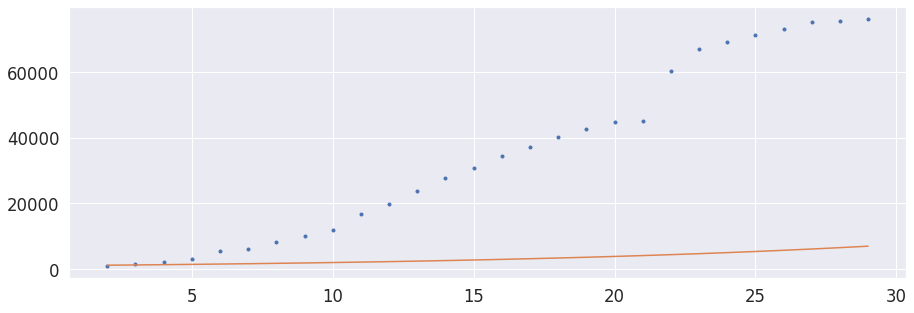

In [238]:
casos_simu=exponencial(dias_principio,k_final,t0)
plt.plot(dias_principio,casos_principio,'.')
plt.plot(dias_principio,casos_simu)

In [239]:
rmse_wor = mean_squared_error(casos_principio, casos_simu)
print(np.format_float_scientific(rmse_wor))

1.6220317066260998e+09


In [240]:
t0_wor = dias_principio[0]
t_wor = dias_principio[-1]
k_wor = k
rmse_wor = rmse_wor

dic_wor = {"Pais": "Mundo", "t0":[t0_wor], "t":[t_wor], "k": [k_wor], "rmse":[rmse_wor]}
datos_wor = pd.DataFrame(data=dic_wor)
datos_wor

Pais  t0   t         k          rmse
0  Mundo   2  29  0.085496  1.622032e+09

In [ ]:
k_final

0.06419472627328333

Hacemos una tabla resumen con los resultados de los 10 paises elegidos mas los datos del mundo.

In [241]:
resultado_paises = pd.concat([datos_chi, datos_mon, datos_ira, datos_asau, datos_tur, datos_afga, datos_jap, datos_tai, datos_viet, datos_pak, datos_wor],
                       ignore_index=True)
resultado_paises

Pais  t0    t         k          rmse
0            China   0   29  0.086778  4.762541e+07
1         Mongolia   7   34  0.031477  1.830570e+00
2             Iran  90  119  0.015511  2.208824e+06
3   Arabia Saudita  25   69  0.069924  1.839828e+06
4          Turquia   5   49  0.063220  1.018008e+08
5       Afganistan  10   54  0.095361  8.674720e+02
6            Japon   9   29  0.111470  2.889914e+01
7        Tailandia  70   99  0.066629  6.854541e+04
8          Vietman  42   89  0.034921  1.432335e+03
9         Pakistan  20   54  0.073434  9.738663e+04
10           Mundo   2   29  0.085496  1.622032e+09

**2. Analiza si es posible estimar la evolución mundial de la pandemia a partir de lo que obtuviste. Para esto, puedes elaborar un intervalo de confianza para $k$ a partir de los que obtuviste y así generar un modelo nuevo, basado en la distribución de $k$. Luego compara el modelo con los datos mundiales.**

Creamos una muestra k con tamaño de 10 con los paises elegidos anteriormente. 

In [246]:
paises_elegidos = pd.concat([datos_chi, datos_mon, datos_ira, datos_asau, datos_tur, datos_afga, datos_jap, datos_tai, datos_viet, datos_pak],
                       ignore_index=True)

In [247]:
k_paises_elegidos = paises_elegidos.k
k_paises_elegidos

0    0.086778
1    0.031477
2    0.015511
3    0.069924
4    0.063220
5    0.095361
6    0.111470
7    0.066629
8    0.034921
9    0.073434
Name: k, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


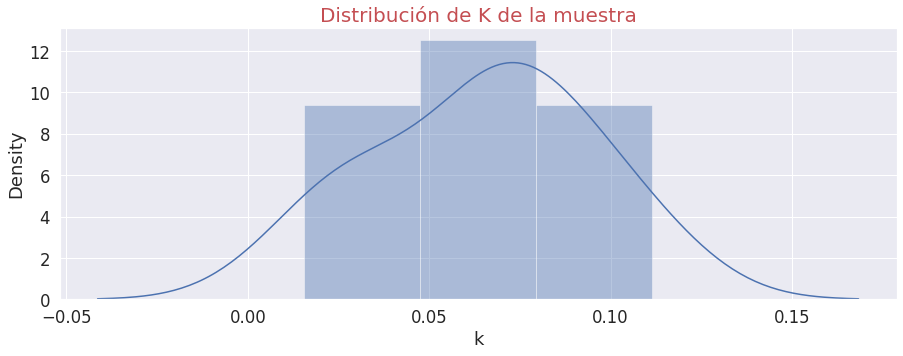

In [253]:
# analizamos la distribucion de los paises elegidos
sns.distplot(k_paises_elegidos, kde = True)
plt.title('Distribución de K de la muestra', size = 20, color='r')
plt.show()

En base al histrograma, no podemos afirmar que la distribución sea Normal. Luego, aplicaremos Bootstrapping para calcular el Intervalo de Confianza.

El Bootstrapping usa el muestreo aleatorio con reemplazo para calcular estadisticas muestrales.

In [255]:
# calculamos el tamaño de la muestra
n = len(k_paises_elegidos)
n

10

In [257]:
print(f"Media de k: { k_paises_elegidos.mean() }")
print(f"Mediana de k: { k_paises_elegidos.median() }")
print(f"Desvio estandar de k: { k_paises_elegidos.std() }")

Media de k: 0.06487247202909115
Mediana de k: 0.06827642744254717
Desvio estandar de k: 0.03006332648638063


Elegimos B=100 que significa cuantas veces vamos a hacer el proceso de selección y saca una muestra del tamaño original.

In [258]:
def bootstrap_simplificado(dataset, B=100):
    boots = list()
    for _ in range(B):
        boots.append(np.random.choice(dataset, size=len(dataset)))
    return np.array(boots)

In [259]:
datos_boots = bootstrap_simplificado(k_paises_elegidos, 100)

In [260]:
datos_boots.shape

(100, 10)

Tenemos 100 muestras de tamaño 10, de 10 datos cada una.

In [261]:
# trabajamos con un alpha del 5%
alpha = 0.05

In [264]:
medias = np.apply_along_axis(func1d=np.mean, axis=1, arr=datos_boots)

In [265]:
medias.shape #aca vemos que medias tiene tamaño 2

(100,)

Obtenemos el estadistico de tendencia central en cada una de las submuestras, luego ordeno el arreglo de menor a mayor, y luego saco los dos percentiles, superior e inferior basados en el nivel de confianza que elegi.

In [266]:
medias.sort() # aca ordenamos los elementos de menor a mayor

In [267]:
k_final = medias.mean()
medias.mean()

0.06419652706175619

(array([ 2.,  1.,  1.,  2.,  3.,  5., 10.,  8.,  6.,  3.,  6.,  5.,  8.,
         8.,  7.,  8.,  7.,  6.,  0.,  4.]),
 array([0.04405305, 0.04587852, 0.04770398, 0.04952945, 0.05135491,
        0.05318038, 0.05500585, 0.05683131, 0.05865678, 0.06048224,
        0.06230771, 0.06413318, 0.06595864, 0.06778411, 0.06960958,
        0.07143504, 0.07326051, 0.07508597, 0.07691144, 0.07873691,
        0.08056237]),
 <a list of 20 Patch objects>)

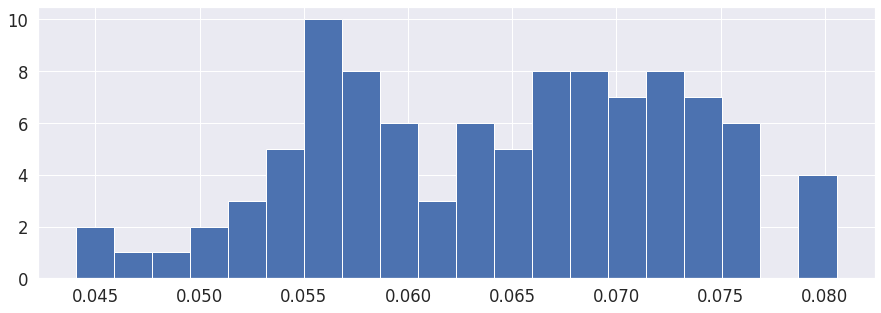

In [268]:
plt.hist(medias, bins=20)

Calculamos el Intervalo de Confianza a partir de los percentiles.

In [269]:
inferior = np.percentile(medias, alpha/2)

In [270]:
superior = np.percentile(medias, (100-alpha/2))

In [271]:
intervalo_confianza = [inferior, superior]
intervalo_confianza

[0.04408069597417608, 0.08054198266276974]

En base al Intervalo de Confianza, podemos decir que estamos 95% seguros que la media poblacional del parametro K esta entre 0.044 y 0.0805.

In [273]:
# obtenemos el valor de k para el mundo
k_wor

0.08549552385212679

Comparamos el modelo con los datos del mundo.

In [274]:
rmse = mean_squared_error(casos_principio, casos_simu)
print(np.format_float_scientific(rmse))

1.6220317066260998e+09


En base al valor del error, RMSE, podemos pensar que este resultado tiene sentido ya que el mundo es demasiado variado y es muy engorroso poder definir un modelo que de un valor de k que tienda al valor del mundos. 
Esto sucede porque el mundo es muy heterogéneo y los casos varian mucho de pais a pais. Luego, si queremos predecir la cantidad de casos deberíamos tener en cuenta determinadas caracteristicas como por ejemplo, analizar aquellos paises que implementen las mismas politicas publicas (cuarentena, uso de mascarilla, vacunación y demás) en determinados periodos de tiempo.

 # Evaluando estrategias

 Ahora que tienes una manera de obtener información de las curvas, puedes intentar evaluar las estrategias de acción y el comportamiento de las poblaciones, construyendo un clasificador binario. 

**1. Elige una categoría binaria que hable de políticas públicas elegidas por los países para enfrentar la pandemia que te interese estudiar, como pueden ser "la población hizo cuarententa" o "la población se vacunó".**

**2. Piensa qué indicadores de la curva pueden hablar del éxito de la política que quieres estudiar. Por ejemplo, si se tratase de evaluar el éxito de una cuarentena podría ser porcentaje de población  que se contagió o variación del valor de $k$ a partir de que se empezó a implementar esa medida. Elige al menos 3 indicadores.**

**3. Investiga sobre países que hayan aplicado o no esa política pública, para generar una base de datos. Por ejemplo, Brasil no hizo cuarentena y China hizo una muy estricta. Recuerda hacer una selección inteligente de la porción de datos de la curva de cada país que vas a analizar.**

Como política pública vamos a elegir **uso de mascarilla**. Definimos "uso de mascarilla" cuando el pais la exija en todo momento fuera del hogar.

Para hablar del éxito de esa política vamos a usar como indicadores las columnas: **nuevos casos** (new_cases), **nuevos fallecidos** (new_deaths) y **nuevos testeos** (new_tests). El éxito será cuando analicemos que los valores de esas variables disminuyeron.

Investigamos el uso de mascarilla como medida sanitaria en los paises del mundo:
https://ourworldindata.org/covid-face-coverings  

En base a la información de la web mencionada, vamos a analizar los siguientes 10 paises: Colombia, Bolivia, Mexico, Estados Unidos, Australia, Pakistan, Tailandia, Italia, España y Francia.  

El archivo que contiene los datos del nombre de cada columna y su descripción se encuentra en el siguiente link

https://github.com/owid/covid-19-data/tree/master/public/data#confirmed-cases

**4. Construye un clasificador binario a partir de una regresión logística o usando Naive Bayes para intentar analizar la estrategia de otros países y ver si es posible predecirla a partir de la curva de contagios y el clasificador. Un posible clasificador binario es uno que clasifique el porcentaje de contagios en función da las categorías "la población hizo cuarentena" y "la población n hizo cuarentena". Haz esto para los 3 indicadores que elegiste en el punto 3 y compara los resultados.**

In [639]:
# volvemos a analizar el tamaño del dataset
datos.shape

(163318, 67)

 El dataset tiene 67 columnas y 163.318 filas

In [640]:
# visualizamos las 5 primeras filas del datase
datos.head(5)

iso_code      continent       pais  total_cases  new_cases  \
0      ARG  South America  Argentina          NaN        NaN   
1      MEX  North America     Mexico          NaN        NaN   
2      MEX  North America     Mexico          NaN        NaN   
3      ARG  South America  Argentina          NaN        NaN   
4      ARG  South America  Argentina          NaN        NaN   

   new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  \
0                 NaN           NaN         NaN                  NaN   
1                 NaN           NaN         NaN                  NaN   
2                 NaN           NaN         NaN                  NaN   
3                 NaN           NaN         NaN                  NaN   
4                 NaN           NaN         NaN                  NaN   

   total_cases_per_million  ...  male_smokers  handwashing_facilities  \
0                      NaN  ...          27.7                     NaN   
1                      NaN  ...          21.4                  87.847   
2                      NaN  ...          21.4                  87.847   
3                      NaN  ...          27.7                     NaN   
4                      NaN  ...          27.7                     NaN   

   hospital_beds_per_thousand  life_expectancy  human_development_index  \
0                        5.00            76.67                    0.845   
1                        1.38            75.05                    0.779   
2                        1.38            75.05                    0.779   
3                        5.00            76.67                    0.845   
4                        5.00            76.67                    0.845   

   excess_mortality_cumulative_absolute  excess_mortality_cumulative  \
0                                   NaN                          NaN   
1                                   NaN                          NaN   
2                                   NaN                          NaN   
3                                   NaN                          NaN   
4                                   NaN                          NaN   

   excess_mortality  excess_mortality_cumulative_per_million       date  
0               NaN                                      NaN 2020-01-01  
1               NaN                                      NaN 2020-01-01  
2               NaN                                      NaN 2020-01-02  
3               NaN                                      NaN 2020-01-02  
4               NaN                                      NaN 2020-01-03  

[5 rows x 67 columns]

Vamos a analizar si el dataset tiene valores atipicos, valores faltantes y texto para procesarlo y poder implementar modelos.

In [641]:
# eliminamos las columnas que no vamos a utilizar en nuestro analisis
datos.drop(columns=['iso_code', 'continent', 'new_cases_smoothed', 'new_deaths_smoothed', 'new_cases_smoothed_per_million', 'total_cases_per_million',  
                    'new_deaths_smoothed_per_million', 'icu_patients', 'icu_patients_per_million', 'hosp_patients', 'total_deaths_per_million',
                    'hosp_patients_per_million', 'weekly_icu_admissions', 'weekly_icu_admissions_per_million', 'weekly_hosp_admissions', 
                    'weekly_hosp_admissions_per_million', 'total_tests_per_thousand', 'new_tests_per_thousand', 'new_tests_smoothed', 
                    'new_tests_smoothed_per_thousand', 'tests_per_case', 'tests_units', 'total_boosters', 'new_vaccinations',
                    'new_vaccinations_smoothed', 'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred', 
                    'people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred', 'new_vaccinations_smoothed_per_million', 
                    'new_people_vaccinated_smoothed', 'new_people_vaccinated_smoothed_per_hundred', 'stringency_index', 'aged_70_older', 
                    'gdp_per_capita', 'extreme_poverty', 'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers', 'male_smokers', 
                    'handwashing_facilities', 'hospital_beds_per_thousand', 'life_expectancy', 'human_development_index', 'new_deaths_per_million',  
                    'excess_mortality_cumulative_absolute', 'excess_mortality_cumulative', 'excess_mortality', 'new_cases_per_million', 
                    'excess_mortality_cumulative_per_million', 'people_fully_vaccinated', 'people_vaccinated', 'total_vaccinations'], inplace = True)

datos.head(5)

pais  total_cases  new_cases  total_deaths  new_deaths  \
0  Argentina          NaN        NaN           NaN         NaN   
1     Mexico          NaN        NaN           NaN         NaN   
2     Mexico          NaN        NaN           NaN         NaN   
3  Argentina          NaN        NaN           NaN         NaN   
4  Argentina          NaN        NaN           NaN         NaN   

   reproduction_rate  new_tests  total_tests  positive_rate   population  \
0                NaN        4.0          4.0            NaN   45605823.0   
1                NaN       25.0         25.0            NaN  130262220.0   
2                NaN       72.0         97.0            NaN  130262220.0   
3                NaN       95.0         99.0            NaN   45605823.0   
4                NaN        5.0        104.0            NaN   45605823.0   

   population_density  median_age  aged_65_older       date  
0              16.177        31.9         11.198 2020-01-01  
1              66.444        29.3          6.857 2020-01-01  
2              66.444        29.3          6.857 2020-01-02  
3              16.177        31.9         11.198 2020-01-02  
4              16.177        31.9         11.198 2020-01-03

# **Analizamos 10 paises, 5 que aplicaron la medida sanitaria mascarilla y 5 que no**

Filtramos el dataset y nos quedamos con los 10 paises elegidos para analizar el uso de mascarilla como medida sanitaria.

In [642]:
datos_paises = datos[datos.pais.isin(['Sweden', 'Colombia', 'Mexico', 'Pakistan', 'United Kingdom', 'Portugal', 'Italy', 'Canada', 'France', 'New Zealand'])]
datos_paises.shape

(7443, 14)

In [643]:
datos_paises['mascarilla'] = np.where((datos_paises['pais']=='France')|(datos_paises['pais']=='Colombia')|(datos_paises['pais']=='Pakistan')|
                                      (datos_paises['pais']=='Italy')|(datos_paises['pais']=='Mexico'),1,0)
datos_paises.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



pais  total_cases  new_cases  total_deaths  new_deaths  \
1   Mexico          NaN        NaN           NaN         NaN   
2   Mexico          NaN        NaN           NaN         NaN   
5   Mexico          NaN        NaN           NaN         NaN   
7   Mexico          NaN        NaN           NaN         NaN   
11  Mexico          NaN        NaN           NaN         NaN   

    reproduction_rate  new_tests  total_tests  positive_rate   population  \
1                 NaN       25.0         25.0            NaN  130262220.0   
2                 NaN       72.0         97.0            NaN  130262220.0   
5                 NaN       89.0        186.0            NaN  130262220.0   
7                 NaN       45.0        231.0            NaN  130262220.0   
11                NaN       81.0        312.0            NaN  130262220.0   

    population_density  median_age  aged_65_older       date  mascarilla  
1               66.444        29.3          6.857 2020-01-01           1  
2               66.444        29.3          6.857 2020-01-02           1  
5               66.444        29.3          6.857 2020-01-03           1  
7               66.444        29.3          6.857 2020-01-04           1  
11              66.444        29.3          6.857 2020-01-05           1

In [644]:
# Número de obsercaciones por clase
datos_paises.mascarilla.value_counts().sort_index()

0    3706
1    3737
Name: mascarilla, dtype: int64

In [645]:
# hacemos un describe para ver los valores que toman las variables y agregamos mas percentiles para tener mas información
datos_paises.describe([0.05, 0.25, 0.5, 0.75, 0.95])

total_cases      new_cases   total_deaths   new_deaths  \
count  7.384000e+03    7377.000000    7122.000000  7118.000000   
mean   1.896463e+06   10149.924088   53873.733923   140.847148   
std    2.838215e+06   29563.781198   66617.604223   232.819993   
min    1.000000e+00   -4860.000000       1.000000  -232.000000   
5%     1.280450e+03       0.000000      25.000000     0.000000   
25%    9.357000e+04     367.000000    6413.500000     6.000000   
50%    8.470570e+05    2409.000000   25247.000000    41.000000   
75%    2.525359e+06    7679.000000   97999.750000   172.000000   
95%    6.988539e+06   39222.000000  186130.150000   619.150000   
max    2.233947e+07  502507.000000  315688.000000  3050.000000   

       reproduction_rate     new_tests   total_tests  positive_rate  \
count        7101.000000  6.569000e+03  6.725000e+03    6883.000000   
mean            1.090476  1.624512e+05  3.546613e+07       0.095253   
std             0.330979  2.948126e+05  6.849654e+07       0.122914   
min             0.180000  1.600000e+01  0.000000e+00       0.000000   
5%              0.680000  3.226600e+03  1.373148e+05       0.000600   
25%             0.890000  1.992400e+04  2.506869e+06       0.015200   
50%             1.050000  4.662300e+04  1.057650e+07       0.044000   
75%             1.230000  1.283350e+05  2.972359e+07       0.121300   
95%             1.650000  8.839574e+05  1.765438e+08       0.395900   
max             3.570000  2.221976e+06  4.569911e+08       0.733000   

         population  population_density   median_age  aged_65_older  \
count  7.443000e+03         7443.000000  7443.000000    7443.000000   
mean   6.686884e+07          112.651198    38.236155      15.423613   
std    6.317306e+07           94.877558     7.253554       6.310307   
min    5.126300e+06            4.037000    23.500000       4.495000   
5%     5.126300e+06            4.037000    23.500000       4.495000   
25%    1.016792e+07           24.718000    32.200000       7.646000   
50%    6.036747e+07           66.444000    41.000000      18.517000   
75%    6.820711e+07          205.859000    42.000000      19.985000   
95%    2.251999e+08          272.898000    47.900000      23.021000   
max    2.251999e+08          272.898000    47.900000      23.021000   

        mascarilla  
count  7443.000000  
mean      0.502082  
std       0.500029  
min       0.000000  
5%        0.000000  
25%       0.000000  
50%       1.000000  
75%       1.000000  
95%       1.000000  
max       1.000000

Graficamos Boxplots para ver la distribucion de las variables.

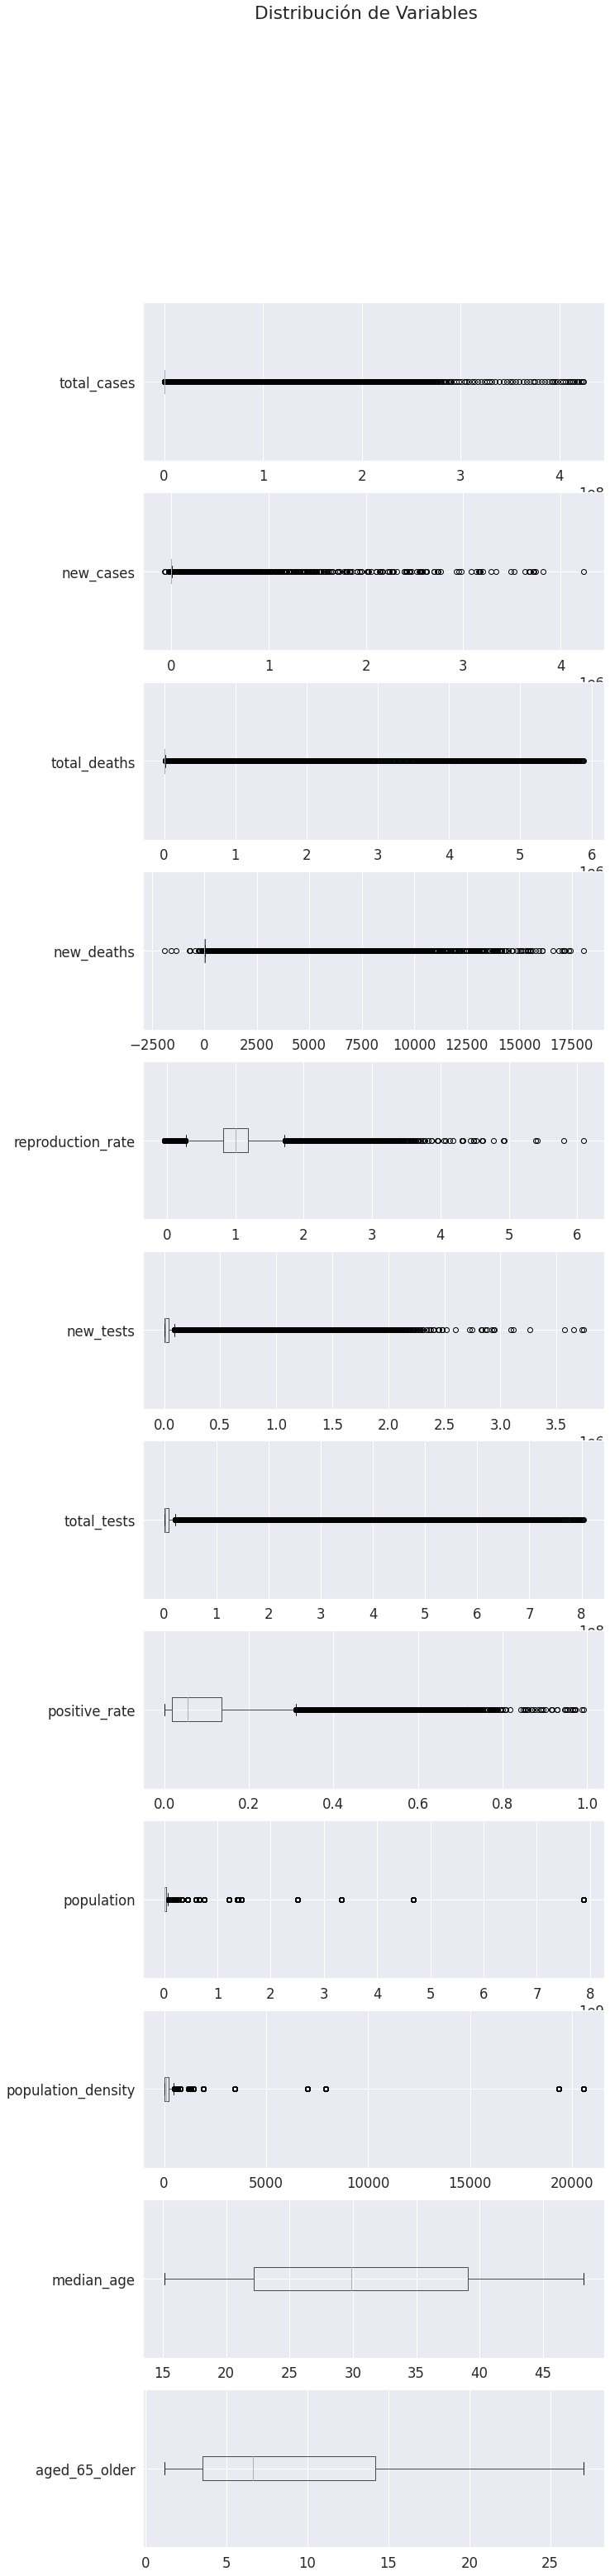

In [646]:
plt.rcParams["figure.figsize"] = (10, 50)
df_num= datos_paises.drop(columns=['pais', 'date', 'mascarilla'])
fig, axs = plt.subplots(12)
fig.suptitle('Distribución de Variables')
for i,el in enumerate(list(df_num.columns.values)[:]):
    a = datos.boxplot(el, ax=axs.flatten()[i],vert=False)

Vemos que existen outliers y en algunos casos es muy confusa su distribución.

Eliminamos los valores negativos en las varibles **new_cases** y **new_deaths** ya que no tienen sentido.

In [647]:
mask1 = datos_paises.new_cases > 0
datos_paises = datos_paises[mask1]

In [648]:
mask2 = datos_paises.new_deaths > 0
datos_paises = datos_paises[mask2]

In [649]:
datos_paises.describe([0.05, 0.1, 0.5, 0.75, 0.95])

total_cases      new_cases   total_deaths   new_deaths  \
count  5.987000e+03    5987.000000    5987.000000  5987.000000   
mean   2.247324e+06   12427.585268   61164.973944   166.912644   
std    2.980130e+06   32350.598995   66525.073275   244.030869   
min    1.200000e+01       1.000000       1.000000     1.000000   
5%     1.466720e+04     252.000000     591.300000     3.000000   
10%    5.144140e+04     390.000000    2061.600000     6.000000   
50%    1.102438e+06    3772.000000   29925.000000    61.000000   
75%    3.430403e+06   10654.000000  112871.000000   216.000000   
95%    7.299131e+06   43940.400000  197973.300000   655.700000   
max    2.233947e+07  502507.000000  315688.000000  3050.000000   

       reproduction_rate     new_tests   total_tests  positive_rate  \
count        5965.000000  5.560000e+03  5.616000e+03    5664.000000   
mean            1.088308  1.875901e+05  4.133066e+07       0.107227   
std             0.312383  3.121306e+05  7.280857e+07       0.125623   
min             0.360000  2.190000e+02  2.163000e+03       0.000300   
5%              0.690000  7.643450e+03  3.416990e+05       0.006700   
10%             0.760000  1.336180e+04  9.979460e+05       0.010100   
50%             1.050000  5.516100e+04  1.312570e+07       0.052300   
75%             1.230000  1.812342e+05  3.814834e+07       0.150000   
95%             1.620000  9.556026e+05  1.961077e+08       0.406000   
max             3.570000  2.221976e+06  4.569911e+08       0.695000   

         population  population_density   median_age  aged_65_older  \
count  5.987000e+03         5987.000000  5987.000000    5987.000000   
mean   7.569351e+07          128.377130    38.236847      15.284883   
std    6.304394e+07           94.477742     7.791586       6.706025   
min    5.126300e+06            4.037000    23.500000       4.495000   
5%     1.016016e+07            4.037000    23.500000       4.495000   
10%    1.016792e+07            4.037000    23.500000       4.495000   
50%    6.036747e+07          112.371000    41.000000      18.517000   
75%    6.820711e+07          205.859000    42.000000      19.985000   
95%    2.251999e+08          272.898000    47.900000      23.021000   
max    2.251999e+08          272.898000    47.900000      23.021000   

        mascarilla  
count  5987.000000  
mean      0.577919  
std       0.493933  
min       0.000000  
5%        0.000000  
10%       0.000000  
50%       1.000000  
75%       1.000000  
95%       1.000000  
max       1.000000

**Identificamos y tratamos los Valores Faltantes**

In [650]:
# vemos la cantidad de valores nulos que tenemos
print('Porcentaje de Valores Faltantes por Variable:')
((datos_paises.isna().sum()/datos_paises.shape[0])*100).sort_values(ascending=False).round(2)

Porcentaje de Valores Faltantes por Variable:


new_tests             7.13
total_tests           6.20
positive_rate         5.40
reproduction_rate     0.37
pais                  0.00
total_cases           0.00
new_cases             0.00
total_deaths          0.00
new_deaths            0.00
population            0.00
population_density    0.00
median_age            0.00
aged_65_older         0.00
date                  0.00
mascarilla            0.00
dtype: float64

Vamos a imputar esos valores faltantes por la media de esas variables de cada pais.

In [651]:
new_tests_pais = datos_paises[['new_tests', 'pais']].groupby('pais').agg(pd.Series.mean)
total_tests_pais = datos_paises[['total_tests', 'pais']].groupby('pais').agg(pd.Series.mean)
positive_rate_pais = datos_paises[['positive_rate', 'pais']].groupby('pais').agg(pd.Series.mean)
reproduction_rate_pais = datos_paises[['reproduction_rate', 'pais']].groupby('pais').agg(pd.Series.mean)
datos_paises = datos_paises.set_index('pais')
datos_paises.new_tests.fillna(new_tests_pais.to_dict()['new_tests'], inplace=True)
datos_paises.total_tests.fillna(total_tests_pais.to_dict()['total_tests'], inplace=True)
datos_paises.positive_rate.fillna(positive_rate_pais.to_dict()['positive_rate'], inplace=True)
datos_paises.reproduction_rate.fillna(reproduction_rate_pais.to_dict()['reproduction_rate'], inplace=True)
datos_paises = datos_paises.reset_index()
datos_paises.head()

pais  total_cases  new_cases  total_deaths  new_deaths  \
0  France         12.0        1.0           1.0         1.0   
1   Italy         20.0       17.0           1.0         1.0   
2   Italy         62.0       42.0           2.0         1.0   
3   Italy        155.0       93.0           3.0         1.0   
4   Italy        229.0       74.0           7.0         4.0   

   reproduction_rate      new_tests   total_tests  positive_rate  population  \
0           1.114701  387734.009693  8.065163e+07       0.064832  67422000.0   
1           1.095207  253834.364771  5.194936e+07       0.055669  60367471.0   
2           1.095207  253834.364771  5.194936e+07       0.055669  60367471.0   
3           1.095207  253834.364771  5.194936e+07       0.055669  60367471.0   
4           3.570000  253834.364771  4.324000e+03       0.055669  60367471.0   

   population_density  median_age  aged_65_older       date  mascarilla  
0             122.578        42.0         19.718 2020-02-15           1  
1             205.859        47.9         23.021 2020-02-21           1  
2             205.859        47.9         23.021 2020-02-22           1  
3             205.859        47.9         23.021 2020-02-23           1  
4             205.859        47.9         23.021 2020-02-24           1

In [652]:
((datos_paises.isna().sum()/datos_paises.shape[0])*100).sort_values(ascending=False).round(2)

pais                  0.0
total_cases           0.0
new_cases             0.0
total_deaths          0.0
new_deaths            0.0
reproduction_rate     0.0
new_tests             0.0
total_tests           0.0
positive_rate         0.0
population            0.0
population_density    0.0
median_age            0.0
aged_65_older         0.0
date                  0.0
mascarilla            0.0
dtype: float64

In [653]:
total_casos_paises = datos_paises[['pais', 'total_cases', 'population']].groupby('pais', as_index=False).sum().sort_values('total_cases', ascending=False).head(10)
total_casos_paises

pais   total_cases    population
9  United Kingdom  3.196424e+09  4.835884e+10
2          France  3.147079e+09  4.645376e+10
3           Italy  2.147222e+09  4.400789e+10
1        Colombia  1.819668e+09  3.547596e+10
4          Mexico  1.269624e+09  8.649411e+10
0          Canada  6.825885e+08  2.676174e+10
6        Pakistan  4.760806e+08  1.544872e+11
7        Portugal  4.741100e+08  7.005699e+09
8          Sweden  2.416650e+08  3.931982e+09
5     New Zealand  2.654890e+05  1.999257e+08

**Codificamos la variable no numerica "pais"**

In [654]:
#Transformamos a dummies las variables que no sean cuantitativas.
datos_paises = pd.get_dummies(datos_paises, columns=['pais'])
datos_paises.head(5)

total_cases  new_cases  total_deaths  new_deaths  reproduction_rate  \
0         12.0        1.0           1.0         1.0           1.114701   
1         20.0       17.0           1.0         1.0           1.095207   
2         62.0       42.0           2.0         1.0           1.095207   
3        155.0       93.0           3.0         1.0           1.095207   
4        229.0       74.0           7.0         4.0           3.570000   

       new_tests   total_tests  positive_rate  population  population_density  \
0  387734.009693  8.065163e+07       0.064832  67422000.0             122.578   
1  253834.364771  5.194936e+07       0.055669  60367471.0             205.859   
2  253834.364771  5.194936e+07       0.055669  60367471.0             205.859   
3  253834.364771  5.194936e+07       0.055669  60367471.0             205.859   
4  253834.364771  4.324000e+03       0.055669  60367471.0             205.859   

   ...  pais_Canada  pais_Colombia pais_France  pais_Italy  pais_Mexico  \
0  ...            0              0           1           0            0   
1  ...            0              0           0           1            0   
2  ...            0              0           0           1            0   
3  ...            0              0           0           1            0   
4  ...            0              0           0           1            0   

   pais_New Zealand  pais_Pakistan  pais_Portugal  pais_Sweden  \
0                 0              0              0            0   
1                 0              0              0            0   
2                 0              0              0            0   
3                 0              0              0            0   
4                 0              0              0            0   

   pais_United Kingdom  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0  

[5 rows x 24 columns]

Observamos que el número de columnas aumenta al transformar la varible pais a dummie ya que crea una nueva columna para cada categoria.

**Escalamos todas las variables numericas**

Escalamos porque la escala en la que se miden las variables como la magnitud de su varianza pueden influir en el modelo.

In [655]:
datos_paises_escalados = datos_paises.copy()
datos_paises_escalados.columns

Index(['total_cases', 'new_cases', 'total_deaths', 'new_deaths',
       'reproduction_rate', 'new_tests', 'total_tests', 'positive_rate',
       'population', 'population_density', 'median_age', 'aged_65_older',
       'date', 'mascarilla', 'pais_Canada', 'pais_Colombia', 'pais_France',
       'pais_Italy', 'pais_Mexico', 'pais_New Zealand', 'pais_Pakistan',
       'pais_Portugal', 'pais_Sweden', 'pais_United Kingdom'],
      dtype='object')

In [656]:
# no escalamos la variable a predecir "mascarilla"
X = datos_paises_escalados[['total_cases', 'new_cases', 'total_deaths', 'new_deaths', 'reproduction_rate', 'new_tests', 'total_tests', 'positive_rate',
                            'population', 'population_density', 'median_age', 'aged_65_older']]

In [657]:
escalador = StandardScaler().fit(X.values)

In [658]:
X_escalado = escalador.transform(X.values)
X_escalado

array([[-0.75416164, -0.38415435, -0.91948914, ..., -0.06138603,
         0.4830169 ,  0.6611199 ],
       [-0.75415896, -0.38365972, -0.91948914, ...,  0.82017563,
         1.24030722,  1.15370316],
       [-0.75414487, -0.38288688, -0.91947411, ...,  0.82017563,
         1.24030722,  1.15370316],
       ...,
       [ 5.50582434,  0.40523236,  1.49662881, ...,  1.52980943,
         0.32899175,  0.48201227],
       [ 3.43055732,  0.92044359,  1.38040728, ...,  0.82017563,
         1.24030722,  1.15370316],
       [ 1.06249267, -0.20754317,  3.82629094, ..., -0.65558618,
        -1.1470826 , -1.25686779]])

In [659]:
datos_paises_escalados = pd.DataFrame(X_escalado, columns=['total_cases', 'new_cases', 'total_deaths', 'new_deaths', 'reproduction_rate', 'new_tests', 
                                                           'total_tests', 'positive_rate', 'population', 'population_density', 'median_age', 'aged_65_older'])
datos_paises_escalados.head()

total_cases  new_cases  total_deaths  new_deaths  reproduction_rate  \
0    -0.754162  -0.384154     -0.919489   -0.679941           0.084660   
1    -0.754159  -0.383660     -0.919489   -0.679941           0.022138   
2    -0.754145  -0.382887     -0.919474   -0.679941           0.022138   
3    -0.754114  -0.381310     -0.919459   -0.679941           0.022138   
4    -0.754089  -0.381898     -0.919399   -0.667646           7.959658   

   new_tests  total_tests  positive_rate  population  population_density  \
0   0.665729     0.557401      -0.345135   -0.131213           -0.061386   
1   0.227285     0.154824      -0.419650   -0.243121            0.820176   
2   0.227285     0.154824      -0.419650   -0.243121            0.820176   
3   0.227285     0.154824      -0.419650   -0.243121            0.820176   
4   0.227285    -0.573755      -0.419650   -0.243121            0.820176   

   median_age  aged_65_older  
0    0.483017       0.661120  
1    1.240307       1.153703  
2    1.240307       1.153703  
3    1.240307       1.153703  
4    1.240307       1.153703

In [660]:
datos_paises = datos_paises.drop(columns=['total_cases', 'new_cases', 'total_deaths', 'new_deaths', 'reproduction_rate', 'new_tests', 
                                          'total_tests', 'positive_rate', 'population', 'population_density', 'median_age', 'aged_65_older', 
                                          ])
datos_paises.head(5)

date  mascarilla  pais_Canada  pais_Colombia  pais_France  pais_Italy  \
0 2020-02-15           1            0              0            1           0   
1 2020-02-21           1            0              0            0           1   
2 2020-02-22           1            0              0            0           1   
3 2020-02-23           1            0              0            0           1   
4 2020-02-24           1            0              0            0           1   

   pais_Mexico  pais_New Zealand  pais_Pakistan  pais_Portugal  pais_Sweden  \
0            0                 0              0              0            0   
1            0                 0              0              0            0   
2            0                 0              0              0            0   
3            0                 0              0              0            0   
4            0                 0              0              0            0   

   pais_United Kingdom  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0

In [661]:
datos_paises_escalados = pd.concat([datos_paises_escalados, datos_paises], axis=1)

In [662]:
datos_paises_escalados.head()

total_cases  new_cases  total_deaths  new_deaths  reproduction_rate  \
0    -0.754162  -0.384154     -0.919489   -0.679941           0.084660   
1    -0.754159  -0.383660     -0.919489   -0.679941           0.022138   
2    -0.754145  -0.382887     -0.919474   -0.679941           0.022138   
3    -0.754114  -0.381310     -0.919459   -0.679941           0.022138   
4    -0.754089  -0.381898     -0.919399   -0.667646           7.959658   

   new_tests  total_tests  positive_rate  population  population_density  ...  \
0   0.665729     0.557401      -0.345135   -0.131213           -0.061386  ...   
1   0.227285     0.154824      -0.419650   -0.243121            0.820176  ...   
2   0.227285     0.154824      -0.419650   -0.243121            0.820176  ...   
3   0.227285     0.154824      -0.419650   -0.243121            0.820176  ...   
4   0.227285    -0.573755      -0.419650   -0.243121            0.820176  ...   

   pais_Canada  pais_Colombia pais_France  pais_Italy  pais_Mexico  \
0            0              0           1           0            0   
1            0              0           0           1            0   
2            0              0           0           1            0   
3            0              0           0           1            0   
4            0              0           0           1            0   

   pais_New Zealand  pais_Pakistan  pais_Portugal  pais_Sweden  \
0                 0              0              0            0   
1                 0              0              0            0   
2                 0              0              0            0   
3                 0              0              0            0   
4                 0              0              0            0   

   pais_United Kingdom  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0  

[5 rows x 24 columns]

Analizamos la correlación de la variable a predecir **new_cases** con las demas variables.



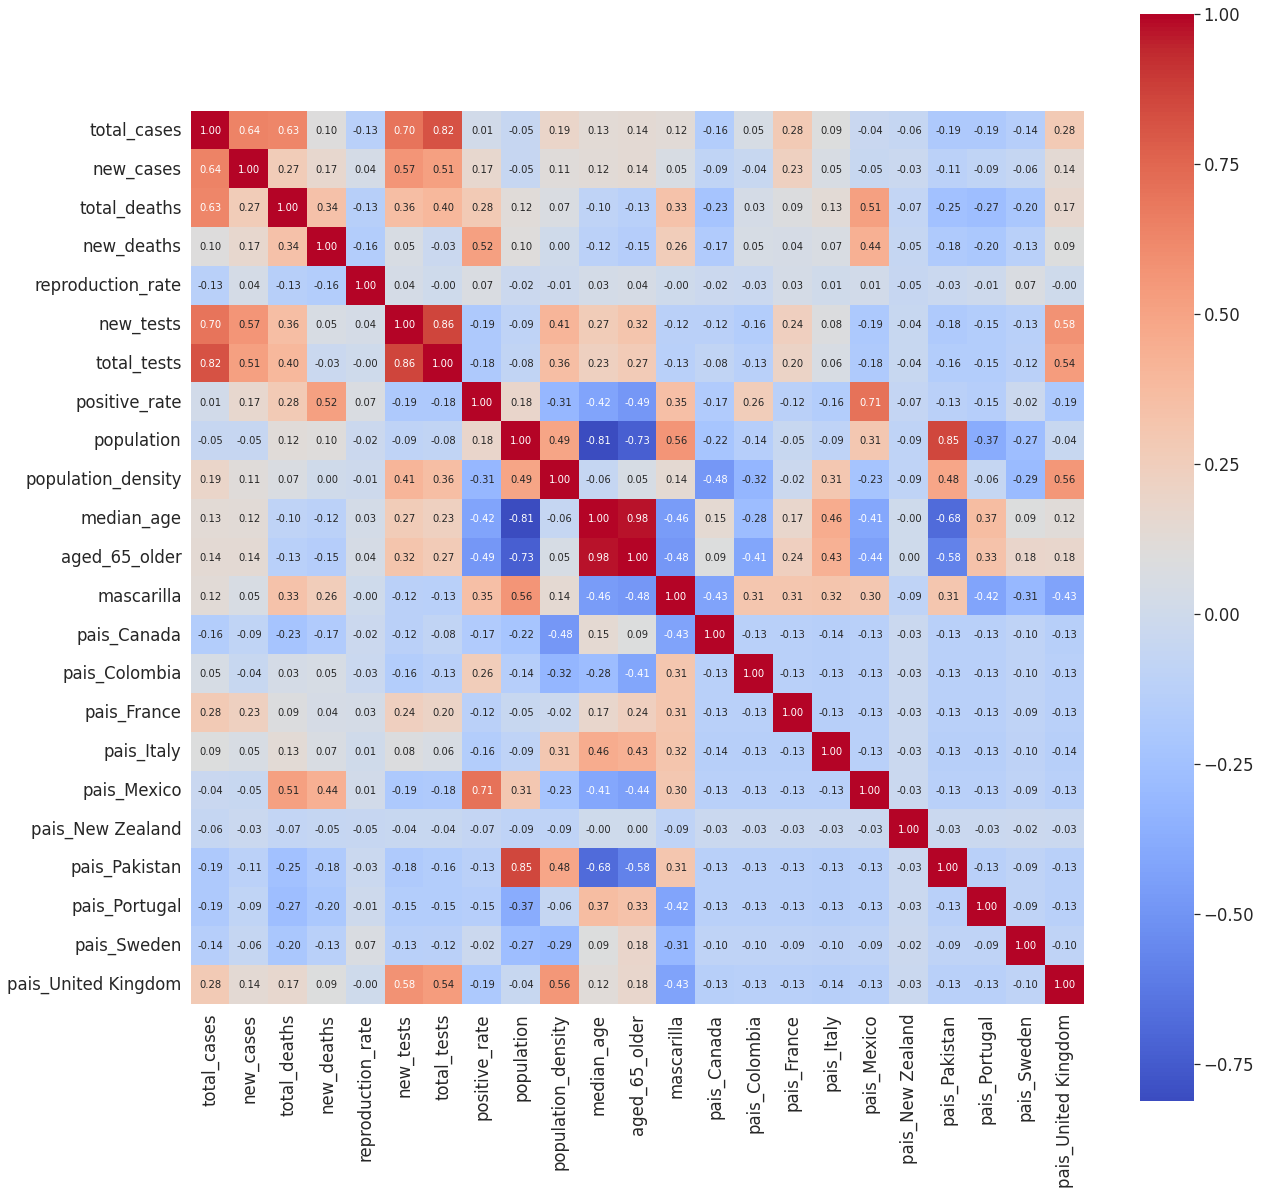

In [663]:
corr=datos_paises_escalados.corr()

plt.figure(figsize=(20,20))
ax=sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 10},
           cmap= 'coolwarm')
plt.show()

**Aplicamos Regresion Logistica**

La regresión logística es un tipo de análisis de regresión que se utiliza para predecir el resultado
de una variable categórica en función de variables independientes. Modela la probabilidad de que una
muestra pertenezca a una clase en función de otras variables.

In [664]:
# Número de obsercaciones por clase
print("Número de observaciones por clase")
print(datos_paises_escalados['mascarilla'].value_counts())
print("")

print("Porcentaje de observaciones por clase")
print(100 * datos_paises_escalados['mascarilla'].value_counts(normalize=True))

Número de observaciones por clase
1    3460
0    2527
Name: mascarilla, dtype: int64

Porcentaje de observaciones por clase
1    57.791882
0    42.208118
Name: mascarilla, dtype: float64


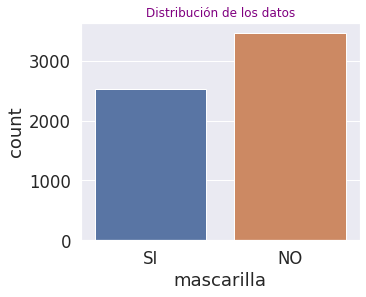

In [665]:
plt.figure(figsize=(5, 4))
sns.countplot(data=datos_paises_escalados, x='mascarilla')
plt.title("Distribución de los datos", size=12, color='purple')
plt.xticks(range(2), ['SI', 'NO'])
plt.show()

In [666]:
X = datos_paises_escalados[["new_cases", "new_deaths", "new_tests"]]
y = datos_paises_escalados.mascarilla

In [667]:
# realizamos un Train/Test Split de los datos en un 70%-30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [668]:
logreg = LogisticRegression()

In [669]:
#entrenamos la regresión logística con los datos de entrenamiento
logreg = logreg.fit(X_train,y_train)

In [670]:
# predecimos con los datos de prueba
y_pred = logreg.predict(X_test)

In [671]:
y_pred

array([0, 1, 0, ..., 0, 1, 1])

la función **predict_proba** da las estimaciones para todas las clases. La primer columna es la probabilidad de la clase 1, P(Y=1|X), y la segunda columna es la probabilidad de la clase 0, P(Y=0|X):

In [672]:
y_prob = logreg.predict_proba(X_test)
y_prob

array([[0.50006258, 0.49993742],
       [0.35549355, 0.64450645],
       [0.87887628, 0.12112372],
       ...,
       [0.76751475, 0.23248525],
       [0.34198455, 0.65801545],
       [0.47914715, 0.52085285]])

In [673]:
# score del modelo
score = logreg.score(X_test, y_test)
predict = logreg.predict(X_test)

In [674]:
y_train_pred = logreg.predict(X_train)
y_test_pred = logreg.predict(X_test)

In [675]:
print('La precisión del modelo es de', score)

La precisión del modelo es de 0.5971062882582081


In [676]:
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print('Porcentaje de aciertos sobre el set de entrenamiento:', train_acc)
print('Porcentaje de aciertos sobre el set de evaluación:',test_acc)

Porcentaje de aciertos sobre el set de entrenamiento: 0.6009546539379474
Porcentaje de aciertos sobre el set de evaluación: 0.5971062882582081


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



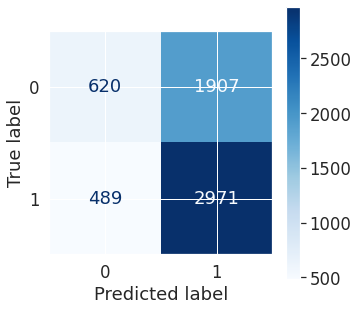

In [677]:
# calculamos la matriz de confusión
plt.rcParams["figure.figsize"] = (5, 5)
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(logreg, X, y, cmap=plt.cm.Blues, values_format = '.0f')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



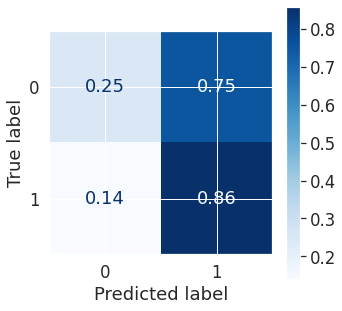

In [678]:
# calculamos la matriz normalizada
plt.rcParams["figure.figsize"] = (5, 5)
plot_confusion_matrix(logreg, X, y, cmap=plt.cm.Blues, values_format = '.2f', normalize= 'true')

In [679]:
#calculamos la exactitud del modelo
from sklearn.metrics import accuracy_score
exactitud = accuracy_score(y_test, y_test_pred)
print('Exactitud del modelo:')
print(exactitud)

Exactitud del modelo:
0.5971062882582081


In [680]:
#calculamos la sensibilidad del modelo
from sklearn.metrics import recall_score
sensibilidad = recall_score(y_test, y_test_pred)
print('Sensibilidad del modelo:')
print(sensibilidad)

Sensibilidad del modelo:
0.8570029382957884


In [681]:
#calculo el Puntaje F1 del modelo
from sklearn.metrics import f1_score
puntajef1 = f1_score(y_test, y_test_pred)
print('Puntaje F1 del modelo:')
print(puntajef1)

Puntaje F1 del modelo:
0.7073565076798707


In [682]:
#calculamos la curva ROC - AUC del modelo
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(y_test, y_test_pred)
print('Curva ROC - AUC del modelo:')
print(roc_auc)

Curva ROC - AUC del modelo:
0.5560787887355231


In [683]:
datos_paises_escalados.groupby('mascarilla').agg({'new_cases':[np.mean, np.std]}).sort_values([('new_cases','std')], ascending= False). head()

new_cases          
                mean       std
mascarilla                    
1           0.045687  1.189074
0          -0.062555  0.653640

Se observa que el promedio de nuevas muertes por Covid_19 para los paises que no hicieron cuarentena dio negativa lo que indica que las medidas sanitarias que tomaron esos paises no fue eficiente en comparacion con los paises que si implementaron el uso de mascarilla.

In [684]:
datos_paises_escalados.groupby('mascarilla').agg({'new_deaths':[np.mean, np.std]}).sort_values([('new_deaths','std')], ascending= False). head()

new_deaths          
                 mean       std
mascarilla                     
1            0.223077  1.086590
0           -0.305439  0.769341

In [685]:
datos_paises_escalados.groupby('mascarilla').agg({'new_tests':[np.mean, np.std]}).sort_values([('new_tests','std')], ascending= False). head()

new_tests          
                mean       std
mascarilla                    
0           0.145576  1.222180
1          -0.106321  0.783095

**A continuación, vamos a analizar 10 paises estudiando un rango de fechas donde se haya aplicado el uso de mascarilla como medida sanitaria y otro rango de fechas donde no.**

In [686]:
datos2 = datos[datos.pais.isin(['Bolivia', 'Colombia', 'Mexico', 'Pakistan', 'United States', 'Spain', 'Italy', 'Thailand', 'France', 'Australia'])]
datos2.shape

(7497, 14)

In [687]:
# hacemos un describe para ver los valores que toman las variables y agregamos mas percentiles para tener mas información
datos2.describe([0.05, 0.25, 0.5, 0.75, 0.95])

total_cases     new_cases   total_deaths   new_deaths  \
count  7.421000e+03  7.413000e+03    7159.000000  7156.000000   
mean   4.117681e+06  1.944495e+04   92187.139545   258.734628   
std    9.838678e+06  6.281666e+04  157785.150105   515.760734   
min    1.000000e+00 -7.434700e+04       1.000000 -1918.000000   
5%     4.930000e+02  0.000000e+00      58.000000     0.000000   
25%    1.105740e+05  3.140000e+02    4726.000000     8.000000   
50%    8.205830e+05  2.834000e+03   29553.000000    55.000000   
75%    3.797210e+06  1.227200e+04  112988.500000   283.000000   
95%    2.781370e+07  8.815580e+04  513197.700000  1157.750000   
max    7.847913e+07  1.367651e+06  935335.000000  4442.000000   

       reproduction_rate     new_tests   total_tests  positive_rate  \
count        7093.000000  6.935000e+03  6.997000e+03    7003.000000   
mean            1.097362  2.116674e+05  5.509728e+07       0.123893   
std             0.348022  4.082842e+05  1.266003e+08       0.136190   
min             0.360000  1.000000e+00  2.000000e+00       0.000000   
5%              0.680000  1.460700e+03  5.560040e+04       0.000400   
25%             0.890000  1.676300e+04  2.133908e+06       0.020700   
50%             1.040000  4.904800e+04  1.095189e+07       0.071000   
75%             1.240000  1.798090e+05  4.099839e+07       0.175000   
95%             1.660000  1.181392e+06  3.461658e+08       0.424000   
max             3.660000  3.112094e+06  8.036141e+08       0.695000   

         population  population_density   median_age  aged_65_older  
count  7.497000e+03         7497.000000  7497.000000    7497.000000  
mean   1.026818e+08           97.277104    36.322943      13.083240  
std    9.633664e+07           78.720363     7.831227       6.143739  
min    1.183294e+07            3.202000    23.500000       4.495000  
5%     1.183294e+07            3.202000    23.500000       4.495000  
25%    4.674521e+07           35.608000    29.300000       6.857000  
50%    6.742200e+07           93.105000    38.300000      15.413000  
75%    1.302622e+08          135.132000    42.000000      19.436000  
95%    3.329151e+08          255.573000    47.900000      23.021000  
max    3.329151e+08          255.573000    47.900000      23.021000

**Identificamos y tratamos los Valores Atipicos (Outliers)**

En base a la información de la tabla anterior, para las variables new_cases, new_deaths y new_cases_per_million, filtramos los valores que sean menores a 0 porque esas columnas no pueden tener valores negativos, no es lógico.

In [688]:
mask1 = datos2.new_cases > 0
datos2 = datos2[mask1]

In [689]:
mask2 = datos2.new_deaths > 0
datos2 = datos2[mask2]

In [690]:
datos2.describe([0.05, 0.1, 0.5, 0.75, 0.95])

total_cases     new_cases   total_deaths   new_deaths  \
count  6.046000e+03  6.046000e+03    6046.000000  6046.000000   
mean   4.891772e+06  2.383835e+04  104597.759841   305.874793   
std    1.071555e+07  6.879254e+04  167040.606579   547.067840   
min    1.200000e+01  1.000000e+00       1.000000     1.000000   
5%     7.841750e+03  1.550000e+02     141.250000     3.000000   
10%    3.906750e+04  3.590000e+02     970.000000     7.000000   
50%    1.289025e+06  4.842000e+03   35443.000000    86.500000   
75%    4.335364e+06  1.701300e+04  123571.000000   351.000000   
95%    3.214251e+07  1.136745e+05  571020.000000  1322.000000   
max    7.847913e+07  1.367651e+06  935335.000000  4442.000000   

       reproduction_rate     new_tests   total_tests  positive_rate  \
count        6013.000000  5.715000e+03  5.770000e+03    5819.000000   
mean            1.095111  2.489077e+05  6.437052e+07       0.140137   
std             0.341815  4.402517e+05  1.373445e+08       0.138148   
min             0.360000  5.700000e+01  6.970000e+02       0.000000   
5%              0.690000  2.463900e+03  1.537044e+05       0.007300   
10%             0.770000  5.826200e+03  4.367444e+05       0.012000   
50%             1.040000  5.558100e+04  1.261414e+07       0.088200   
75%             1.230000  2.265045e+05  5.173839e+07       0.204000   
95%             1.640000  1.332686e+06  4.227386e+08       0.433450   
max             3.660000  3.112094e+06  8.036141e+08       0.695000   

         population  population_density   median_age  aged_65_older  
count  6.046000e+03         6046.000000  6046.000000    6046.000000  
mean   1.114668e+08          101.916214    35.867731      12.939603  
std    1.011476e+08           81.171984     8.162585       6.458244  
min    1.183294e+07            3.202000    23.500000       4.495000  
5%     1.183294e+07            3.202000    23.500000       4.495000  
10%    1.183294e+07           10.202000    23.500000       4.495000  
50%    6.742200e+07           66.444000    38.300000      11.373000  
75%    1.302622e+08          135.132000    42.000000      19.436000  
95%    3.329151e+08          255.573000    47.900000      23.021000  
max    3.329151e+08          255.573000    47.900000      23.021000

**Identificamos y tratamos los Valores Faltantes**

In [691]:
# vemos la cantidad de valores nulos que tenemos
print('Porcentaje de Valores Faltantes por Variable:')
((datos2.isna().sum()/datos2.shape[0])*100).sort_values(ascending=False).round(2)

Porcentaje de Valores Faltantes por Variable:


new_tests             5.47
total_tests           4.57
positive_rate         3.75
reproduction_rate     0.55
pais                  0.00
total_cases           0.00
new_cases             0.00
total_deaths          0.00
new_deaths            0.00
population            0.00
population_density    0.00
median_age            0.00
aged_65_older         0.00
date                  0.00
dtype: float64

Vamos a imputar esos valores faltantes por la media de esas variables de cada pais.

In [692]:
new_tests_pais = datos2[['new_tests', 'pais']].groupby('pais').agg(pd.Series.mean)
total_tests_pais = datos2[['total_tests', 'pais']].groupby('pais').agg(pd.Series.mean)
positive_rate_pais = datos2[['positive_rate', 'pais']].groupby('pais').agg(pd.Series.mean)
reproduction_rate_pais = datos2[['reproduction_rate', 'pais']].groupby('pais').agg(pd.Series.mean)
datos2 = datos2.set_index('pais')
datos2.new_tests.fillna(new_tests_pais.to_dict()['new_tests'], inplace=True)
datos2.total_tests.fillna(total_tests_pais.to_dict()['total_tests'], inplace=True)
datos2.positive_rate.fillna(positive_rate_pais.to_dict()['positive_rate'], inplace=True)
datos2.reproduction_rate.fillna(reproduction_rate_pais.to_dict()['reproduction_rate'], inplace=True)
datos2 = datos2.reset_index()
datos2.head()

pais  total_cases  new_cases  total_deaths  new_deaths  \
0  France         12.0        1.0           1.0         1.0   
1   Italy         20.0       17.0           1.0         1.0   
2   Italy         62.0       42.0           2.0         1.0   
3   Italy        155.0       93.0           3.0         1.0   
4   Italy        229.0       74.0           7.0         4.0   

   reproduction_rate      new_tests   total_tests  positive_rate  population  \
0           1.114701  387734.009693  8.065163e+07       0.064832  67422000.0   
1           1.095207  253834.364771  5.194936e+07       0.055669  60367471.0   
2           1.095207  253834.364771  5.194936e+07       0.055669  60367471.0   
3           1.095207  253834.364771  5.194936e+07       0.055669  60367471.0   
4           3.570000  253834.364771  4.324000e+03       0.055669  60367471.0   

   population_density  median_age  aged_65_older       date  
0             122.578        42.0         19.718 2020-02-15  
1             205.859        47.9         23.021 2020-02-21  
2             205.859        47.9         23.021 2020-02-22  
3             205.859        47.9         23.021 2020-02-23  
4             205.859        47.9         23.021 2020-02-24

In [693]:
((datos2.isna().sum()/datos2.shape[0])*100).sort_values(ascending=False).round(2)

pais                  0.0
total_cases           0.0
new_cases             0.0
total_deaths          0.0
new_deaths            0.0
reproduction_rate     0.0
new_tests             0.0
total_tests           0.0
positive_rate         0.0
population            0.0
population_density    0.0
median_age            0.0
aged_65_older         0.0
date                  0.0
dtype: float64

In [694]:
total_casos_paises = datos2[['pais', 'total_cases', 'population']].groupby('pais', as_index=False).sum().sort_values('total_cases', ascending=False).head(10)
total_casos_paises

pais   total_cases    population
9  United States  1.857454e+10  2.403647e+11
3         France  3.147079e+09  4.645376e+10
4          Italy  2.147222e+09  4.400789e+10
2       Colombia  1.819668e+09  3.547596e+10
7          Spain  1.438014e+09  2.374657e+10
5         Mexico  1.269624e+09  8.649411e+10
6       Pakistan  4.760806e+08  1.544872e+11
8       Thailand  4.014588e+08  2.644142e+10
1        Bolivia  1.749332e+08  7.431084e+09
0      Australia  1.270342e+08  9.025876e+09

In [ ]:
# Analisis de Correlacion entre los indicadores 

corr_df = datos_paises.corr()
sns.heatmap(corr_df, annot=True)

#**PAIS 1: COLOMBIA**

In [708]:
datos_col = datos2[(datos2['pais']=='Colombia')]
datos_col

pais  total_cases  new_cases  total_deaths  new_deaths  \
97    Colombia        231.0       35.0           2.0         2.0   
108   Colombia        277.0       46.0           3.0         1.0   
124   Colombia        470.0       92.0           4.0         1.0   
129   Colombia        491.0       21.0           6.0         2.0   
153   Colombia        702.0       94.0          10.0         4.0   
...        ...          ...        ...           ...         ...   
6004  Colombia    6031130.0     4142.0      137586.0       147.0   
6017  Colombia    6035143.0     4013.0      137733.0       147.0   
6026  Colombia    6039163.0     4020.0      137869.0       136.0   
6029  Colombia    6043661.0     4498.0      137996.0       127.0   
6037  Colombia    6047042.0     3381.0      138106.0       110.0   

      reproduction_rate     new_tests   total_tests  positive_rate  \
97             2.200000  52163.312804  1.496047e+07       0.196297   
108            2.210000  52163.312804  1.496047e+07       0.196297   
124            1.980000  52163.312804  1.496047e+07       0.196297   
129            1.770000  52163.312804  1.496047e+07       0.196297   
153            1.810000  52163.312804  1.496047e+07       0.196297   
...                 ...           ...           ...            ...   
6004           0.480000  35630.000000  3.276844e+07       0.180000   
6017           0.480000  38982.000000  3.280743e+07       0.169000   
6026           0.480000  52163.312804  1.496047e+07       0.196297   
6029           1.063652  52163.312804  1.496047e+07       0.196297   
6037           1.063652  52163.312804  1.496047e+07       0.196297   

      population  population_density  median_age  aged_65_older       date  
97    51265841.0              44.223        32.2          7.646 2020-03-22  
108   51265841.0              44.223        32.2          7.646 2020-03-23  
124   51265841.0              44.223        32.2          7.646 2020-03-25  
129   51265841.0              44.223        32.2          7.646 2020-03-26  
153   51265841.0              44.223        32.2          7.646 2020-03-29  
...          ...                 ...         ...            ...        ...  
6004  51265841.0              44.223        32.2          7.646 2022-02-16  
6017  51265841.0              44.223        32.2          7.646 2022-02-17  
6026  51265841.0              44.223        32.2          7.646 2022-02-18  
6029  51265841.0              44.223        32.2          7.646 2022-02-19  
6037  51265841.0              44.223        32.2          7.646 2022-02-20  

[692 rows x 14 columns]

Eliminamos las columnas que toman siempre el mismo valor... esto sucede ya que nos quedamos sólo con los datos de Colombia, y eliminamos tambien las columnas que no vamos a usar asi reducimos el dataset.

In [709]:
datos_col = datos_col.drop(columns=['pais', 'population', 'population_density', 'aged_65_older', 'median_age', 'total_cases', 'total_deaths', 
                                    'total_tests', 'reproduction_rate', 'positive_rate'])
datos_col.head(5)

new_cases  new_deaths     new_tests       date
97        35.0         2.0  52163.312804 2020-03-22
108       46.0         1.0  52163.312804 2020-03-23
124       92.0         1.0  52163.312804 2020-03-25
129       21.0         2.0  52163.312804 2020-03-26
153       94.0         4.0  52163.312804 2020-03-29

Text(0.5, 0, 'fecha')

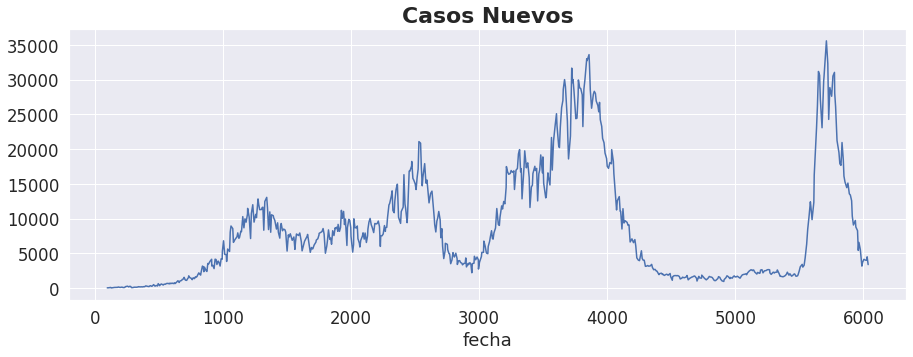

In [712]:
plt.figure(figsize=(15,5))
plt.plot(datos_col.new_cases)
plt.title("Casos Nuevos", fontsize= 22, fontweight="bold")
plt.xlabel("fecha")

Text(0.5, 0, 'fecha')

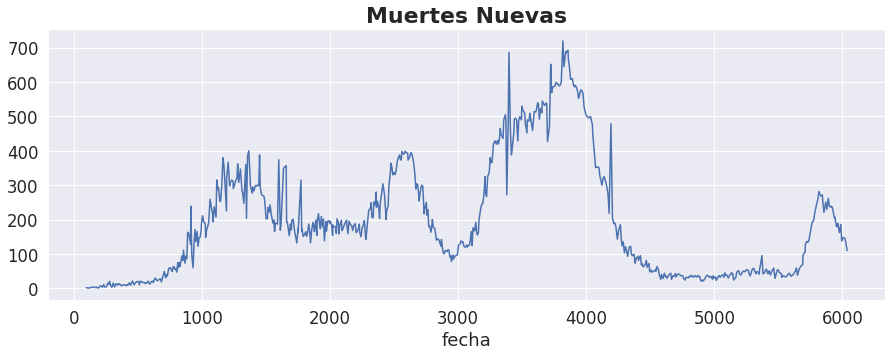

In [703]:
plt.figure(figsize=(15,5))
plt.plot(datos_col.new_deaths)
plt.title("Muertes Nuevas", fontsize= 22, fontweight="bold")
plt.xlabel("fecha")

Text(0.5, 0, 'fecha')

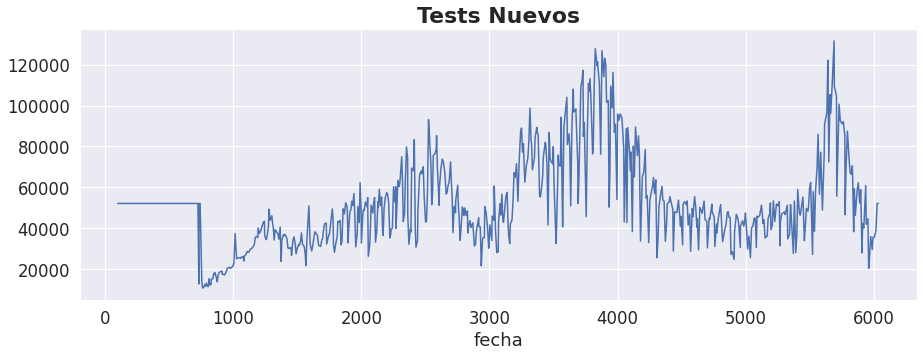

In [704]:
plt.figure(figsize=(15,5))
plt.plot(datos_col.new_tests)
plt.title("Tests Nuevos", fontsize= 22, fontweight="bold")
plt.xlabel("fecha")

In [713]:
fecha_si = datos_col.loc[(datos_col['date'] >= '2020-05-15') & (datos_col['date'] <= '2020-06-04')]
fecha_no = datos_col.loc[(datos_col['date'] >= '2020-11-01') & (datos_col['date'] <= '2020-12-09')]
datos_col = pd.concat([fecha_si, fecha_no], axis=0)
datos_col

new_cases  new_deaths     new_tests       date
581       606.0        21.0  52163.312804 2020-05-15
587       723.0        16.0  52163.312804 2020-05-16
593       635.0        12.0  52163.312804 2020-05-17
603       721.0        18.0  52163.312804 2020-05-18
613       640.0        21.0  52163.312804 2020-05-19
621       752.0        17.0  52163.312804 2020-05-20
625       643.0        22.0  52163.312804 2020-05-21
636       801.0        30.0  52163.312804 2020-05-22
648      1046.0        23.0  52163.312804 2020-05-23
653       998.0        22.0  52163.312804 2020-05-24
658       806.0        23.0  52163.312804 2020-05-25
665      1022.0        26.0  52163.312804 2020-05-26
678      1101.0        27.0  52163.312804 2020-05-27
683      1262.0        19.0  52163.312804 2020-05-28
693      1322.0        31.0  52163.312804 2020-05-29
697      1548.0        37.0  52163.312804 2020-05-30
707      1147.0        49.0  52163.312804 2020-05-31
717      1110.0        30.0  52163.312804 2020-06-01
724      1340.0        40.0  52163.312804 2020-06-02
731      1521.0        36.0  12820.000000 2020-06-03
733      1766.0        42.0  52163.312804 2020-06-04
1949     9137.0       201.0  45575.000000 2020-11-01
1956     9935.0       138.0  30955.000000 2020-11-02
1968     6136.0       194.0  38051.000000 2020-11-03
1972     8694.0       166.0  50685.000000 2020-11-04
1983     9891.0       196.0  42835.000000 2020-11-05
1990     9756.0       196.0  62426.000000 2020-11-06
1998     8714.0       190.0  48532.000000 2020-11-07
2000     7440.0       196.0  32807.000000 2020-11-08
2013     5177.0       183.0  48464.000000 2020-11-09
2020     6292.0       154.0  49316.000000 2020-11-10
2022     9970.0       184.0  48623.000000 2020-11-11
2031     8686.0       179.0  52784.000000 2020-11-12
2045     8685.0       178.0  50500.000000 2020-11-13
2049     8937.0       160.0  55026.000000 2020-11-14
2054     7112.0       202.0  26349.000000 2020-11-15
2065     6471.0       192.0  31868.000000 2020-11-16
2069     5911.0       158.0  37790.000000 2020-11-17
2076     6875.0       182.0  51296.000000 2020-11-18
2089     7487.0       198.0  47427.000000 2020-11-19
2094     7954.0       168.0  51453.000000 2020-11-20
2103     7049.0       175.0  55067.000000 2020-11-21
2110     7924.0       183.0  33247.000000 2020-11-22
2120     6562.0       192.0  38638.000000 2020-11-23
2129     7515.0       198.0  53096.000000 2020-11-24
2132     8497.0       183.0  50120.000000 2020-11-25
2140     9496.0       159.0  59047.000000 2020-11-26
2149    10023.0       195.0  51087.000000 2020-11-27
2158     9103.0       187.0  55304.000000 2020-11-28
2165     8763.0       183.0  40115.000000 2020-11-29
2170     8430.0       182.0  36510.000000 2020-11-30
2177     7986.0       168.0  49610.000000 2020-12-01
2186     9297.0       183.0  54843.000000 2020-12-02
2197     9233.0       188.0  57462.000000 2020-12-03
2204     9285.0       162.0  56800.000000 2020-12-04
2213     9642.0       166.0  52663.000000 2020-12-05
2222     8854.0       175.0  35345.000000 2020-12-06
2229     5997.0       187.0  37016.000000 2020-12-07
2232     7510.0       163.0  39526.000000 2020-12-08
2242     7523.0       150.0  40096.000000 2020-12-09

In [714]:
datos_col['mascarilla'] = np.where((datos_col['date'] >= '2020-05-15') & (datos_col['date'] <= '2020-06-04'),1,0)
datos_col.head()

new_cases  new_deaths     new_tests       date  mascarilla
581      606.0        21.0  52163.312804 2020-05-15           1
587      723.0        16.0  52163.312804 2020-05-16           1
593      635.0        12.0  52163.312804 2020-05-17           1
603      721.0        18.0  52163.312804 2020-05-18           1
613      640.0        21.0  52163.312804 2020-05-19           1

In [716]:
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=42)

In [717]:
X = datos_col[['new_cases', 'new_deaths', 'new_tests']]
y = datos_col['mascarilla']

In [720]:
# aplicamos el modelo de regresion logistica
reglog = LogisticRegression()

In [722]:
# entrenamos el modelo con los datos de entrenamiento
reglog = reglog.fit(X_train,y_train)

In [723]:
score = reglog.score(X_test, y_test)
predict = reglog.predict(X_test)

In [724]:
y_train_pred = reglog.predict(X_train)
y_test_pred = reglog.predict(X_test)

In [725]:
print('La precisión del modelo es de', score)

La precisión del modelo es de 0.5971062882582081


In [726]:
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print('Porcentaje de aciertos sobre el set de entrenamiento:', train_acc)
print('Porcentaje de aciertos sobre el set de evaluación:',test_acc)

Porcentaje de aciertos sobre el set de entrenamiento: 0.6009546539379474
Porcentaje de aciertos sobre el set de evaluación: 0.5971062882582081


In [727]:
from sklearn.metrics import confusion_matrix
matriz = confusion_matrix(y_test, y_test_pred)
print('Matriz de Confusión:')
print(matriz)

Matriz de Confusión:
[[198 578]
 [146 875]]


In [728]:
nuevos_casos_col = datos_col[['mascarilla', 'new_cases']].groupby('mascarilla', as_index = False).sum().sort_values('new_cases', ascending = False)
nuevos_casos_col

mascarilla  new_cases
0           0   317949.0
1           1    21510.0

In [729]:
nuevas_muertes_col = datos_col[['mascarilla', 'new_deaths']].groupby('mascarilla', as_index = False).sum().sort_values('new_deaths', ascending = False)
nuevas_muertes_col

mascarilla  new_deaths
0           0      6994.0
1           1       562.0

In [730]:
nuevos_tests_col = datos_col[['mascarilla', 'new_tests']].groupby('mascarilla', as_index = False).sum().sort_values('new_tests', ascending = False)
nuevos_tests_col

mascarilla     new_tests
0           0  1.798354e+06
1           1  1.056086e+06

In [731]:
indicadores_col = pd.concat([nuevos_casos_col, nuevas_muertes_col, nuevos_tests_col])

Observamos que en los rangos de fechas donde se aplicó como medida sanitaria el uso de la mascarilla, los indicadores disminuyeron, es decir que fue efectiva.

# **PAIS 2: MEXICO**

In [733]:
datos_mex = datos2[(datos2['pais']=='Mexico')]
datos_mex

pais  total_cases  new_cases  total_deaths  new_deaths  \
80    Mexico        164.0       46.0           1.0         1.0   
88    Mexico        203.0       39.0           2.0         1.0   
102   Mexico        316.0       65.0           3.0         1.0   
105   Mexico        367.0       51.0           4.0         1.0   
118   Mexico        405.0       38.0           5.0         1.0   
...      ...          ...        ...           ...         ...   
5999  Mexico    5300537.0     7831.0      312965.0       146.0   
6007  Mexico    5344840.0    44303.0      314128.0      1163.0   
6014  Mexico    5366405.0    21565.0      314598.0       470.0   
6031  Mexico    5407711.0    41306.0      315525.0       927.0   
6043  Mexico    5413425.0     5714.0      315688.0       163.0   

      reproduction_rate     new_tests   total_tests  positive_rate  \
80             1.910000    840.000000  1.683800e+04       0.167000   
88             1.900000    758.000000  1.759600e+04       0.170000   
102            1.890000    415.000000  1.850600e+04       0.168000   
105            1.880000   1087.000000  1.959300e+04       0.162000   
118            1.870000   1371.000000  2.096400e+04       0.164000   
...                 ...           ...           ...            ...   
5999           0.890000  12883.000000  1.412837e+07       0.514000   
6007           0.880000   7103.000000  1.413548e+07       0.502000   
6014           0.870000  19781.202723  5.216607e+06       0.353685   
6031           1.099079  19781.202723  5.216607e+06       0.353685   
6043           1.099079  19781.202723  5.216607e+06       0.353685   

       population  population_density  median_age  aged_65_older       date  
80    130262220.0              66.444        29.3          6.857 2020-03-19  
88    130262220.0              66.444        29.3          6.857 2020-03-20  
102   130262220.0              66.444        29.3          6.857 2020-03-22  
105   130262220.0              66.444        29.3          6.857 2020-03-23  
118   130262220.0              66.444        29.3          6.857 2020-03-24  
...           ...                 ...         ...            ...        ...  
5999  130262220.0              66.444        29.3          6.857 2022-02-15  
6007  130262220.0              66.444        29.3          6.857 2022-02-16  
6014  130262220.0              66.444        29.3          6.857 2022-02-17  
6031  130262220.0              66.444        29.3          6.857 2022-02-19  
6043  130262220.0              66.444        29.3          6.857 2022-02-20  

[664 rows x 14 columns]

Eliminamos las columnas que toman siempre el mismo valor... esto sucede ya que nos quedamos sólo con los datos de Mexico, y eliminamos tambien las columnas que no vamos a usar asi reducimos el dataset.

In [734]:
datos_mex = datos_mex.drop(columns=['pais', 'population', 'population_density', 'aged_65_older', 'median_age', 'total_cases', 'total_deaths', 
                                    'total_tests', 'reproduction_rate', 'positive_rate'])
datos_mex.head(5)

new_cases  new_deaths  new_tests       date
80        46.0         1.0      840.0 2020-03-19
88        39.0         1.0      758.0 2020-03-20
102       65.0         1.0      415.0 2020-03-22
105       51.0         1.0     1087.0 2020-03-23
118       38.0         1.0     1371.0 2020-03-24

Text(0.5, 0, 'fecha')

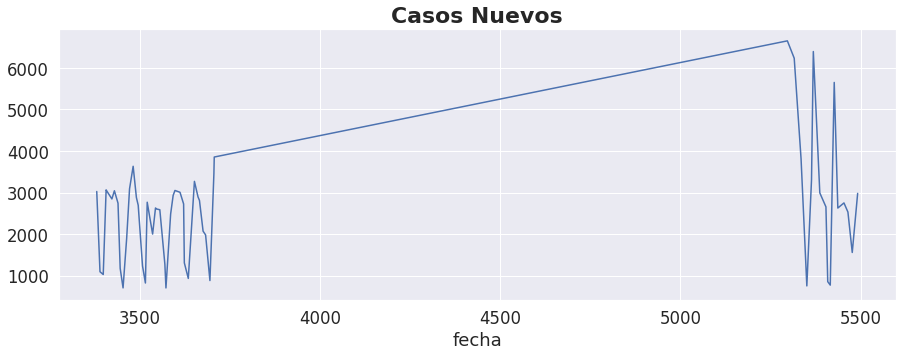

In [751]:
plt.figure(figsize=(15,5))
plt.plot(datos_mex.new_cases)
plt.title("Casos Nuevos", fontsize= 22, fontweight="bold")
plt.xlabel("fecha")

Text(0.5, 0, 'fecha')

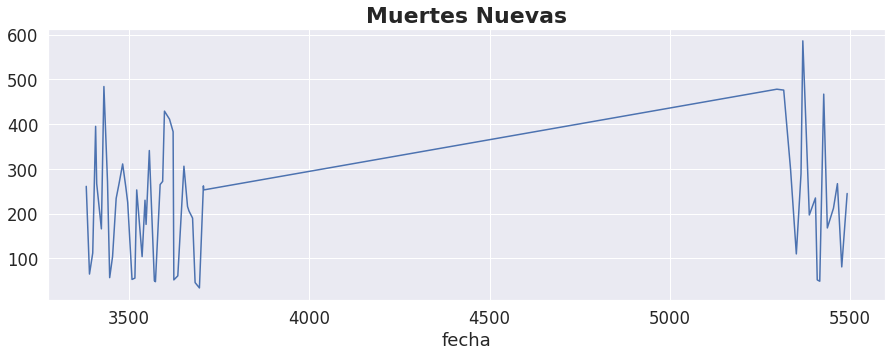

In [752]:
plt.figure(figsize=(15,5))
plt.plot(datos_mex.new_deaths)
plt.title("Muertes Nuevas", fontsize= 22, fontweight="bold")
plt.xlabel("fecha")

Text(0.5, 0, 'fecha')

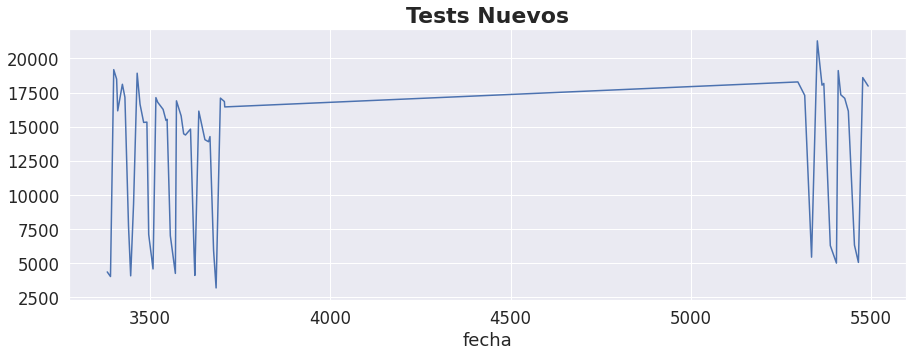

In [753]:
plt.figure(figsize=(15,5))
plt.plot(datos_mex.new_tests)
plt.title("Tests Nuevos", fontsize= 22, fontweight="bold")
plt.xlabel("fecha")

In [735]:
fecha_si = datos_mex.loc[(datos_mex['date'] >= '2021-05-01') & (datos_mex['date'] <= '2021-06-09')]
fecha_no = datos_mex.loc[(datos_mex['date'] >= '2021-12-01') & (datos_mex['date'] <= '2021-12-22')]
datos_mex = pd.concat([fecha_si, fecha_no], axis=0)
datos_mex

new_cases  new_deaths  new_tests       date
3381     3025.0       261.0     4350.0 2021-05-01
3390     1093.0        65.0     4012.0 2021-05-02
3399     1027.0       112.0    19179.0 2021-05-03
3407     3064.0       395.0    18485.0 2021-05-04
3410     3021.0       267.0    16158.0 2021-05-05
3423     2846.0       166.0    18106.0 2021-05-06
3430     3043.0       484.0    17153.0 2021-05-07
3440     2743.0       271.0     7717.0 2021-05-08
3446     1175.0        57.0     4063.0 2021-05-09
3454      704.0       104.0     9320.0 2021-05-10
3464     1897.0       234.0    18917.0 2021-05-11
3472     3090.0       267.0    16637.0 2021-05-12
3482     3632.0       311.0    15309.0 2021-05-13
3491     2880.0       258.0    15332.0 2021-05-14
3496     2695.0       225.0     7099.0 2021-05-15
3508     1233.0        53.0     4568.0 2021-05-16
3516      822.0        56.0    17127.0 2021-05-17
3521     2767.0       253.0    16787.0 2021-05-18
3536     2000.0       104.0    16264.0 2021-05-19
3544     2628.0       230.0    15452.0 2021-05-20
3547     2604.0       176.0    15536.0 2021-05-21
3556     2586.0       341.0     7005.0 2021-05-22
3570     1274.0        50.0     4240.0 2021-05-23
3573      703.0        48.0    16892.0 2021-05-24
3586     2483.0       265.0    15787.0 2021-05-25
3593     2932.0       272.0    14475.0 2021-05-26
3598     3050.0       429.0    14387.0 2021-05-27
3612     3006.0       411.0    14819.0 2021-05-28
3622     2725.0       383.0     5647.0 2021-05-29
3624     1307.0        52.0     4093.0 2021-05-30
3635      932.0        61.0    16139.0 2021-05-31
3652     3269.0       306.0    14045.0 2021-06-02
3662     2894.0       216.0    13894.0 2021-06-03
3666     2809.0       206.0    14271.0 2021-06-04
3676     2071.0       190.0     5928.0 2021-06-05
3683     1979.0        46.0     3175.0 2021-06-06
3695      881.0        34.0    17092.0 2021-06-07
3706     3449.0       262.0    16842.0 2021-06-08
3707     3855.0       253.0    16446.0 2021-06-09
5297     6652.0       478.0    18278.0 2021-12-01
5316     6234.0       476.0    17292.0 2021-12-03
5335     3811.0       299.0     5431.0 2021-12-05
5351      752.0       110.0    21289.0 2021-12-06
5364     3304.0       289.0    18042.0 2021-12-08
5369     6395.0       586.0    18167.0 2021-12-09
5387     2992.0       197.0     6281.0 2021-12-11
5404     2655.0       235.0     4997.0 2021-12-12
5409      855.0        52.0    19109.0 2021-12-13
5416      771.0        49.0    17338.0 2021-12-14
5427     5651.0       467.0    17078.0 2021-12-15
5437     2627.0       168.0    16140.0 2021-12-16
5454     2750.0       212.0     6317.0 2021-12-18
5465     2530.0       267.0     5047.0 2021-12-19
5477     1557.0        81.0    18596.0 2021-12-20
5492     2980.0       245.0    17973.0 2021-12-22

In [736]:
datos_mex['mascarilla'] = np.where((datos_mex['date'] >= '2021-05-01') & (datos_mex['date'] <= '2021-06-09'),1,0)
datos_mex.head()

new_cases  new_deaths  new_tests       date  mascarilla
3381     3025.0       261.0     4350.0 2021-05-01           1
3390     1093.0        65.0     4012.0 2021-05-02           1
3399     1027.0       112.0    19179.0 2021-05-03           1
3407     3064.0       395.0    18485.0 2021-05-04           1
3410     3021.0       267.0    16158.0 2021-05-05           1

In [737]:
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=42)

In [738]:
X = datos_mex[['new_cases', 'new_deaths', 'new_tests']]
y = datos_mex['mascarilla']

In [739]:
# aplicamos el modelo de regresion logistica
reglog = LogisticRegression()

In [740]:
# entrenamos el modelo con los datos de entrenamiento
reglog = reglog.fit(X_train,y_train)

In [741]:
score = reglog.score(X_test, y_test)
predict = reglog.predict(X_test)

In [742]:
y_train_pred = reglog.predict(X_train)
y_test_pred = reglog.predict(X_test)

In [743]:
print('La precisión del modelo es de', score)

La precisión del modelo es de 1.0


In [744]:
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print('Porcentaje de aciertos sobre el set de entrenamiento:', train_acc)
print('Porcentaje de aciertos sobre el set de evaluación:',test_acc)

Porcentaje de aciertos sobre el set de entrenamiento: 1.0
Porcentaje de aciertos sobre el set de evaluación: 1.0


In [745]:
from sklearn.metrics import confusion_matrix
matriz = confusion_matrix(y_test, y_test_pred)
print('Matriz de Confusión:')
print(matriz)

Matriz de Confusión:
[[10  0]
 [ 0  8]]


In [747]:
nuevos_casos_mex = datos_mex[['mascarilla', 'new_cases']].groupby('mascarilla', as_index = False).sum().sort_values('new_cases', ascending = False)
nuevos_casos_mex

mascarilla  new_cases
1           1    90194.0
0           0    52516.0

In [748]:
nuevas_muertes_mex = datos_mex[['mascarilla', 'new_deaths']].groupby('mascarilla', as_index = False).sum().sort_values('new_deaths', ascending = False)
nuevas_muertes_mex

mascarilla  new_deaths
1           1      8174.0
0           0      4211.0

In [749]:
nuevos_tests_mex = datos_mex[['mascarilla', 'new_tests']].groupby('mascarilla', as_index = False).sum().sort_values('new_tests', ascending = False)
nuevos_tests_mex

mascarilla  new_tests
1           1   492748.0
0           0   227375.0

In [750]:
indicadores_mex = pd.concat([nuevos_casos_mex, nuevas_muertes_mex, nuevos_tests_mex])

Observamos que en Mexico, en el rango de fecha donde se aplicó como medida sanitaria el uso de la mascarilla, los indicadores aumentaron, es decir que la medida aplicada no fue efectiva.

# **PAIS 3: BOLIVIA**

In [754]:
datos_bol = datos2[(datos2['pais']=='Bolivia')]
datos_bol

pais  total_cases  new_cases  total_deaths  new_deaths  \
157   Bolivia         81.0        7.0           1.0         1.0   
160   Bolivia         97.0       16.0           4.0         3.0   
173   Bolivia        107.0       10.0           6.0         2.0   
188   Bolivia        115.0        8.0           7.0         1.0   
195   Bolivia        123.0        8.0           8.0         1.0   
...       ...          ...        ...           ...         ...   
5997  Bolivia     886108.0     1104.0       21331.0        17.0   
6008  Bolivia     887089.0      981.0       21342.0        11.0   
6020  Bolivia     888175.0     1086.0       21358.0        16.0   
6032  Bolivia     889044.0      869.0       21367.0         9.0   
6039  Bolivia     889511.0      467.0       21372.0         5.0   

      reproduction_rate    new_tests   total_tests  positive_rate  population  \
157            1.078186  5256.934959  1.118182e+06       0.140400  11832936.0   
160            1.078186  5256.934959  6.970000e+02       0.163900  11832936.0   
173            1.078186    82.000000  7.790000e+02       0.174100  11832936.0   
188            1.240000    57.000000  8.360000e+02       0.185300  11832936.0   
195            1.240000  5256.934959  1.118182e+06       0.150400  11832936.0   
...                 ...          ...           ...            ...         ...   
5997           0.580000  7945.000000  3.780426e+06       0.195600  11832936.0   
6008           0.580000  8239.000000  3.788665e+06       0.150800  11832936.0   
6020           0.570000  5256.934959  1.118182e+06       0.250716  11832936.0   
6032           1.078186  5256.934959  1.118182e+06       0.250716  11832936.0   
6039           1.078186  5256.934959  1.118182e+06       0.250716  11832936.0   

      population_density  median_age  aged_65_older       date  
157               10.202        25.4          6.704 2020-03-29  
160               10.202        25.4          6.704 2020-03-30  
173               10.202        25.4          6.704 2020-03-31  
188               10.202        25.4          6.704 2020-04-01  
195               10.202        25.4          6.704 2020-04-02  
...                  ...         ...            ...        ...  
5997              10.202        25.4          6.704 2022-02-15  
6008              10.202        25.4          6.704 2022-02-16  
6020              10.202        25.4          6.704 2022-02-18  
6032              10.202        25.4          6.704 2022-02-19  
6039              10.202        25.4          6.704 2022-02-20  

[628 rows x 14 columns]

Eliminamos las columnas que toman siempre el mismo valor... esto sucede ya que nos quedamos sólo con los datos de Bolivia, y eliminamos tambien las columnas que no vamos a usar asi reducimos el dataset.

In [755]:
datos_bol = datos_bol.drop(columns=['pais', 'population', 'population_density', 'aged_65_older', 'median_age', 'total_cases', 'total_deaths', 
                                    'total_tests', 'reproduction_rate', 'positive_rate'])
datos_bol.head(5)

new_cases  new_deaths    new_tests       date
157        7.0         1.0  5256.934959 2020-03-29
160       16.0         3.0  5256.934959 2020-03-30
173       10.0         2.0    82.000000 2020-03-31
188        8.0         1.0    57.000000 2020-04-01
195        8.0         1.0  5256.934959 2020-04-02

Text(0.5, 0, 'fecha')

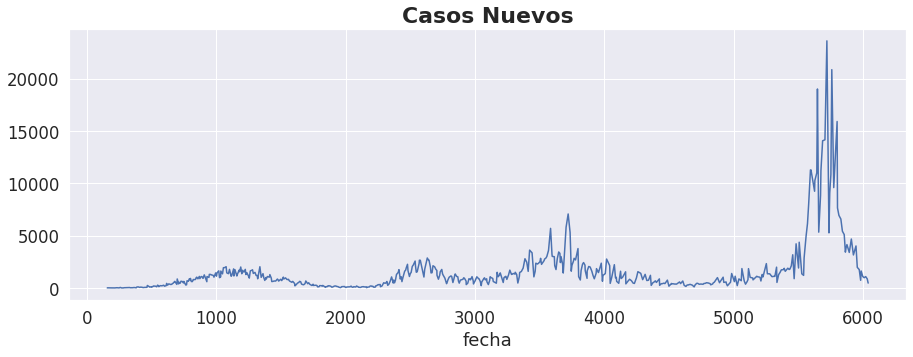

In [756]:
plt.figure(figsize=(15,5))
plt.plot(datos_bol.new_cases)
plt.title("Casos Nuevos", fontsize= 22, fontweight="bold")
plt.xlabel("fecha")

Text(0.5, 0, 'fecha')

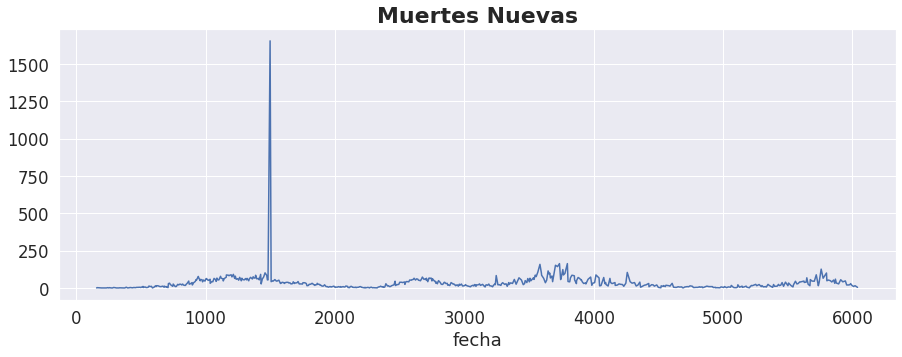

In [757]:
plt.figure(figsize=(15,5))
plt.plot(datos_bol.new_deaths)
plt.title("Muertes Nuevas", fontsize= 22, fontweight="bold")
plt.xlabel("fecha")

Text(0.5, 0, 'fecha')

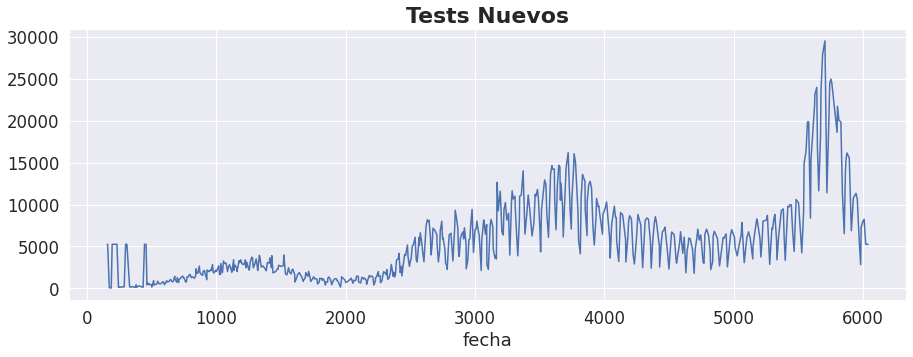

In [758]:
plt.figure(figsize=(15,5))
plt.plot(datos_bol.new_tests)
plt.title("Tests Nuevos", fontsize= 22, fontweight="bold")
plt.xlabel("fecha")

In [759]:
fecha_si = datos_bol.loc[(datos_bol['date'] >= '2021-05-01') & (datos_bol['date'] <= '2021-05-21')]
fecha_no = datos_bol.loc[(datos_bol['date'] >= '2020-08-15') & (datos_bol['date'] <= '2020-09-09')]
datos_bol = pd.concat([fecha_si, fecha_no], axis=0)
datos_bol

new_cases  new_deaths  new_tests       date
3386     2795.0        58.0     6485.0 2021-05-01
3400     2457.0        26.0     8799.0 2021-05-03
3411     1588.0        47.0    11120.0 2021-05-05
3422     3618.0        69.0     9560.0 2021-05-06
3441     3357.0        54.0     6255.0 2021-05-08
3455     1063.0        23.0     7794.0 2021-05-10
3465     1599.0        30.0    11196.0 2021-05-11
3470     2369.0        50.0    10987.0 2021-05-12
3483     2290.0        37.0    11801.0 2021-05-13
3490     2356.0        64.0    10641.0 2021-05-14
3502     2509.0        42.0     6944.0 2021-05-15
3507     2834.0        66.0     4349.0 2021-05-16
3514     2257.0        49.0     9420.0 2021-05-17
3534     2617.0        69.0    12307.0 2021-05-19
3538     2766.0        58.0    12920.0 2021-05-20
3548     2858.0        87.0    12421.0 2021-05-21
1308     1196.0        64.0     3518.0 2020-08-15
1316     1198.0        55.0     2705.0 2020-08-16
1320      879.0        65.0     2133.0 2020-08-17
1333     1796.0        49.0     3948.0 2020-08-18
1337     2031.0        61.0     3711.0 2020-08-19
1347     1015.0        72.0     2555.0 2020-08-20
1361     1370.0        61.0     2674.0 2020-08-21
1367      992.0        76.0     2560.0 2020-08-22
1375      722.0        67.0     2382.0 2020-08-23
1384      999.0        69.0     2219.0 2020-08-24
1386      851.0        86.0     2103.0 2020-08-25
1395     1095.0        62.0     3094.0 2020-08-26
1410     1035.0        65.0     3018.0 2020-08-27
1414     1280.0        55.0     3645.0 2020-08-28
1425      945.0        92.0     2470.0 2020-08-29
1429      614.0        28.0     3902.0 2020-08-30
1438      630.0        61.0     1854.0 2020-08-31
1448      669.0        74.0     1936.0 2020-09-01
1459      661.0       102.0     1996.0 2020-09-02
1472      853.0        85.0     2328.0 2020-09-03
1477      799.0        55.0     2280.0 2020-09-04
1482      661.0        55.0     2769.0 2020-09-05
1498      835.0      1656.0     2616.0 2020-09-07
1506      704.0        43.0     2665.0 2020-09-08
1518     1037.0        49.0     2702.0 2020-09-09

In [760]:
datos_bol['mascarilla'] = np.where((datos_bol['date'] >= '2021-05-01') & (datos_bol['date'] <= '2021-05-21'),1,0)
datos_bol.head()

new_cases  new_deaths  new_tests       date  mascarilla
3386     2795.0        58.0     6485.0 2021-05-01           1
3400     2457.0        26.0     8799.0 2021-05-03           1
3411     1588.0        47.0    11120.0 2021-05-05           1
3422     3618.0        69.0     9560.0 2021-05-06           1
3441     3357.0        54.0     6255.0 2021-05-08           1

In [761]:
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=42)

In [762]:
X = datos_bol[['new_cases', 'new_deaths', 'new_tests']]
y = datos_bol['mascarilla']

In [763]:
# aplicamos el modelo de regresion logistica
reglog = LogisticRegression()

In [764]:
# entrenamos el modelo con los datos de entrenamiento
reglog = reglog.fit(X_train,y_train)

In [765]:
score = reglog.score(X_test, y_test)
predict = reglog.predict(X_test)

In [766]:
y_train_pred = reglog.predict(X_train)
y_test_pred = reglog.predict(X_test)

In [767]:
print('La precisión del modelo es de', score)

La precisión del modelo es de 0.7647058823529411


In [768]:
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print('Porcentaje de aciertos sobre el set de entrenamiento:', train_acc)
print('Porcentaje de aciertos sobre el set de evaluación:',test_acc)

Porcentaje de aciertos sobre el set de entrenamiento: 0.6052631578947368
Porcentaje de aciertos sobre el set de evaluación: 0.7647058823529411


In [769]:
from sklearn.metrics import confusion_matrix
matriz = confusion_matrix(y_test, y_test_pred)
print('Matriz de Confusión:')
print(matriz)

Matriz de Confusión:
[[ 1  3]
 [ 1 12]]


In [771]:
nuevos_casos_bol = datos_bol[['mascarilla', 'new_cases']].groupby('mascarilla', as_index = False).sum().sort_values('new_cases', ascending = False)
nuevos_casos_bol

mascarilla  new_cases
1           1    39333.0
0           0    24867.0

In [772]:
nuevas_muertes_bol = datos_bol[['mascarilla', 'new_deaths']].groupby('mascarilla', as_index = False).sum().sort_values('new_deaths', ascending = False)
nuevas_muertes_bol

mascarilla  new_deaths
0           0      3207.0
1           1       829.0

In [773]:
nuevos_tests_bol = datos_bol[['mascarilla', 'new_tests']].groupby('mascarilla', as_index = False).sum().sort_values('new_tests', ascending = False)
nuevos_tests_bol

mascarilla  new_tests
1           1   152999.0
0           0    67783.0

In [774]:
indicadores_bol = pd.concat([nuevos_casos_bol, nuevas_muertes_bol, nuevos_tests_bol])

En Bolivia, observamos que cuando se usó la mascarilla, los casos nuevos aumentaron al igual que la cantidad de test pero las muertes disminuyeron, es decir que no fue tan efectiva la medida sanitaria.

# **PAIS 4: ESTADOS UNIDOS**

In [779]:
datos_eeuu = datos2[(datos2['pais']=='United States')]
datos_eeuu

pais  total_cases  new_cases  total_deaths  new_deaths  \
10    United States         25.0        8.0           1.0         1.0   
16    United States         55.0       23.0           6.0         5.0   
19    United States         74.0       19.0           7.0         1.0   
22    United States        107.0       33.0          11.0         4.0   
26    United States        184.0       77.0          12.0         1.0   
...             ...          ...        ...           ...         ...   
6009  United States   78174363.0   138174.0      928639.0      3083.0   
6015  United States   78275698.0   101335.0      931862.0      3223.0   
6027  United States   78423525.0   147827.0      934321.0      2459.0   
6033  United States   78457081.0    33556.0      934951.0       630.0   
6042  United States   78479134.0    22053.0      935335.0       384.0   

      reproduction_rate     new_tests   total_tests  positive_rate  \
10             1.114246  1.127088e+06  3.300207e+08       0.088507   
16             1.114246  5.140000e+02  8.620000e+02       0.088507   
19             1.114246  6.200000e+02  1.482000e+03       0.088507   
22             1.114246  8.880000e+02  2.370000e+03       0.088507   
26             3.620000  1.201000e+03  3.571000e+03       0.088507   
...                 ...           ...           ...            ...   
6009           0.540000  1.127088e+06  3.300207e+08       0.088507   
6015           0.550000  1.127088e+06  3.300207e+08       0.088507   
6027           0.560000  1.127088e+06  3.300207e+08       0.088507   
6033           1.114246  1.127088e+06  3.300207e+08       0.088507   
6042           1.114246  1.127088e+06  3.300207e+08       0.088507   

       population  population_density  median_age  aged_65_older       date  
10    332915074.0              35.608        38.3         15.413 2020-02-29  
16    332915074.0              35.608        38.3         15.413 2020-03-02  
19    332915074.0              35.608        38.3         15.413 2020-03-03  
22    332915074.0              35.608        38.3         15.413 2020-03-04  
26    332915074.0              35.608        38.3         15.413 2020-03-05  
...           ...                 ...         ...            ...        ...  
6009  332915074.0              35.608        38.3         15.413 2022-02-16  
6015  332915074.0              35.608        38.3         15.413 2022-02-17  
6027  332915074.0              35.608        38.3         15.413 2022-02-18  
6033  332915074.0              35.608        38.3         15.413 2022-02-19  
6042  332915074.0              35.608        38.3         15.413 2022-02-20  

[722 rows x 14 columns]

Eliminamos las columnas que toman siempre el mismo valor... esto sucede ya que nos quedamos sólo con los datos de Estados Unidos, eliminamos tambien las columnas que no vamos a usar asi reducimos el dataset.

In [780]:
datos_eeuu = datos_eeuu.drop(columns=['pais', 'population', 'population_density', 'aged_65_older', 'median_age', 'total_cases', 'total_deaths', 
                                    'total_tests', 'reproduction_rate', 'positive_rate'])
datos_eeuu.head(5)

new_cases  new_deaths     new_tests       date
10        8.0         1.0  1.127088e+06 2020-02-29
16       23.0         5.0  5.140000e+02 2020-03-02
19       19.0         1.0  6.200000e+02 2020-03-03
22       33.0         4.0  8.880000e+02 2020-03-04
26       77.0         1.0  1.201000e+03 2020-03-05

Text(0.5, 0, 'fecha')

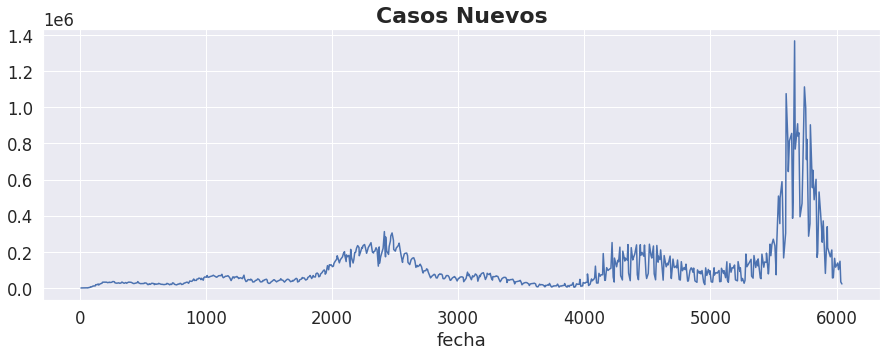

In [781]:
plt.figure(figsize=(15,5))
plt.plot(datos_eeuu.new_cases)
plt.title("Casos Nuevos", fontsize= 22, fontweight="bold")
plt.xlabel("fecha")

Text(0.5, 0, 'fecha')

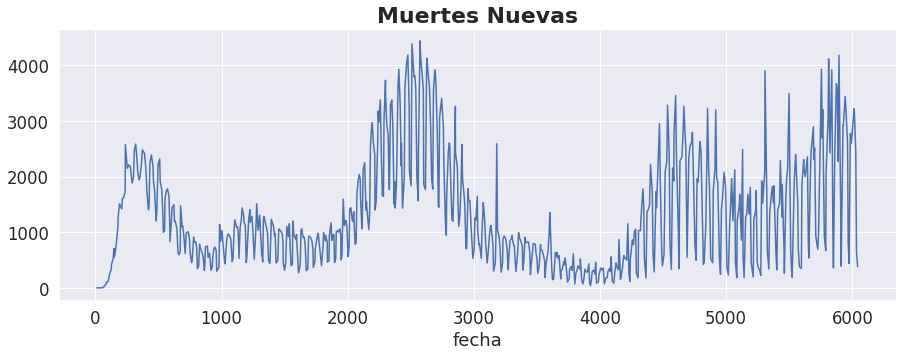

In [782]:
plt.figure(figsize=(15,5))
plt.plot(datos_eeuu.new_deaths)
plt.title("Muertes Nuevas", fontsize= 22, fontweight="bold")
plt.xlabel("fecha")

Text(0.5, 0, 'fecha')

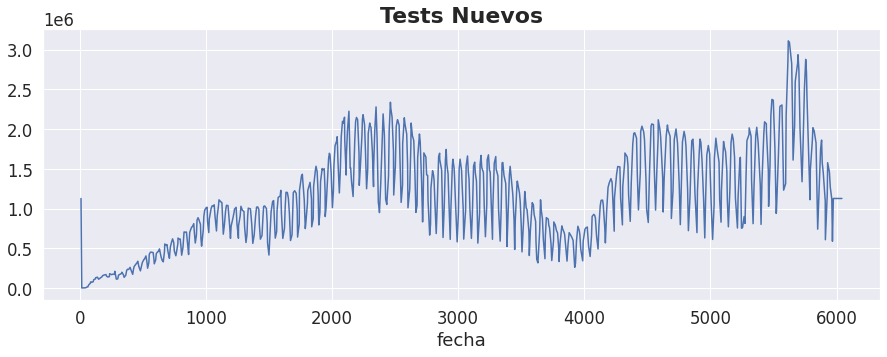

In [783]:
plt.figure(figsize=(15,5))
plt.plot(datos_eeuu.new_tests)
plt.title("Tests Nuevos", fontsize= 22, fontweight="bold")
plt.xlabel("fecha")

In [784]:
fecha_si = datos_eeuu.loc[(datos_eeuu['date'] >= '2020-11-01') & (datos_eeuu['date'] <= '2020-11-22')]
fecha_no = datos_eeuu.loc[(datos_eeuu['date'] >= '2021-08-15') & (datos_eeuu['date'] <= '2021-09-09')]
datos_eeuu = pd.concat([fecha_si, fecha_no], axis=0)
datos_eeuu

new_cases  new_deaths  new_tests       date
1946    76273.0       503.0   899680.0 2020-11-01
1953    82843.0       557.0  1016881.0 2020-11-02
1964   123529.0      1597.0  1364803.0 2020-11-03
1973   100616.0      1120.0  1632655.0 2020-11-04
1979   128375.0      1165.0  1696353.0 2020-11-05
1984   124960.0      1214.0  1677633.0 2020-11-06
1993   128463.0      1117.0  1455833.0 2020-11-07
2003   117900.0       563.0  1011173.0 2020-11-08
2011   120564.0       759.0  1224196.0 2020-11-09
2015   135273.0      1416.0  1538961.0 2020-11-10
2024   146661.0      1443.0  1791455.0 2020-11-11
2037   159291.0      1204.0  1853920.0 2020-11-12
2041   178116.0      1200.0  1904634.0 2020-11-13
2047   165250.0      1373.0  1598396.0 2020-11-14
2058   138939.0       788.0  1197153.0 2020-11-15
2066   156341.0       814.0  1492400.0 2020-11-16
2073   162596.0      1709.0  1905355.0 2020-11-17
2083   172201.0      1942.0  2099154.0 2020-11-18
2091   192101.0      2042.0  2076435.0 2020-11-19
2099   200945.0      1949.0  2150326.0 2020-11-20
2101   181157.0      1638.0  1856659.0 2020-11-21
2112   146052.0      1061.0  1422352.0 2020-11-22
4302    44035.0       185.0   794723.0 2021-08-15
4305   203799.0      1037.0  1279895.0 2021-08-16
4321   148804.0      1029.0  1606381.0 2021-08-17
4322   166567.0      1175.0  1700052.0 2021-08-18
4340   154372.0      1781.0  1650634.0 2021-08-19
4346   240002.0      1479.0  1543775.0 2021-08-20
4351    82491.0       552.0  1175877.0 2021-08-21
4364    40147.0       179.0   839299.0 2021-08-22
4372   223018.0      1361.0  1320811.0 2021-08-23
4384   155058.0      1422.0  1810535.0 2021-08-24
4392   172419.0      1490.0  1947644.0 2021-08-25
4400   187652.0      2221.0  1954451.0 2021-08-26
4414   238455.0      1723.0  1886311.0 2021-08-27
4420    72876.0       633.0  1437190.0 2021-08-28
4429    45605.0       289.0   983858.0 2021-08-29
4444   239512.0      1733.0  1459018.0 2021-08-30
4447   180246.0      1443.0  1972391.0 2021-08-31
4457   196632.0      2034.0  2037899.0 2021-09-01
4471   175841.0      2953.0  1963529.0 2021-09-02
4477   237301.0      1969.0  1867305.0 2021-09-03
4489    77116.0       635.0  1355929.0 2021-09-04
4494    52220.0       396.0   992657.0 2021-09-05
4507    80525.0       599.0   824799.0 2021-09-06
4516   242228.0      2080.0  1403075.0 2021-09-07
4529   177900.0      2279.0  2036406.0 2021-09-08
4535   165411.0      3284.0  2065663.0 2021-09-09

In [785]:
datos_eeuu['mascarilla'] = np.where((datos_eeuu['date'] >= '2020-11-01') & (datos_eeuu['date'] <= '2020-11-22'),1,0)
datos_eeuu.head()

new_cases  new_deaths  new_tests       date  mascarilla
1946    76273.0       503.0   899680.0 2020-11-01           1
1953    82843.0       557.0  1016881.0 2020-11-02           1
1964   123529.0      1597.0  1364803.0 2020-11-03           1
1973   100616.0      1120.0  1632655.0 2020-11-04           1
1979   128375.0      1165.0  1696353.0 2020-11-05           1

In [786]:
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=42)

In [787]:
X = datos_eeuu[['new_cases', 'new_deaths', 'new_tests']]
y = datos_eeuu['mascarilla']

In [788]:
# aplicamos el modelo de regresion logistica
reglog = LogisticRegression()

In [789]:
# entrenamos el modelo con los datos de entrenamiento
reglog = reglog.fit(X_train,y_train)

In [790]:
score = reglog.score(X_test, y_test)
predict = reglog.predict(X_test)

In [791]:
y_train_pred = reglog.predict(X_train)
y_test_pred = reglog.predict(X_test)

In [792]:
print('La precisión del modelo es de', score)

La precisión del modelo es de 1.0


In [793]:
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print('Porcentaje de aciertos sobre el set de entrenamiento:', train_acc)
print('Porcentaje de aciertos sobre el set de evaluación:',test_acc)

Porcentaje de aciertos sobre el set de entrenamiento: 1.0
Porcentaje de aciertos sobre el set de evaluación: 1.0


In [794]:
from sklearn.metrics import confusion_matrix
matriz = confusion_matrix(y_test, y_test_pred)
print('Matriz de Confusión:')
print(matriz)

Matriz de Confusión:
[[8 0]
 [0 5]]


In [796]:
nuevos_casos_eeuu = datos_eeuu[['mascarilla', 'new_cases']].groupby('mascarilla', as_index = False).sum().sort_values('new_cases', ascending = False)
nuevos_casos_eeuu

mascarilla  new_cases
0           0  4000232.0
1           1  3138446.0

In [797]:
nuevas_muertes_eeuu = datos_eeuu[['mascarilla', 'new_deaths']].groupby('mascarilla', as_index = False).sum().sort_values('new_deaths', ascending = False)
nuevas_muertes_eeuu

mascarilla  new_deaths
0           0     35961.0
1           1     27174.0

In [798]:
nuevos_tests_eeuu = datos_eeuu[['mascarilla', 'new_tests']].groupby('mascarilla', as_index = False).sum().sort_values('new_tests', ascending = False)
nuevos_tests_eeuu

mascarilla   new_tests
0           0  39910107.0
1           1  34866407.0

In [799]:
indicadores_eeuu = pd.concat([nuevos_casos_eeuu, nuevas_muertes_eeuu, nuevos_tests_eeuu])

Observamos que en EEUU, en los rangos de fechas donde se aplicó como medida sanitaria el uso de la mascarilla, los indicadores disminuyeron, es decir que fue efectiva.

# **PAIS 5: AUSTRALIA**

In [800]:
datos_aus = datos2[(datos2['pais']=='Australia')]
datos_aus

pais  total_cases  new_cases  total_deaths  new_deaths  \
12    Australia         27.0        2.0           1.0         1.0   
23    Australia         52.0       13.0           2.0         1.0   
37    Australia         76.0       13.0           3.0         1.0   
71    Australia        452.0       75.0           5.0         2.0   
76    Australia        568.0      116.0           6.0         1.0   
...         ...          ...        ...           ...         ...   
5993  Australia    2969890.0    24394.0        4726.0        62.0   
6011  Australia    2990045.0    22729.0        4833.0        36.0   
6022  Australia    3013262.0    23217.0        4878.0        45.0   
6030  Australia    3030638.0    17376.0        4912.0        34.0   
6044  Australia    3048857.0    18219.0        4929.0        17.0   

      reproduction_rate      new_tests   total_tests  positive_rate  \
12             1.077826  126367.080925  2.784790e+07       0.048026   
23             1.077826  126367.080925  2.784790e+07       0.048026   
37             1.077826     420.000000  7.216000e+03       0.048026   
71             2.400000    6487.000000  5.105700e+04       0.008200   
76             2.440000    7017.000000  5.807400e+04       0.009200   
...                 ...            ...           ...            ...   
5993           0.850000   57711.000000  6.244814e+07       0.267100   
6011           0.870000  105258.000000  6.265636e+07       0.229100   
6022           0.880000   89883.000000  6.274625e+07       0.048026   
6030           1.077826  126367.080925  2.784790e+07       0.048026   
6044           1.077826  126367.080925  2.784790e+07       0.048026   

      population  population_density  median_age  aged_65_older       date  
12    25788217.0               3.202        37.9         15.504 2020-03-01  
23    25788217.0               3.202        37.9         15.504 2020-03-04  
37    25788217.0               3.202        37.9         15.504 2020-03-08  
71    25788217.0               3.202        37.9         15.504 2020-03-17  
76    25788217.0               3.202        37.9         15.504 2020-03-18  
...          ...                 ...         ...            ...        ...  
5993  25788217.0               3.202        37.9         15.504 2022-02-15  
6011  25788217.0               3.202        37.9         15.504 2022-02-17  
6022  25788217.0               3.202        37.9         15.504 2022-02-18  
6030  25788217.0               3.202        37.9         15.504 2022-02-19  
6044  25788217.0               3.202        37.9         15.504 2022-02-20  

[350 rows x 14 columns]

Eliminamos las columnas que toman siempre el mismo valor... esto sucede ya que nos quedamos sólo con los datos de Australia, y eliminamos tambien las columnas que no vamos a usar asi reducimos el dataset.

In [801]:
datos_aus = datos_aus.drop(columns=['pais', 'population', 'population_density', 'aged_65_older', 'median_age', 'total_cases', 'total_deaths', 
                                    'total_tests', 'reproduction_rate', 'positive_rate'])
datos_aus.head(5)

new_cases  new_deaths      new_tests       date
12        2.0         1.0  126367.080925 2020-03-01
23       13.0         1.0  126367.080925 2020-03-04
37       13.0         1.0     420.000000 2020-03-08
71       75.0         2.0    6487.000000 2020-03-17
76      116.0         1.0    7017.000000 2020-03-18

Text(0.5, 0, 'fecha')

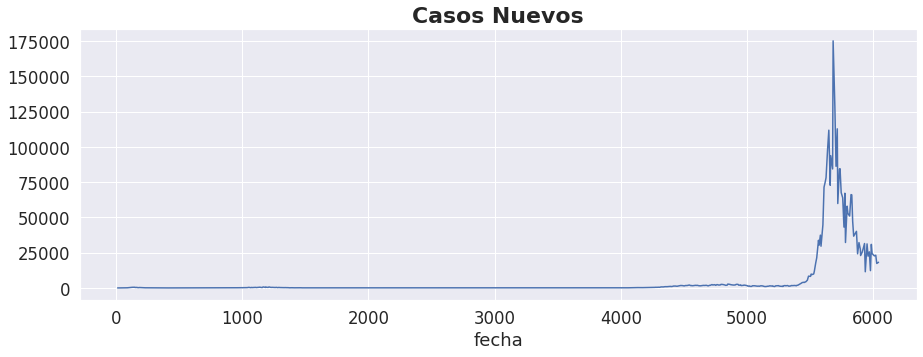

In [802]:
plt.figure(figsize=(15,5))
plt.plot(datos_aus.new_cases)
plt.title("Casos Nuevos", fontsize= 22, fontweight="bold")
plt.xlabel("fecha")

Text(0.5, 0, 'fecha')

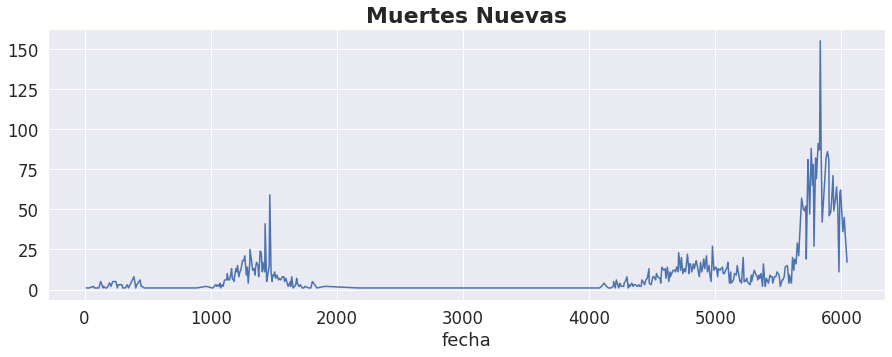

In [803]:
plt.figure(figsize=(15,5))
plt.plot(datos_aus.new_deaths)
plt.title("Muertes Nuevas", fontsize= 22, fontweight="bold")
plt.xlabel("fecha")

Text(0.5, 0, 'fecha')

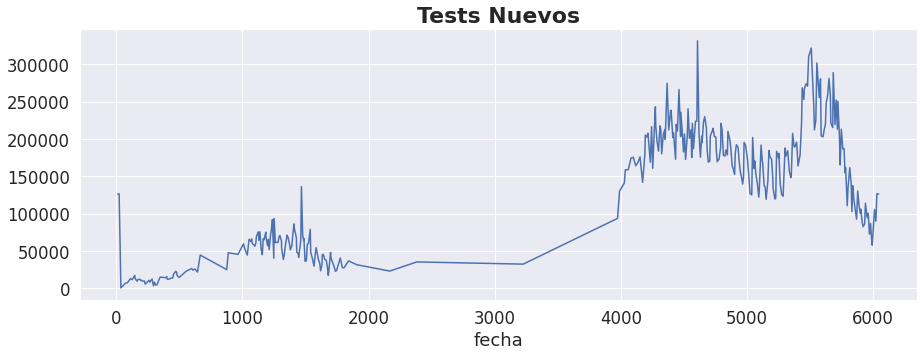

In [804]:
plt.figure(figsize=(15,5))
plt.plot(datos_aus.new_tests)
plt.title("Tests Nuevos", fontsize= 22, fontweight="bold")
plt.xlabel("fecha")

In [805]:
fecha_si = datos_aus.loc[(datos_aus['date'] >= '2020-08-15') & (datos_aus['date'] <= '2020-09-09')]
fecha_si

new_cases  new_deaths  new_tests       date
1310      252.0        17.0    63370.0 2020-08-15
1311      271.0        25.0    53774.0 2020-08-16
1325      215.0        17.0    38539.0 2020-08-17
1332      216.0        12.0    44516.0 2020-08-18
1343      247.0        13.0    59882.0 2020-08-19
1352      171.0         9.0    68336.0 2020-08-20
1354      195.0        13.0    71149.0 2020-08-21
1363      209.0        17.0    67697.0 2020-08-22
1374      104.0        15.0    58910.0 2020-08-23
1380      138.0         8.0    51447.0 2020-08-24
1392      151.0        24.0    56675.0 2020-08-25
1400      118.0        23.0    71703.0 2020-08-26
1409      126.0        11.0    86268.0 2020-08-27
1413       99.0        17.0    79556.0 2020-08-28
1428      123.0        11.0    67555.0 2020-08-29
1431       76.0        41.0    48438.0 2020-08-30
1443       73.0         5.0    46224.0 2020-08-31
1446      104.0         6.0    41379.0 2020-09-01
1463      126.0        15.0    63963.0 2020-09-02
1468       87.0        59.0   136194.0 2020-09-03
1478       71.0        11.0    70961.0 2020-09-04
1487       71.0         5.0    63838.0 2020-09-05
1488       43.0         9.0    66560.0 2020-09-06
1497       52.0         8.0    36086.0 2020-09-07
1507       92.0        11.0    36963.0 2020-09-08
1515       59.0         7.0    58936.0 2020-09-09

In [806]:
fecha_no = datos_aus.loc[(datos_aus['date'] >= '2022-01-08') & (datos_aus['date'] <= '2022-02-15')]
fecha_no

new_cases  new_deaths  new_tests       date
5650   111907.0        29.0   280970.0 2022-01-08
5661    72834.0        21.0   258981.0 2022-01-09
5665    93806.0        28.0   221101.0 2022-01-10
5680    84408.0        50.0   215158.0 2022-01-11
5684   175271.0        57.0   288897.0 2022-01-12
5698   128185.0        50.0   219303.0 2022-01-13
5707    86288.0        49.0   252188.0 2022-01-14
5717   112867.0        52.0   213098.0 2022-01-15
5721    59891.0        19.0   250274.0 2022-01-16
5734    84355.0        81.0   199188.0 2022-01-17
5739    84615.0        70.0   165245.0 2022-01-18
5748    67604.0        47.0   213047.0 2022-01-19
5760    63941.0        88.0   186541.0 2022-01-20
5770    43166.0        65.0   187145.0 2022-01-21
5777    67182.0        78.0   154762.0 2022-01-22
5782    32234.0        27.0   161759.0 2022-01-23
5795    58022.0        82.0   110638.0 2022-01-24
5801    52920.0        69.0   134310.0 2022-01-25
5815    51016.0        91.0   161570.0 2022-01-26
5826    66223.0        87.0   140456.0 2022-01-27
5832    65980.0       155.0   102759.0 2022-01-28
5839    47258.0        86.0   137420.0 2022-01-29
5847    36719.0        42.0   119336.0 2022-01-30
5869    40146.0        70.0    92547.0 2022-02-01
5878    24228.0        82.0   130347.0 2022-02-02
5889    32179.0        86.0   110188.0 2022-02-03
5900    27336.0        81.0   100240.0 2022-02-04
5902    22985.0        46.0   106001.0 2022-02-05
5914    25247.0        48.0    88170.0 2022-02-06
5921    27373.0        54.0    82525.0 2022-02-07
5933    31510.0        71.0    86132.0 2022-02-08
5939    11483.0        49.0   113891.0 2022-02-09
5953    31250.0        57.0    94636.0 2022-02-10
5961    22564.0        64.0   100310.0 2022-02-11
5971    25607.0        50.0    72452.0 2022-02-12
5980    12289.0        11.0    86899.0 2022-02-13
5987    30913.0        60.0    67597.0 2022-02-14
5993    24394.0        62.0    57711.0 2022-02-15

In [807]:
datos_aus = pd.concat([fecha_si, fecha_no], axis=0)
datos_aus

new_cases  new_deaths  new_tests       date
1310      252.0        17.0    63370.0 2020-08-15
1311      271.0        25.0    53774.0 2020-08-16
1325      215.0        17.0    38539.0 2020-08-17
1332      216.0        12.0    44516.0 2020-08-18
1343      247.0        13.0    59882.0 2020-08-19
...         ...         ...        ...        ...
5961    22564.0        64.0   100310.0 2022-02-11
5971    25607.0        50.0    72452.0 2022-02-12
5980    12289.0        11.0    86899.0 2022-02-13
5987    30913.0        60.0    67597.0 2022-02-14
5993    24394.0        62.0    57711.0 2022-02-15

[64 rows x 4 columns]

In [808]:
datos_aus['mascarilla'] = np.where((datos_aus['date'] >= '2020-08-15') & (datos_aus['date'] <= '2020-09-09'),1,0)
datos_aus.head()

new_cases  new_deaths  new_tests       date  mascarilla
1310      252.0        17.0    63370.0 2020-08-15           1
1311      271.0        25.0    53774.0 2020-08-16           1
1325      215.0        17.0    38539.0 2020-08-17           1
1332      216.0        12.0    44516.0 2020-08-18           1
1343      247.0        13.0    59882.0 2020-08-19           1

In [809]:
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=42)

In [810]:
X = datos_aus[['new_cases', 'new_deaths', 'new_tests']]
y = datos_aus['mascarilla']

In [811]:
# aplicamos el modelo de regresion logistica
reglog = LogisticRegression()

In [812]:
# entrenamos el modelo con los datos de entrenamiento
reglog = reglog.fit(X_train,y_train)

In [813]:
score = reglog.score(X_test, y_test)
predict = reglog.predict(X_test)

In [814]:
y_train_pred = reglog.predict(X_train)
y_test_pred = reglog.predict(X_test)

In [815]:
print('La precisión del modelo es de', score)

La precisión del modelo es de 0.7333333333333333


In [816]:
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print('Porcentaje de aciertos sobre el set de entrenamiento:', train_acc)
print('Porcentaje de aciertos sobre el set de evaluación:',test_acc)

Porcentaje de aciertos sobre el set de entrenamiento: 0.48484848484848486
Porcentaje de aciertos sobre el set de evaluación: 0.7333333333333333


In [817]:
from sklearn.metrics import confusion_matrix
matriz = confusion_matrix(y_test, y_test_pred)
print('Matriz de Confusión:')
print(matriz)

Matriz de Confusión:
[[6 3]
 [1 5]]


In [818]:
nuevos_casos_aus = datos_aus[['mascarilla', 'new_cases']].groupby('mascarilla', as_index = False).sum().sort_values('new_cases', ascending = False)
nuevos_casos_aus

mascarilla  new_cases
0           0  2136196.0
1           1     3489.0

In [819]:
nuevas_muertes_aus = datos_aus[['mascarilla', 'new_deaths']].groupby('mascarilla', as_index = False).sum().sort_values('new_deaths', ascending = False)
nuevas_muertes_aus

mascarilla  new_deaths
0           0      2314.0
1           1       409.0

In [820]:
nuevos_tests_aus = datos_aus[['mascarilla', 'new_tests']].groupby('mascarilla', as_index = False).sum().sort_values('new_tests', ascending = False)
nuevos_tests_aus

mascarilla  new_tests
0           0  5763792.0
1           1  1608919.0

In [821]:
indicadores_aus = pd.concat([nuevos_casos_aus, nuevas_muertes_aus, nuevos_tests_aus])

En Australia, observamos que en los rangos de fechas donde se aplicó como medida sanitaria el uso de la mascarilla, los indicadores disminuyeron, es decir que fue efectiva.

# **PAIS 6: PAKISTAN**

In [822]:
datos_pak = datos2[(datos2['pais']=='Pakistan')]
datos_pak

pais  total_cases  new_cases  total_deaths  new_deaths  \
75    Pakistan        454.0      155.0           2.0         2.0   
84    Pakistan        501.0       47.0           3.0         1.0   
95    Pakistan        776.0       46.0           5.0         2.0   
99    Pakistan        875.0       99.0           6.0         1.0   
104   Pakistan        972.0       97.0           7.0         1.0   
...        ...          ...        ...           ...         ...   
6001  Pakistan    1494293.0     2870.0       29917.0        40.0   
6010  Pakistan    1496693.0     2400.0       29950.0        33.0   
6023  Pakistan    1498676.0     1983.0       29976.0        26.0   
6035  Pakistan    1500320.0     1644.0       30009.0        33.0   
6038  Pakistan    1501680.0     1360.0       30040.0        31.0   

      reproduction_rate     new_tests   total_tests  positive_rate  \
75             2.500000   1022.000000  2.163000e+03        0.25620   
84             2.360000   1247.000000  3.410000e+03        0.16440   
95             2.070000   1224.000000  5.225000e+03        0.15910   
99             1.930000    219.000000  5.444000e+03        0.16020   
104            1.820000    413.000000  5.857000e+03        0.15550   
...                 ...           ...           ...            ...   
6001           0.670000  35464.842756  2.589676e+07        0.05530   
6010           0.660000  35464.842756  9.821604e+06        0.05290   
6023           0.660000  35464.842756  2.599718e+07        0.06449   
6035           1.063216  35464.842756  9.821604e+06        0.06449   
6038           1.063216  35464.842756  9.821604e+06        0.06449   

       population  population_density  median_age  aged_65_older       date  
75    225199929.0             255.573        23.5          4.495 2020-03-18  
84    225199929.0             255.573        23.5          4.495 2020-03-19  
95    225199929.0             255.573        23.5          4.495 2020-03-21  
99    225199929.0             255.573        23.5          4.495 2020-03-22  
104   225199929.0             255.573        23.5          4.495 2020-03-23  
...           ...                 ...         ...            ...        ...  
6001  225199929.0             255.573        23.5          4.495 2022-02-16  
6010  225199929.0             255.573        23.5          4.495 2022-02-17  
6023  225199929.0             255.573        23.5          4.495 2022-02-18  
6035  225199929.0             255.573        23.5          4.495 2022-02-19  
6038  225199929.0             255.573        23.5          4.495 2022-02-20  

[686 rows x 14 columns]

Eliminamos las columnas que toman siempre el mismo valor... esto sucede ya que nos quedamos sólo con los datos de Pakistan, y eliminamos tambien las columnas que no vamos a usar asi reducimos el dataset.

In [823]:
datos_pak = datos_pak.drop(columns=['pais', 'population', 'population_density', 'aged_65_older', 'median_age', 'total_cases', 'total_deaths', 
                                    'total_tests', 'reproduction_rate', 'positive_rate'])
datos_pak.head(5)

new_cases  new_deaths  new_tests       date
75       155.0         2.0     1022.0 2020-03-18
84        47.0         1.0     1247.0 2020-03-19
95        46.0         2.0     1224.0 2020-03-21
99        99.0         1.0      219.0 2020-03-22
104       97.0         1.0      413.0 2020-03-23

Text(0.5, 0, 'fecha')

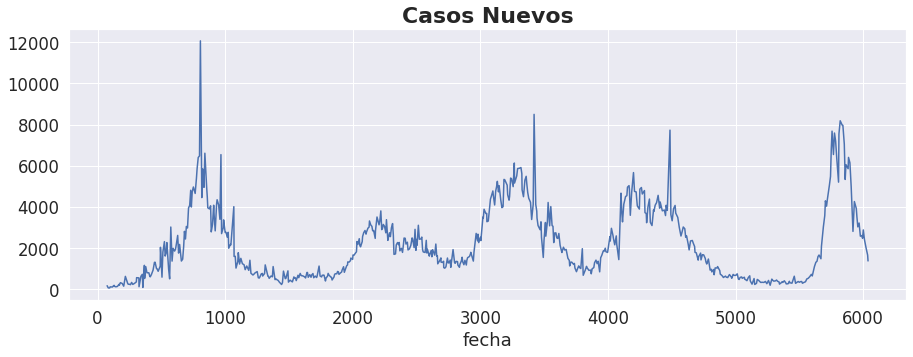

In [824]:
plt.figure(figsize=(15,5))
plt.plot(datos_pak.new_cases)
plt.title("Casos Nuevos", fontsize= 22, fontweight="bold")
plt.xlabel("fecha")

Text(0.5, 0, 'fecha')

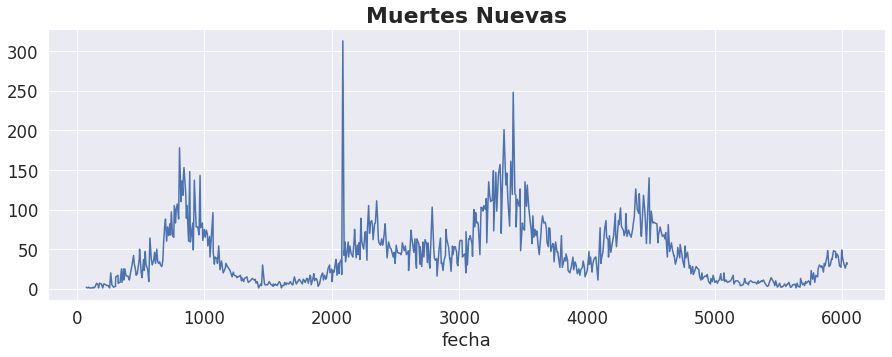

In [825]:
plt.figure(figsize=(15,5))
plt.plot(datos_pak.new_deaths)
plt.title("Muertes Nuevas", fontsize= 22, fontweight="bold")
plt.xlabel("fecha")

Text(0.5, 0, 'fecha')

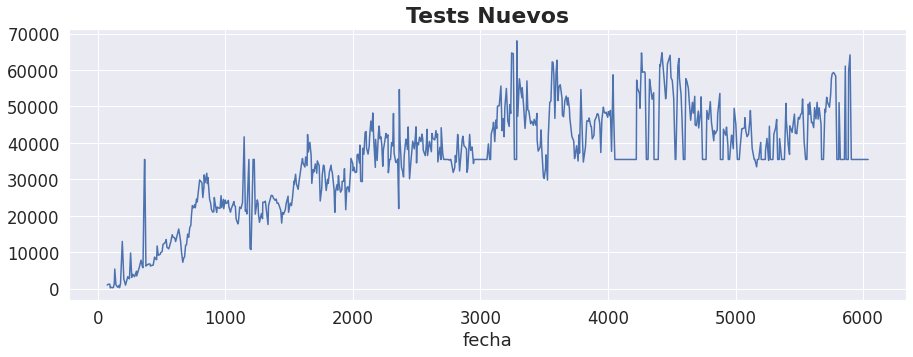

In [826]:
plt.figure(figsize=(15,5))
plt.plot(datos_pak.new_tests)
plt.title("Tests Nuevos", fontsize= 22, fontweight="bold")
plt.xlabel("fecha")

In [827]:
fecha_si = datos_pak.loc[(datos_pak['date'] >= '2020-12-01') & (datos_pak['date'] <= '2020-12-22')]
fecha_no = datos_pak.loc[(datos_pak['date'] >= '2021-08-01') & (datos_pak['date'] <= '2021-09-09')]
datos_pak = pd.concat([fecha_si, fecha_no], axis=0)
datos_pak

new_cases  new_deaths     new_tests       date
2178     2829.0        75.0  40969.000000 2020-12-01
2190     3499.0        39.0  35197.000000 2020-12-02
2200     3262.0        55.0  42563.000000 2020-12-03
2206     3119.0        43.0  44627.000000 2020-12-04
2212     3308.0        58.0  41175.000000 2020-12-05
...         ...         ...           ...        ...
4493     3613.0        57.0  57908.000000 2021-09-05
4503     3316.0        98.0  57131.000000 2021-09-06
4514     3902.0        83.0  52314.000000 2021-09-07
4526     4062.0        84.0  35464.842756 2021-09-08
4531     3689.0        83.0  35464.842756 2021-09-09

[61 rows x 4 columns]

In [828]:
datos_pak['mascarilla'] = np.where((datos_pak['date'] >= '2020-12-01') & (datos_pak['date'] <= '2020-12-22'),1,0)
datos_pak.head()

new_cases  new_deaths  new_tests       date  mascarilla
2178     2829.0        75.0    40969.0 2020-12-01           1
2190     3499.0        39.0    35197.0 2020-12-02           1
2200     3262.0        55.0    42563.0 2020-12-03           1
2206     3119.0        43.0    44627.0 2020-12-04           1
2212     3308.0        58.0    41175.0 2020-12-05           1

In [829]:
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=42)

In [830]:
X = datos_pak[['new_cases', 'new_deaths', 'new_tests']]
y = datos_pak['mascarilla']

In [831]:
# aplicamos el modelo de regresion logistica
reglog = LogisticRegression()

In [832]:
# entrenamos el modelo con los datos de entrenamiento
reglog = reglog.fit(X_train,y_train)

In [833]:
score = reglog.score(X_test, y_test)
predict = reglog.predict(X_test)

In [834]:
y_train_pred = reglog.predict(X_train)
y_test_pred = reglog.predict(X_test)

In [835]:
print('La precisión del modelo es de', score)

La precisión del modelo es de 1.0


In [836]:
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print('Porcentaje de aciertos sobre el set de entrenamiento:', train_acc)
print('Porcentaje de aciertos sobre el set de evaluación:',test_acc)

Porcentaje de aciertos sobre el set de entrenamiento: 1.0
Porcentaje de aciertos sobre el set de evaluación: 1.0


In [837]:
from sklearn.metrics import confusion_matrix
matriz = confusion_matrix(y_test, y_test_pred)
print('Matriz de Confusión:')
print(matriz)

Matriz de Confusión:
[[10  0]
 [ 0 10]]


In [838]:
nuevos_casos_pak = datos_pak[['mascarilla', 'new_cases']].groupby('mascarilla', as_index = False).sum().sort_values('new_cases', ascending = False)
nuevos_casos_pak

mascarilla  new_cases
0           0   163050.0
1           1    62332.0

In [839]:
nuevas_muertes_pak = datos_pak[['mascarilla', 'new_deaths']].groupby('mascarilla', as_index = False).sum().sort_values('new_deaths', ascending = False)
nuevas_muertes_pak

mascarilla  new_deaths
0           0      3158.0
1           1      1466.0

In [840]:
nuevos_tests_pak = datos_pak[['mascarilla', 'new_tests']].groupby('mascarilla', as_index = False).sum().sort_values('new_tests', ascending = False)
nuevos_tests_pak

mascarilla     new_tests
0           0  1.914038e+06
1           1  8.602477e+05

In [841]:
indicadores_pak = pd.concat([nuevos_casos_pak, nuevas_muertes_pak, nuevos_tests_pak])

En Pakistan, observamos que en los rangos de fechas donde se aplicó como medida sanitaria el uso de la mascarilla, los indicadores disminuyeron, es decir que fue efectiva.

# **PAIS 7: TAILANDIA**

In [842]:
datos_tai = datos2[(datos2['pais']=='Thailand')]
datos_tai

pais  total_cases  new_cases  total_deaths  new_deaths  \
114   Thailand        827.0      106.0           4.0         3.0   
136   Thailand       1136.0       91.0           5.0         1.0   
141   Thailand       1245.0      109.0           6.0         1.0   
154   Thailand       1388.0      143.0           7.0         1.0   
167   Thailand       1524.0      136.0           9.0         2.0   
...        ...          ...        ...           ...         ...   
6002  Thailand    2656411.0    17349.0       22538.0        22.0   
6018  Thailand    2674477.0    18066.0       22565.0        27.0   
6025  Thailand    2693362.0    18885.0       22594.0        29.0   
6028  Thailand    2712315.0    18953.0       22624.0        30.0   
6045  Thailand    2731198.0    18883.0       22656.0        32.0   

      reproduction_rate     new_tests   total_tests  positive_rate  \
114            1.910000   2363.000000  4.404900e+04       0.040200   
136            1.550000   3429.000000  5.375900e+04       0.044800   
141            1.470000   2627.000000  5.638600e+04       0.043600   
154            1.400000   2251.000000  5.863700e+04       0.040800   
167            1.340000   2320.000000  6.095700e+04       0.041700   
...                 ...           ...           ...            ...   
6002           1.250000  45878.895317  1.031145e+07       0.130717   
6018           1.250000  45878.895317  1.031145e+07       0.130717   
6025           1.250000  45878.895317  1.031145e+07       0.130717   
6028           1.071835  45878.895317  1.031145e+07       0.130717   
6045           1.071835  45878.895317  1.031145e+07       0.130717   

      population  population_density  median_age  aged_65_older       date  
114   69950844.0             135.132        40.1         11.373 2020-03-24  
136   69950844.0             135.132        40.1         11.373 2020-03-27  
141   69950844.0             135.132        40.1         11.373 2020-03-28  
154   69950844.0             135.132        40.1         11.373 2020-03-29  
167   69950844.0             135.132        40.1         11.373 2020-03-30  
...          ...                 ...         ...            ...        ...  
6002  69950844.0             135.132        40.1         11.373 2022-02-16  
6018  69950844.0             135.132        40.1         11.373 2022-02-17  
6025  69950844.0             135.132        40.1         11.373 2022-02-18  
6028  69950844.0             135.132        40.1         11.373 2022-02-19  
6045  69950844.0             135.132        40.1         11.373 2022-02-20  

[378 rows x 14 columns]

Eliminamos las columnas que toman siempre el mismo valor... esto sucede ya que nos quedamos sólo con los datos de Tailandia, y eliminamos tambien las columnas que no vamos a usar asi reducimos el dataset.

In [843]:
datos_tai = datos_tai.drop(columns=['pais', 'population', 'population_density', 'aged_65_older', 'median_age', 'total_cases', 'total_deaths', 
                                    'total_tests', 'reproduction_rate', 'positive_rate'])
datos_tai.head(5)

new_cases  new_deaths  new_tests       date
114      106.0         3.0     2363.0 2020-03-24
136       91.0         1.0     3429.0 2020-03-27
141      109.0         1.0     2627.0 2020-03-28
154      143.0         1.0     2251.0 2020-03-29
167      136.0         2.0     2320.0 2020-03-30

Text(0.5, 0, 'fecha')

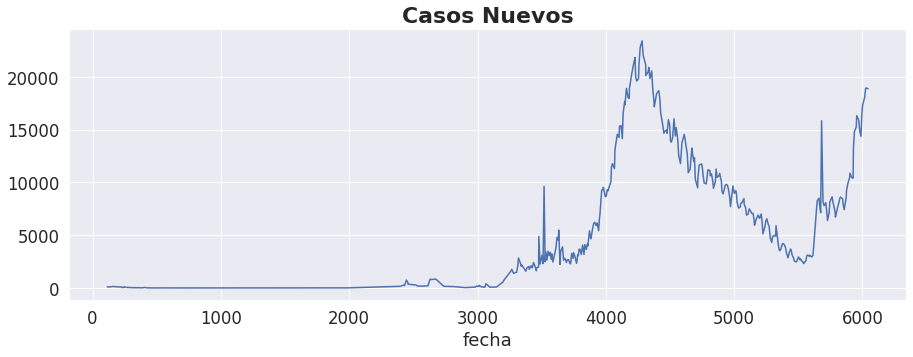

In [844]:
plt.figure(figsize=(15,5))
plt.plot(datos_tai.new_cases)
plt.title("Casos Nuevos", fontsize= 22, fontweight="bold")
plt.xlabel("fecha")

Text(0.5, 0, 'fecha')

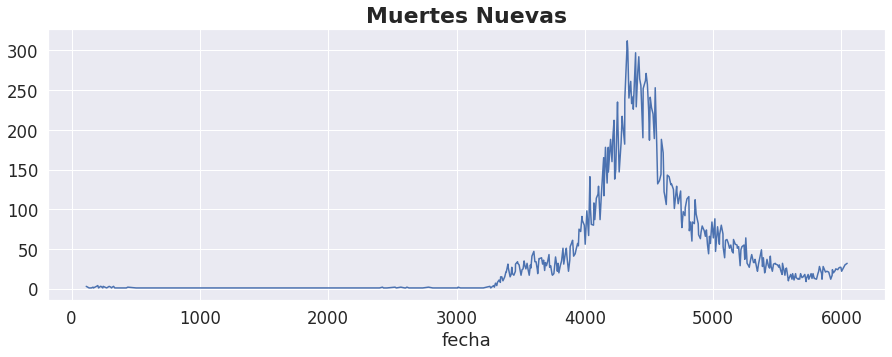

In [845]:
plt.figure(figsize=(15,5))
plt.plot(datos_tai.new_deaths)
plt.title("Muertes Nuevas", fontsize= 22, fontweight="bold")
plt.xlabel("fecha")

Text(0.5, 0, 'fecha')

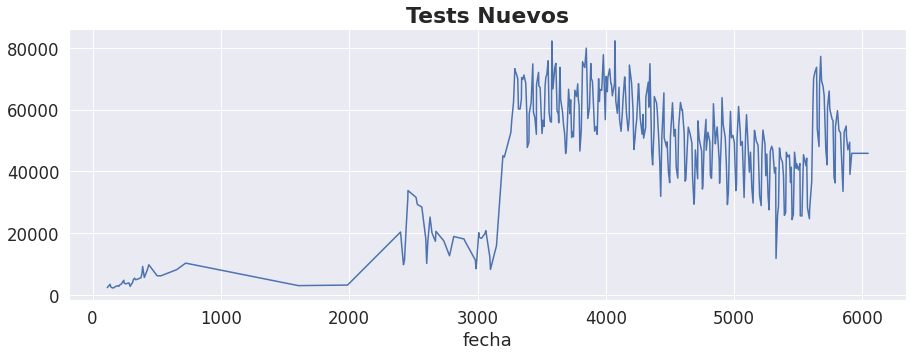

In [846]:
plt.figure(figsize=(15,5))
plt.plot(datos_tai.new_tests)
plt.title("Tests Nuevos", fontsize= 22, fontweight="bold")
plt.xlabel("fecha")

In [847]:
fecha_si = datos_tai.loc[(datos_tai['date'] >= '2021-02-01') & (datos_tai['date'] <= '2021-02-22')]
fecha_no = datos_tai.loc[(datos_tai['date'] >= '2021-06-01') & (datos_tai['date'] <= '2021-07-09')]
datos_tai = pd.concat([fecha_si, fecha_no], axis=0)
datos_tai

new_cases  new_deaths  new_tests       date
2672      836.0         1.0    17360.0 2021-02-01
2676      836.0         1.0    20603.0 2021-02-02
2737      157.0         1.0    17535.0 2021-02-10
2782      143.0         2.0    12679.0 2021-02-15
2815      130.0         1.0    18920.0 2021-02-19
3643     2230.0        38.0    73725.0 2021-06-01
3648     3440.0        38.0    63355.0 2021-06-02
3663     3886.0        39.0    59196.0 2021-06-03
3671     2630.0        31.0    54968.0 2021-06-04
3679     2818.0        36.0    52402.0 2021-06-05
3687     2671.0        23.0    45812.0 2021-06-06
3693     2419.0        33.0    47744.0 2021-06-07
3701     2662.0        29.0    56040.0 2021-06-08
3710     2680.0        34.0    66650.0 2021-06-09
3721     2310.0        43.0    58745.0 2021-06-10
3726     2290.0        27.0    63211.0 2021-06-11
3734     3277.0        29.0    50989.0 2021-06-12
3745     2804.0        18.0    52880.0 2021-06-13
3748     3355.0        17.0    51240.0 2021-06-14
3759     3000.0        19.0    66332.0 2021-06-15
3772     2331.0        40.0    64306.0 2021-06-16
3781     3129.0        30.0    68380.0 2021-06-17
3786     3058.0        22.0    63296.0 2021-06-18
3792     3667.0        32.0    61372.0 2021-06-19
3798     3682.0        20.0    46617.0 2021-06-20
3809     3175.0        29.0    53579.0 2021-06-21
3819     4059.0        35.0    75576.0 2021-06-22
3830     3174.0        51.0    74197.0 2021-06-23
3836     4108.0        31.0    73711.0 2021-06-24
3848     3644.0        44.0    79968.0 2021-06-25
3856     4161.0        51.0    65857.0 2021-06-26
3860     3995.0        42.0    57185.0 2021-06-27
3873     5406.0        22.0    60789.0 2021-06-28
3883     4662.0        36.0    74980.0 2021-06-29
3886     4786.0        53.0    70290.0 2021-06-30
3896     5533.0        57.0    69160.0 2021-07-01
3905     6087.0        61.0    60733.0 2021-07-02
3913     6230.0        41.0    53037.0 2021-07-03
3925     5916.0        44.0    54580.0 2021-07-04
3933     6166.0        50.0    52017.0 2021-07-05
3944     5420.0        57.0    70051.0 2021-07-06
3950     6519.0        54.0    62695.0 2021-07-07
3955     7058.0        75.0    66596.0 2021-07-08
3968     9276.0        72.0    66267.0 2021-07-09

In [848]:
datos_tai['mascarilla'] = np.where((datos_tai['date'] >= '2021-02-01') & (datos_tai['date'] <= '2021-02-22'),1,0)
datos_tai.head()

new_cases  new_deaths  new_tests       date  mascarilla
2672      836.0         1.0    17360.0 2021-02-01           1
2676      836.0         1.0    20603.0 2021-02-02           1
2737      157.0         1.0    17535.0 2021-02-10           1
2782      143.0         2.0    12679.0 2021-02-15           1
2815      130.0         1.0    18920.0 2021-02-19           1

In [849]:
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=42)

In [850]:
X = datos_tai[['new_cases', 'new_deaths', 'new_tests']]
y = datos_tai['mascarilla']

In [851]:
# aplicamos el modelo de regresion logistica
reglog = LogisticRegression()

In [852]:
# entrenamos el modelo con los datos de entrenamiento
reglog = reglog.fit(X_train,y_train)

In [853]:
score = reglog.score(X_test, y_test)
predict = reglog.predict(X_test)

In [854]:
y_train_pred = reglog.predict(X_train)
y_test_pred = reglog.predict(X_test)

In [855]:
print('La precisión del modelo es de', score)

La precisión del modelo es de 0.5263157894736842


In [856]:
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print('Porcentaje de aciertos sobre el set de entrenamiento:', train_acc)
print('Porcentaje de aciertos sobre el set de evaluación:',test_acc)

Porcentaje de aciertos sobre el set de entrenamiento: 0.7857142857142857
Porcentaje de aciertos sobre el set de evaluación: 0.5263157894736842


In [857]:
from sklearn.metrics import confusion_matrix
matriz = confusion_matrix(y_test, y_test_pred)
print('Matriz de Confusión:')
print(matriz)

Matriz de Confusión:
[[10  0]
 [ 9  0]]


In [858]:
nuevos_casos_tai = datos_tai[['mascarilla', 'new_cases']].groupby('mascarilla', as_index = False).sum().sort_values('new_cases', ascending = False)
nuevos_casos_tai

mascarilla  new_cases
0           0   157714.0
1           1     2102.0

In [859]:
nuevas_muertes_tai = datos_tai[['mascarilla', 'new_deaths']].groupby('mascarilla', as_index = False).sum().sort_values('new_deaths', ascending = False)
nuevas_muertes_tai

mascarilla  new_deaths
0           0      1503.0
1           1         6.0

In [860]:
nuevos_tests_tai = datos_tai[['mascarilla', 'new_tests']].groupby('mascarilla', as_index = False).sum().sort_values('new_tests', ascending = False)
nuevos_tests_tai

mascarilla  new_tests
0           0  2408528.0
1           1    87097.0

In [861]:
indicadores_tai = pd.concat([nuevos_casos_tai, nuevas_muertes_tai, nuevos_tests_tai])

Observamos que en Tailandia, en los rangos de fechas donde se aplicó como medida sanitaria el uso de la mascarilla, los indicadores disminuyeron, es decir que fue efectiva.

# **PAIS 8: ITALIA**

In [862]:
datos_ita = datos2[(datos2['pais']=='Italy')]
datos_ita

pais  total_cases  new_cases  total_deaths  new_deaths  \
1     Italy         20.0       17.0           1.0         1.0   
2     Italy         62.0       42.0           2.0         1.0   
3     Italy        155.0       93.0           3.0         1.0   
4     Italy        229.0       74.0           7.0         4.0   
5     Italy        322.0       93.0          10.0         3.0   
...     ...          ...        ...           ...         ...   
6005  Italy   12265343.0    59869.0      151962.0       278.0   
6012  Italy   12323398.0    58055.0      152282.0       320.0   
6021  Italy   12377098.0    53700.0      152596.0       314.0   
6034  Italy   12427773.0    50675.0      152848.0       252.0   
6041  Italy   12469975.0    42202.0      152989.0       141.0   

      reproduction_rate      new_tests   total_tests  positive_rate  \
1              1.095207  253834.364771  5.194936e+07       0.055669   
2              1.095207  253834.364771  5.194936e+07       0.055669   
3              1.095207  253834.364771  5.194936e+07       0.055669   
4              3.570000  253834.364771  4.324000e+03       0.055669   
5              3.520000    4299.000000  8.623000e+03       0.055669   
...                 ...            ...           ...            ...   
6005           0.690000  555080.000000  1.822333e+08       0.106300   
6012           0.680000  538131.000000  1.827714e+08       0.105600   
6021           0.690000  510283.000000  1.832817e+08       0.055669   
6034           1.095207  253834.364771  5.194936e+07       0.055669   
6041           1.095207  253834.364771  5.194936e+07       0.055669   

      population  population_density  median_age  aged_65_older       date  
1     60367471.0             205.859        47.9         23.021 2020-02-21  
2     60367471.0             205.859        47.9         23.021 2020-02-22  
3     60367471.0             205.859        47.9         23.021 2020-02-23  
4     60367471.0             205.859        47.9         23.021 2020-02-24  
5     60367471.0             205.859        47.9         23.021 2020-02-25  
...          ...                 ...         ...            ...        ...  
6005  60367471.0             205.859        47.9         23.021 2022-02-16  
6012  60367471.0             205.859        47.9         23.021 2022-02-17  
6021  60367471.0             205.859        47.9         23.021 2022-02-18  
6034  60367471.0             205.859        47.9         23.021 2022-02-19  
6041  60367471.0             205.859        47.9         23.021 2022-02-20  

[729 rows x 14 columns]

Eliminamos las columnas que toman siempre el mismo valor... esto sucede ya que nos quedamos sólo con los datos de Italia, y eliminamos tambien las columnas que no vamos a usar asi reducimos el dataset.

In [863]:
datos_ita = datos_ita.drop(columns=['pais', 'population', 'population_density', 'aged_65_older', 'median_age', 'total_cases', 'total_deaths', 
                                    'total_tests', 'reproduction_rate', 'positive_rate'])
datos_ita.head(5)

new_cases  new_deaths      new_tests       date
1       17.0         1.0  253834.364771 2020-02-21
2       42.0         1.0  253834.364771 2020-02-22
3       93.0         1.0  253834.364771 2020-02-23
4       74.0         4.0  253834.364771 2020-02-24
5       93.0         3.0    4299.000000 2020-02-25

Text(0.5, 0, 'fecha')

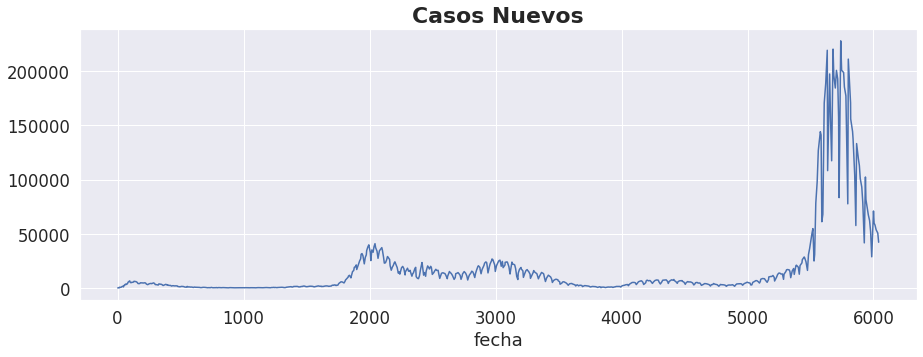

In [864]:
plt.figure(figsize=(15,5))
plt.plot(datos_ita.new_cases)
plt.title("Casos Nuevos", fontsize= 22, fontweight="bold")
plt.xlabel("fecha")

Text(0.5, 0, 'fecha')

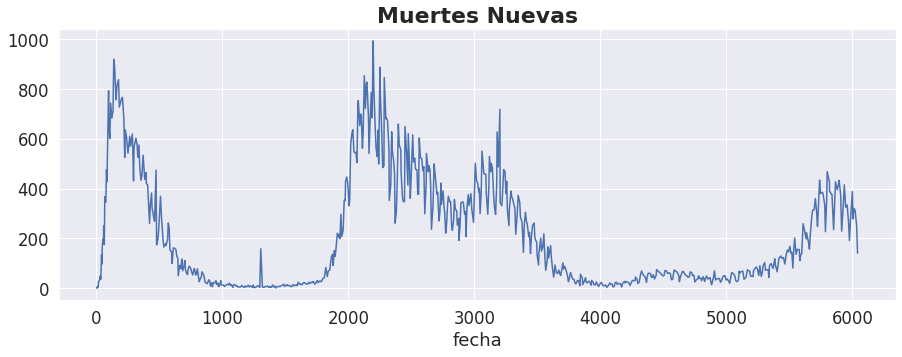

In [865]:
plt.figure(figsize=(15,5))
plt.plot(datos_ita.new_deaths)
plt.title("Muertes Nuevas", fontsize= 22, fontweight="bold")
plt.xlabel("fecha")

Text(0.5, 0, 'fecha')

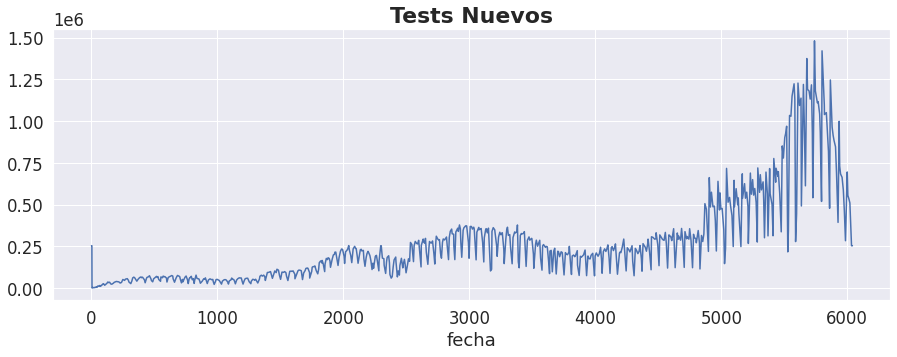

In [866]:
plt.figure(figsize=(15,5))
plt.plot(datos_ita.new_tests)
plt.title("Tests Nuevos", fontsize= 22, fontweight="bold")
plt.xlabel("fecha")

In [867]:
fecha_si = datos_ita.loc[(datos_ita['date'] >= '2020-07-01') & (datos_ita['date'] <= '2020-08-09')]
fecha_no = datos_ita.loc[(datos_ita['date'] >= '2021-07-15') & (datos_ita['date'] <= '2021-08-09')]
datos_ita = pd.concat([fecha_si, fecha_no], axis=0)
datos_ita

new_cases  new_deaths  new_tests       date
941       182.0        21.0    55366.0 2020-07-01
948       201.0        30.0    53243.0 2020-07-02
955       223.0        15.0    50096.0 2020-07-03
964       235.0        21.0    52011.0 2020-07-04
968       192.0         7.0    37462.0 2020-07-05
...         ...         ...        ...        ...
4203     7224.0        27.0   212227.0 2021-08-05
4214     6599.0        24.0   244657.0 2021-08-06
4226     6897.0        22.0   293863.0 2021-08-07
4235     5733.0        11.0   203511.0 2021-08-08
4245     4200.0        22.0   102864.0 2021-08-09

[66 rows x 4 columns]

In [868]:
datos_ita['mascarilla'] = np.where((datos_ita['date'] >= '2020-07-01') & (datos_ita['date'] <= '2020-08-09'),1,0)
datos_ita.head()

new_cases  new_deaths  new_tests       date  mascarilla
941      182.0        21.0    55366.0 2020-07-01           1
948      201.0        30.0    53243.0 2020-07-02           1
955      223.0        15.0    50096.0 2020-07-03           1
964      235.0        21.0    52011.0 2020-07-04           1
968      192.0         7.0    37462.0 2020-07-05           1

In [869]:
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=42)

In [870]:
X = datos_ita[['new_cases', 'new_deaths', 'new_tests']]
y = datos_ita['mascarilla']

In [871]:
# aplicamos el modelo de regresion logistica
reglog = LogisticRegression()

In [872]:
# entrenamos el modelo con los datos de entrenamiento
reglog = reglog.fit(X_train,y_train)

In [873]:
score = reglog.score(X_test, y_test)
predict = reglog.predict(X_test)

In [874]:
y_train_pred = reglog.predict(X_train)
y_test_pred = reglog.predict(X_test)

In [875]:
print('La precisión del modelo es de', score)

La precisión del modelo es de 1.0


In [876]:
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print('Porcentaje de aciertos sobre el set de entrenamiento:', train_acc)
print('Porcentaje de aciertos sobre el set de evaluación:',test_acc)

Porcentaje de aciertos sobre el set de entrenamiento: 1.0
Porcentaje de aciertos sobre el set de evaluación: 1.0


In [877]:
from sklearn.metrics import confusion_matrix
matriz = confusion_matrix(y_test, y_test_pred)
print('Matriz de Confusión:')
print(matriz)

Matriz de Confusión:
[[12  0]
 [ 0  2]]


In [878]:
nuevos_casos_ita = datos_ita[['mascarilla', 'new_cases']].groupby('mascarilla', as_index = False).sum().sort_values('new_cases', ascending = False)
nuevos_casos_ita

mascarilla  new_cases
0           0   124771.0
1           1     9988.0

In [879]:
nuevas_muertes_ita = datos_ita[['mascarilla', 'new_deaths']].groupby('mascarilla', as_index = False).sum().sort_values('new_deaths', ascending = False)
nuevas_muertes_ita

mascarilla  new_deaths
1           1       438.0
0           0       411.0

In [880]:
nuevos_tests_ita = datos_ita[['mascarilla', 'new_tests']].groupby('mascarilla', as_index = False).sum().sort_values('new_tests', ascending = False)
nuevos_tests_ita

mascarilla  new_tests
0           0  5291794.0
1           1  1859734.0

In [881]:
indicadores_ita = pd.concat([nuevos_casos_ita, nuevas_muertes_ita, nuevos_tests_ita])

Observamos que en Italia, los rangos de fechas donde se aplicó como medida sanitaria el uso de la mascarilla, los indicadores de nuevos casos y nuevos tests disminuyeron, y vemos que nuevas muertes aumento muy poco... es decir que podemos concluir que la medida fue efectiva.

# **PAIS 9: ESPAÑA**

In [882]:
datos_esp = datos2[(datos2['pais']=='Spain')]
datos_esp

pais  total_cases  new_cases  total_deaths  new_deaths  \
18    Spain        165.0       45.0           1.0         1.0   
24    Spain        222.0       57.0           2.0         1.0   
25    Spain        259.0       37.0           3.0         1.0   
32    Spain        400.0      141.0           5.0         2.0   
36    Spain        500.0      100.0          10.0         5.0   
...     ...          ...        ...           ...         ...   
5982  Spain   10672906.0    68706.0       96596.0       601.0   
5998  Spain   10707286.0    34380.0       96906.0       310.0   
6006  Spain   10744394.0    37108.0       97350.0       444.0   
6013  Spain   10778607.0    34213.0       97710.0       360.0   
6019  Spain   10809222.0    30615.0       97998.0       288.0   

      reproduction_rate      new_tests   total_tests  positive_rate  \
18                 2.96  135483.048583  3.206315e+07       0.110437   
24                 2.98  135483.048583  3.206315e+07       0.110437   
25                 3.00  135483.048583  3.206315e+07       0.110437   
32                 3.03  135483.048583  3.206315e+07       0.110437   
36                 3.04  135483.048583  3.206315e+07       0.110437   
...                 ...            ...           ...            ...   
5982               0.66  145885.000000  8.418667e+07       0.240000   
5998               0.66  104999.000000  8.429167e+07       0.232000   
6006               0.67  135483.048583  3.206315e+07       0.110437   
6013               0.67  135483.048583  3.206315e+07       0.110437   
6019               0.68  135483.048583  3.206315e+07       0.110437   

      population  population_density  median_age  aged_65_older       date  
18    46745211.0              93.105        45.5         19.436 2020-03-03  
24    46745211.0              93.105        45.5         19.436 2020-03-04  
25    46745211.0              93.105        45.5         19.436 2020-03-05  
32    46745211.0              93.105        45.5         19.436 2020-03-06  
36    46745211.0              93.105        45.5         19.436 2020-03-07  
...          ...                 ...         ...            ...        ...  
5982  46745211.0              93.105        45.5         19.436 2022-02-14  
5998  46745211.0              93.105        45.5         19.436 2022-02-15  
6006  46745211.0              93.105        45.5         19.436 2022-02-16  
6013  46745211.0              93.105        45.5         19.436 2022-02-17  
6019  46745211.0              93.105        45.5         19.436 2022-02-18  

[508 rows x 14 columns]

Eliminamos las columnas que toman siempre el mismo valor... esto sucede ya que nos quedamos sólo con los datos de España, y eliminamos tambien las columnas que no vamos a usar asi reducimos el dataset.

In [883]:
datos_esp = datos_esp.drop(columns=['pais', 'population', 'population_density', 'aged_65_older', 'median_age', 'total_cases', 'total_deaths', 
                                    'total_tests', 'reproduction_rate', 'positive_rate'])
datos_esp.head(5)

new_cases  new_deaths      new_tests       date
18       45.0         1.0  135483.048583 2020-03-03
24       57.0         1.0  135483.048583 2020-03-04
25       37.0         1.0  135483.048583 2020-03-05
32      141.0         2.0  135483.048583 2020-03-06
36      100.0         5.0  135483.048583 2020-03-07

Text(0.5, 0, 'fecha')

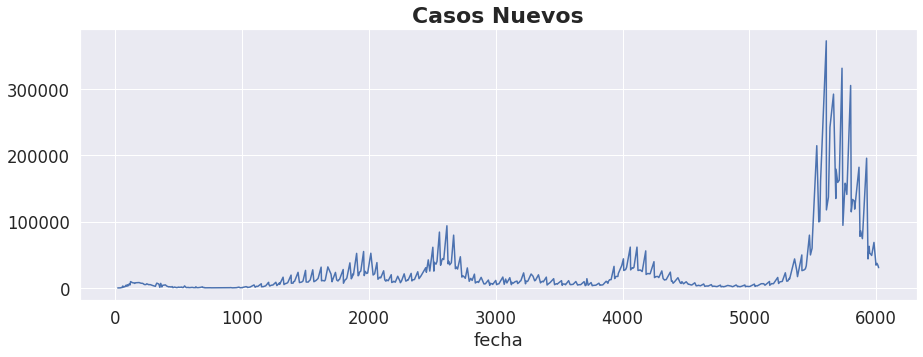

In [884]:
plt.figure(figsize=(15,5))
plt.plot(datos_esp.new_cases)
plt.title("Casos Nuevos", fontsize= 22, fontweight="bold")
plt.xlabel("fecha")

Text(0.5, 0, 'fecha')

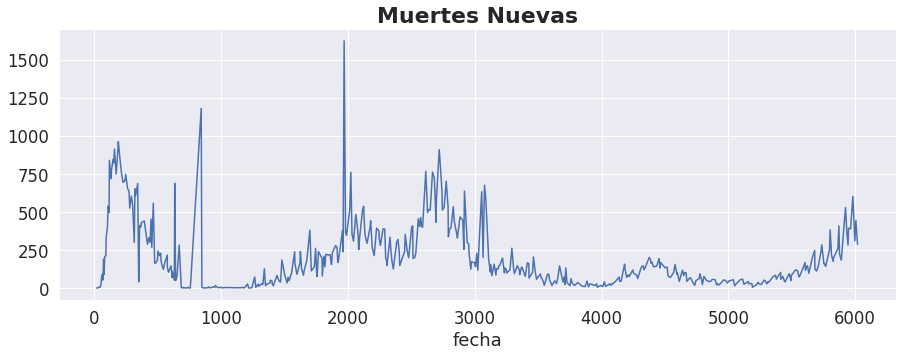

In [885]:
plt.figure(figsize=(15,5))
plt.plot(datos_esp.new_deaths)
plt.title("Muertes Nuevas", fontsize= 22, fontweight="bold")
plt.xlabel("fecha")

Text(0.5, 0, 'fecha')

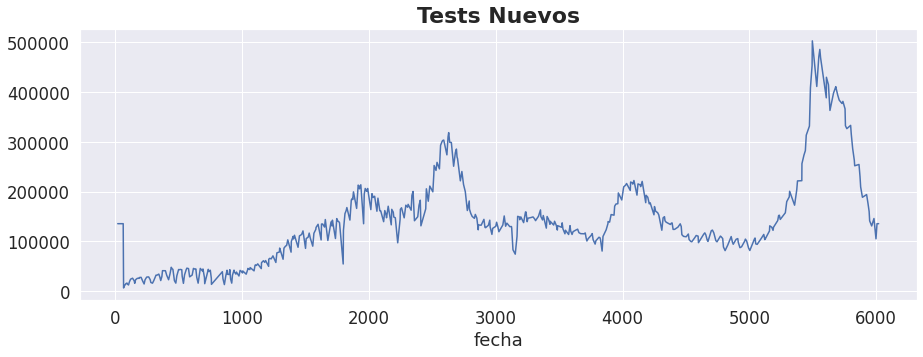

In [886]:
plt.figure(figsize=(15,5))
plt.plot(datos_esp.new_tests)
plt.title("Tests Nuevos", fontsize= 22, fontweight="bold")
plt.xlabel("fecha")

In [887]:
fecha_si = datos_esp.loc[(datos_esp['date'] >= '2020-11-01') & (datos_esp['date'] <= '2020-12-09')]
fecha_no = datos_esp.loc[(datos_esp['date'] >= '2021-07-15') & (datos_esp['date'] <= '2021-08-09')]
datos_esp = pd.concat([fecha_si, fecha_no], axis=0)
datos_esp

new_cases  new_deaths  new_tests       date
1957    55019.0       379.0   135376.0 2020-11-02
1962    18669.0       238.0   195004.0 2020-11-03
1970    25042.0      1623.0   206261.0 2020-11-04
1981    21908.0       368.0   200467.0 2020-11-05
1989    22516.0       347.0   206264.0 2020-11-06
2014    52386.0       512.0   163745.0 2020-11-09
2023    36491.0       760.0   195867.0 2020-11-11
2032    19511.0       356.0   188095.0 2020-11-12
2044    21371.0       308.0   190665.0 2020-11-13
2062    38273.0       484.0   160510.0 2020-11-16
2070    13159.0       435.0   186817.0 2020-11-17
2080    15318.0       351.0   169100.0 2020-11-18
2085    16233.0       252.0   161422.0 2020-11-19
2092    15156.0       328.0   161191.0 2020-11-20
2115    25886.0       512.0   139519.0 2020-11-23
2124    12228.0       537.0   161868.0 2020-11-24
2133    10222.0       369.0   154671.0 2020-11-25
2138    12289.0       337.0   147376.0 2020-11-26
2151    10853.0       294.0   170569.0 2020-11-27
2175    19979.0       401.0   133175.0 2020-11-30
2179     8257.0       442.0   164361.0 2020-12-01
2191     9331.0       273.0   158612.0 2020-12-02
2195    10127.0       254.0   148842.0 2020-12-03
2207     8745.0       214.0   147421.0 2020-12-04
2226    17681.0       394.0    97037.0 2020-12-07
2245     9773.0       373.0   144499.0 2020-12-09
4023    27688.0        41.0   212844.0 2021-07-15
4031    31060.0        12.0   216250.0 2021-07-16
4060    61628.0        23.0   202300.0 2021-07-19
4063    27286.0        29.0   219277.0 2021-07-20
4076    30587.0        18.0   217523.0 2021-07-21
4080    29535.0        28.0   215065.0 2021-07-22
4089    31171.0        27.0   222275.0 2021-07-23
4113    61625.0        47.0   192904.0 2021-07-26
4121    26399.0        55.0   215483.0 2021-07-27
4139    27149.0        73.0   213353.0 2021-07-28
4142    26689.0        46.0   209995.0 2021-07-29
4154    24753.0        44.0   220476.0 2021-07-30
4182    55939.0       157.0   177736.0 2021-08-02
4185    20327.0       130.0   192583.0 2021-08-03
4198    21874.0        71.0   188707.0 2021-08-04
4210    21387.0        87.0   175411.0 2021-08-05
4217    21561.0        75.0   177563.0 2021-08-06
4247    39638.0       119.0   153350.0 2021-08-09

In [888]:
datos_esp['mascarilla'] = np.where((datos_esp['date'] >= '2020-11-01') & (datos_esp['date'] <= '2020-12-09'),1,0)
datos_esp.head()

new_cases  new_deaths  new_tests       date  mascarilla
1957    55019.0       379.0   135376.0 2020-11-02           1
1962    18669.0       238.0   195004.0 2020-11-03           1
1970    25042.0      1623.0   206261.0 2020-11-04           1
1981    21908.0       368.0   200467.0 2020-11-05           1
1989    22516.0       347.0   206264.0 2020-11-06           1

In [889]:
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=42)

In [890]:
X = datos_esp[['new_cases', 'new_deaths', 'new_tests']]
y = datos_esp['mascarilla']

In [891]:
# aplicamos el modelo de regresion logistica
reglog = LogisticRegression()

In [892]:
# entrenamos el modelo con los datos de entrenamiento
reglog = reglog.fit(X_train,y_train)

In [893]:
score = reglog.score(X_test, y_test)
predict = reglog.predict(X_test)

In [894]:
y_train_pred = reglog.predict(X_train)
y_test_pred = reglog.predict(X_test)

In [895]:
print('La precisión del modelo es de', score)

La precisión del modelo es de 1.0


In [896]:
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print('Porcentaje de aciertos sobre el set de entrenamiento:', train_acc)
print('Porcentaje de aciertos sobre el set de evaluación:',test_acc)

Porcentaje de aciertos sobre el set de entrenamiento: 1.0
Porcentaje de aciertos sobre el set de evaluación: 1.0


In [897]:
from sklearn.metrics import confusion_matrix
matriz = confusion_matrix(y_test, y_test_pred)
print('Matriz de Confusión:')
print(matriz)

Matriz de Confusión:
[[ 7  0]
 [ 0 13]]


In [898]:
nuevos_casos_esp = datos_esp[['mascarilla', 'new_cases']].groupby('mascarilla', as_index = False).sum().sort_values('new_cases', ascending = False)
nuevos_casos_esp

mascarilla  new_cases
0           0   586296.0
1           1   526423.0

In [899]:
nuevas_muertes_esp = datos_esp[['mascarilla', 'new_deaths']].groupby('mascarilla', as_index = False).sum().sort_values('new_deaths', ascending = False)
nuevas_muertes_esp

mascarilla  new_deaths
1           1     11141.0
0           0      1082.0

In [900]:
nuevos_tests_esp = datos_esp[['mascarilla', 'new_tests']].groupby('mascarilla', as_index = False).sum().sort_values('new_tests', ascending = False)
nuevos_tests_esp

mascarilla  new_tests
1           1  4288734.0
0           0  3623095.0

In [901]:
indicadores_esp = pd.concat([nuevos_casos_esp, nuevas_muertes_esp, nuevos_tests_esp])

En España, vemos que en los rangos de fechas donde se aplicó como medida sanitaria el uso de la mascarilla, solo la cantidad de nuevos casos disminuyó pero los otros dos indicadores aumentaron, es decir que no fue efectiva.

# **PAIS 10: FRANCIA**

In [902]:
datos_fra = datos2[(datos2['pais']=='France')]
datos_fra

pais  total_cases  new_cases  total_deaths  new_deaths  \
0     France         12.0        1.0           1.0         1.0   
7     France         18.0        4.0           2.0         1.0   
14    France        191.0       61.0           3.0         1.0   
20    France        212.0       21.0           4.0         1.0   
27    France        426.0      138.0           7.0         3.0   
...      ...          ...        ...           ...         ...   
6003  France   22028827.0   240988.0      135924.0       666.0   
6016  France   22121273.0    92446.0      136211.0       287.0   
6024  France   22203912.0    82639.0      136516.0       305.0   
6036  France   22280464.0    76552.0      136663.0       147.0   
6040  France   22339467.0    59003.0      136664.0         1.0   

      reproduction_rate      new_tests   total_tests  positive_rate  \
0              1.114701  387734.009693  8.065163e+07       0.064832   
7              1.114701  387734.009693  8.065163e+07       0.064832   
14             2.990000  387734.009693  8.065163e+07       0.064832   
20             2.990000  387734.009693  8.065163e+07       0.064832   
27             3.040000  387734.009693  8.065163e+07       0.064832   
...                 ...            ...           ...            ...   
6003           0.650000  387734.009693  8.065163e+07       0.064832   
6016           0.640000  387734.009693  8.065163e+07       0.064832   
6024           0.640000  387734.009693  8.065163e+07       0.064832   
6036           1.114701  387734.009693  8.065163e+07       0.064832   
6040           1.114701  387734.009693  8.065163e+07       0.064832   

      population  population_density  median_age  aged_65_older       date  
0     67422000.0             122.578        42.0         19.718 2020-02-15  
7     67422000.0             122.578        42.0         19.718 2020-02-26  
14    67422000.0             122.578        42.0         19.718 2020-03-02  
20    67422000.0             122.578        42.0         19.718 2020-03-03  
27    67422000.0             122.578        42.0         19.718 2020-03-05  
...          ...                 ...         ...            ...        ...  
6003  67422000.0             122.578        42.0         19.718 2022-02-16  
6016  67422000.0             122.578        42.0         19.718 2022-02-17  
6024  67422000.0             122.578        42.0         19.718 2022-02-18  
6036  67422000.0             122.578        42.0         19.718 2022-02-19  
6040  67422000.0             122.578        42.0         19.718 2022-02-20  

[689 rows x 14 columns]

Eliminamos las columnas que toman siempre el mismo valor... esto sucede ya que nos quedamos sólo con los datos de Francia, y eliminamos tambien las columnas que no vamos a usar asi reducimos el dataset.

In [903]:
datos_fra = datos_fra.drop(columns=['pais', 'population', 'population_density', 'aged_65_older', 'median_age', 'total_cases', 'total_deaths', 
                                    'total_tests', 'reproduction_rate', 'positive_rate'])
datos_fra.head(5)

new_cases  new_deaths      new_tests       date
0         1.0         1.0  387734.009693 2020-02-15
7         4.0         1.0  387734.009693 2020-02-26
14       61.0         1.0  387734.009693 2020-03-02
20       21.0         1.0  387734.009693 2020-03-03
27      138.0         3.0  387734.009693 2020-03-05

Text(0.5, 0, 'fecha')

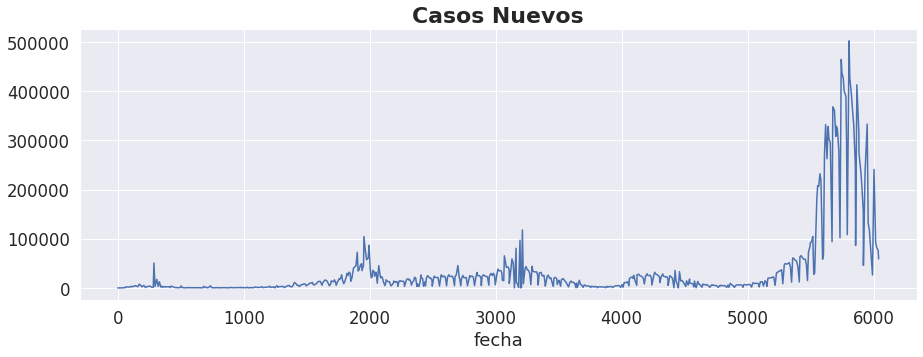

In [904]:
plt.figure(figsize=(15,5))
plt.plot(datos_fra.new_cases)
plt.title("Casos Nuevos", fontsize= 22, fontweight="bold")
plt.xlabel("fecha")

Text(0.5, 0, 'fecha')

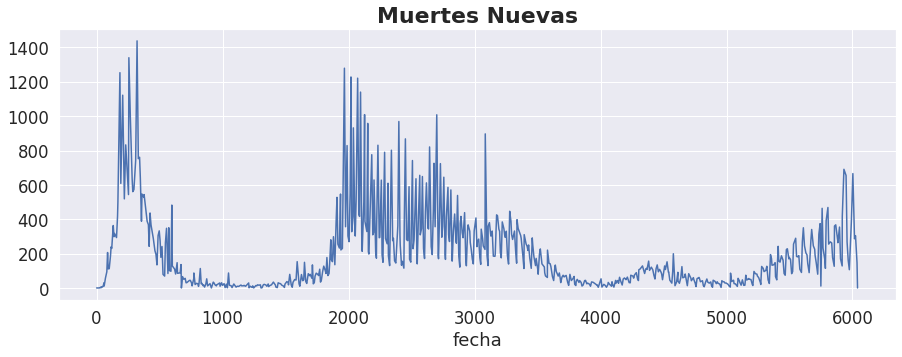

In [905]:
plt.figure(figsize=(15,5))
plt.plot(datos_fra.new_deaths)
plt.title("Muertes Nuevas", fontsize= 22, fontweight="bold")
plt.xlabel("fecha")

Text(0.5, 0, 'fecha')

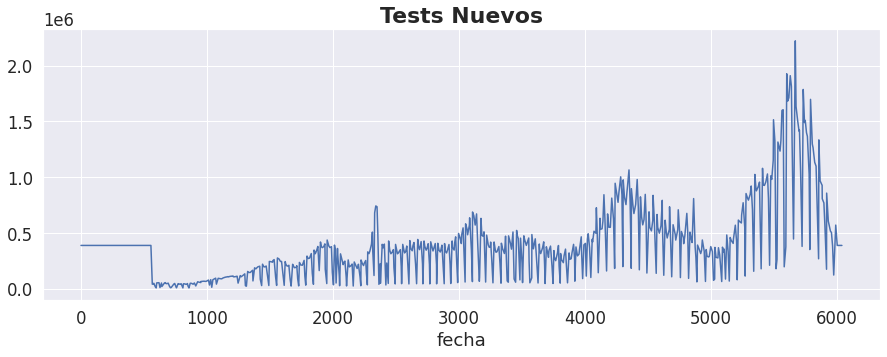

In [906]:
plt.figure(figsize=(15,5))
plt.plot(datos_fra.new_tests)
plt.title("Tests Nuevos", fontsize= 22, fontweight="bold")
plt.xlabel("fecha")

In [907]:
fecha_si = datos_fra.loc[(datos_fra['date'] >= '2020-10-01') & (datos_fra['date'] <= '2020-11-09')]
fecha_no = datos_fra.loc[(datos_fra['date'] >= '2021-10-01') & (datos_fra['date'] <= '2021-10-22')]
datos_fra = pd.concat([fecha_si, fecha_no], axis=0)
datos_fra

new_cases  new_deaths  new_tests       date
1709    13025.0        57.0   191768.0 2020-10-01
1713    12324.0       135.0   205973.0 2020-10-02
1720    16514.0        25.0    89128.0 2020-10-03
1728    12504.0        32.0    25097.0 2020-10-04
1734     5375.0        70.0   235404.0 2020-10-05
1743    11310.0        87.0   213566.0 2020-10-06
1757    18823.0        79.0   209913.0 2020-10-07
1762    17340.0        73.0   226355.0 2020-10-08
1771    20697.0       110.0   253769.0 2020-10-09
1777    26677.0        35.0   112274.0 2020-10-10
1784    15994.0        46.0    31662.0 2020-10-11
1794     8715.0        96.0   292276.0 2020-10-12
1803    13626.0       128.0   270080.0 2020-10-13
1814    22643.0       104.0   273485.0 2020-10-14
1821    29757.0        85.0   294260.0 2020-10-15
1828    25410.0       178.0   314899.0 2020-10-16
1836    32139.0        73.0   137636.0 2020-10-17
1845    29837.0        85.0    39288.0 2020-10-18
1850    13538.0       146.0   346446.0 2020-10-19
1859    20376.0       281.0   313251.0 2020-10-20
1863    26797.0       165.0   321828.0 2020-10-21
1872    40813.0       154.0   347546.0 2020-10-22
1880    42213.0       299.0   378492.0 2020-10-23
1891    45265.0       136.0   162142.0 2020-10-24
1901    72438.0       383.0   418365.0 2020-10-26
1908    34458.0       528.0   376280.0 2020-10-27
1915    36719.0       256.0   367972.0 2020-10-28
1927    46636.0       233.0   377046.0 2020-10-29
1936    49473.0       547.0   401738.0 2020-10-30
1939    35101.0       222.0   172341.0 2020-10-31
1951    46179.0       231.0    45700.0 2020-11-01
1954   104707.0       419.0   436076.0 2020-11-02
1967    72298.0      1279.0   383146.0 2020-11-03
1976    57352.0       357.0   368557.0 2020-11-05
1988    60711.0       829.0   376705.0 2020-11-06
1995    86655.0       303.0   147212.0 2020-11-07
2004    38562.0       270.0    34818.0 2020-11-08
2012    20739.0       550.0   390580.0 2020-11-09
4741     4935.0        49.0   707413.0 2021-10-01
4751     4948.0        30.0   528232.0 2021-10-02
4758     3744.0         9.0    99419.0 2021-10-03
4766     1138.0        55.0   512831.0 2021-10-04
4782     5582.0        62.0   456650.0 2021-10-05
4784     4570.0        59.0   403413.0 2021-10-06
4793     5006.0        37.0   472171.0 2021-10-07
4809     4470.0        43.0   675274.0 2021-10-08
4816     4734.0        15.0   513558.0 2021-10-09
4823     3991.0         8.0    92281.0 2021-10-10
4834     1120.0        35.0   507284.0 2021-10-11
4844     5880.0        53.0   444980.0 2021-10-12
4851     1359.0        35.0   413801.0 2021-10-13
4863     9474.0        29.0   807823.0 2021-10-14
4875     6099.0        36.0   373296.0 2021-10-15
4881     4899.0        15.0   283697.0 2021-10-16
4889     3778.0         5.0    60671.0 2021-10-17
4894     1057.0        46.0   391024.0 2021-10-18
4909     5945.0        39.0   347376.0 2021-10-19
4919     6036.0        26.0   314645.0 2021-10-20
4926     6127.0        37.0   342016.0 2021-10-21
4932     6366.0        29.0   436541.0 2021-10-22

In [908]:
datos_fra['mascarilla'] = np.where((datos_fra['date'] >= '2020-10-01') & (datos_fra['date'] <= '2020-11-09'),1,0)
datos_fra.head()

new_cases  new_deaths  new_tests       date  mascarilla
1709    13025.0        57.0   191768.0 2020-10-01           1
1713    12324.0       135.0   205973.0 2020-10-02           1
1720    16514.0        25.0    89128.0 2020-10-03           1
1728    12504.0        32.0    25097.0 2020-10-04           1
1734     5375.0        70.0   235404.0 2020-10-05           1

In [909]:
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=42)

In [910]:
X = datos_fra[['new_cases', 'new_deaths', 'new_tests']]
y = datos_fra['mascarilla']

In [911]:
# aplicamos el modelo de regresion logistica
reglog = LogisticRegression()

In [912]:
# entrenamos el modelo con los datos de entrenamiento
reglog = reglog.fit(X_train,y_train)

In [913]:
score = reglog.score(X_test, y_test)
predict = reglog.predict(X_test)

In [914]:
y_train_pred = reglog.predict(X_train)
y_test_pred = reglog.predict(X_test)

In [915]:
print('La precisión del modelo es de', score)

La precisión del modelo es de 1.0


In [916]:
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print('Porcentaje de aciertos sobre el set de entrenamiento:', train_acc)
print('Porcentaje de aciertos sobre el set de evaluación:',test_acc)

Porcentaje de aciertos sobre el set de entrenamiento: 1.0
Porcentaje de aciertos sobre el set de evaluación: 1.0


In [917]:
from sklearn.metrics import confusion_matrix
matriz = confusion_matrix(y_test, y_test_pred)
print('Matriz de Confusión:')
print(matriz)

Matriz de Confusión:
[[6 0]
 [0 8]]


In [918]:
nuevos_casos_fra = datos_fra[['mascarilla', 'new_cases']].groupby('mascarilla', as_index = False).sum().sort_values('new_cases', ascending = False)
nuevos_casos_fra

mascarilla  new_cases
1           1  1283740.0
0           0   101258.0

In [919]:
nuevas_muertes_fra = datos_fra[['mascarilla', 'new_deaths']].groupby('mascarilla', as_index = False).sum().sort_values('new_deaths', ascending = False)
nuevas_muertes_fra

mascarilla  new_deaths
1           1      9086.0
0           0       752.0

In [920]:
nuevos_tests_fra = datos_fra[['mascarilla', 'new_tests']].groupby('mascarilla', as_index = False).sum().sort_values('new_tests', ascending = False)
nuevos_tests_fra

mascarilla  new_tests
1           1  9583074.0
0           0  9184396.0

In [ ]:
indicadores_fra = pd.concat([nuevos_casos_fra, nuevas_muertes_fra, nuevos_tests_fra])

En Francia, vemos que los tres indicadores aumentaron cuando se usó como medida sanitaria la mascarilla, es decir que esta medida no fue efectiva.

Como propuesta para seguir investigando, creo que sería interesante probar el cumplimiento de las medidas sanitarias con respecto a la edad de las personas, también las enfermedades preexistentes en las personas que tuvieron que ser internadas y la relación con los fallecidos.

# **Conslusiones**

- El error de los datos mundiales dio muy alto en comparación con los errores calculados en los paises analizados. Esto puede deberse a que es muy dificil tener una única medida que resuma lo que pasa en el mundo. El mundo es muy heterogeneo para resumir el comportamiento de una variable mundial en un único valor, hay muchas variables que no se pueden medir y que influyen en la cantidad de contagios de una enfermedad.
- En todos los paises analizados tuvieron uno o varios picos de casos de Covid_19.
- No siempre la medida sanitaria, uso de mascarilla, fue eficiente ya que las personas no siempre cumplen las normas de su pais impuestas por el gobierno de turno, ya se sea por ideaologias politicas, por la edad u otras.
- En algunos paises, los nuevos casos de muertes aumentaban cuando el uso de la mascarilla era obligatorio. Esto puede deberse a que eran personas que se les complicó el cuadro de Covid mientras la medida sanitaria no era obligatoria y en las fechas en que si lo era, se produjo el desceso; para validar esto, tendriamos que analizar la fecha de internación para ver si coincide con la flexibilización en la medida sanitaria.
